In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import numpy as np

In [31]:
from josie.bc import Dirichlet, Neumann, NeumannDirichlet
from josie.geom import Line
from josie.solver.euler import Q, EulerSolver, PerfectGas, Rusanov
from josie.mesh import Mesh, SimpleCell

left = Line([0, 0], [0, 1])
bottom = Line([0, 0], [1, 0])
right = Line([1, 0], [1, 1])
top = Line([0, 1], [1, 1])

eos = PerfectGas(gamma=1.4)

# Params
JET_CENTER = 0.5
JET_RADIUS = 0.05

# Inlet
U_JET = 1
V_JET = 0
RHO_JET = 1000
P_JET = 1e5

RHOe_JET = eos.rhoe(RHO_JET, P_JET)
E_JET = RHOe_JET/RHO_JET + 0.5 * (U_JET**2 + V_JET**2)
C_JET = eos.sound_velocity(RHO_JET, P_JET)
print(f"Mach: {U_JET/C_JET}")
Q_JET = Q(RHO_JET, RHO_JET*U_JET, RHO_JET*V_JET, RHO_JET*E_JET, RHOe_JET, U_JET, V_JET, P_JET, C_JET)

# Field conditions at init
U_INIT = 0
V_INIT = 0
RHO_INIT = RHO_JET/1000
P_INIT = P_JET
RHOe_INIT = eos.rhoe(RHO_INIT, P_INIT)
E_INIT = RHOe_INIT/RHO_INIT + 0.5 * (U_INIT**2 + V_INIT**2)
C_INIT = eos.sound_velocity(RHO_INIT, P_INIT)

print(f"Mach: {U_INIT/C_INIT}")

Q_INIT = Q(RHO_INIT, RHO_INIT*U_INIT, RHO_INIT*V_INIT, RHO_INIT*E_INIT, RHOe_INIT, 
           U_INIT, V_INIT, P_INIT, C_INIT)

# Neumann
dQ = Q.zeros()

def partition_fun(centroids: np.ndarray):
    yc = centroids[:, 1]
    
    # Partition cells of the inlet
    idx = np.where((yc - JET_CENTER)**2 < JET_RADIUS**2)
    
    return idx


# Assign BC to boundaries
left.bc = NeumannDirichlet(dirichlet_value=Q_JET, neumann_value=dQ, partition_fun=partition_fun)
# left.bc = Dirichlet(Q_JET)
top.bc = Dirichlet(Q_INIT)
right.bc = Neumann(dQ)
bottom.bc = Dirichlet(Q_INIT)

mesh = Mesh(left, bottom, right, top, SimpleCell)
mesh.interpolate(100, 100)
mesh.generate()
mesh.write('mesh.xdmf')
# mesh.plot()

Mach: 0.08451542547285165
Mach: 0.0


In [32]:
# Solver
solver = EulerSolver(mesh, eos)



def init_fun(solver): 
    solver.values[:, :, :] = Q_INIT
    

solver.init(init_fun)

In [33]:
final_time = 0.25
t = 0

t_save = 0
dt_save = 0.001
should_save = False


CFL = 0.2
scheme = Rusanov()

while t <= final_time:
    if should_save:
        solver.animate(t)
        solver.save(t, 'euler.xdmf')
        should_save = False
        
    dt = scheme.CFL(
        solver.values, 
        solver.mesh.volumes, 
        solver.mesh.normals,
        solver.mesh.surfaces,
        CFL,
    )
    
    cur_t = t + dt
    
    if cur_t > (t_save + dt_save):
        should_save = True
        dt = (t_save + dt_save) - t
        t_save = t + dt
    
    solver.step(dt, scheme)
    t += dt
    print(f't: {t}, dt: {dt}')



del solver._writer

t: 5.345224838248196e-06, dt: 5.345224838248196e-06
t: 1.0676220777387209e-05, dt: 5.330995939139013e-06
t: 1.6007223990917646e-05, dt: 5.331003213530437e-06
t: 2.133822927801025e-05, dt: 5.331005287092605e-06
t: 2.666923693046457e-05, dt: 5.3310076524543185e-06
t: 3.2000246803398274e-05, dt: 5.331009872933703e-06
t: 3.7331258769963694e-05, dt: 5.331011966565423e-06
t: 4.2662272725198035e-05, dt: 5.331013955234342e-06
t: 4.799328858194872e-05, dt: 5.3310158567506865e-06
t: 5.332430626704878e-05, dt: 5.331017685100053e-06
t: 5.8655325718393676e-05, dt: 5.331019451344896e-06
t: 6.398634688271623e-05, dt: 5.331021164322554e-06
t: 6.931736971390808e-05, dt: 5.331022831191842e-06
t: 7.464839417174788e-05, dt: 5.331024457839797e-06
t: 7.99794202208617e-05, dt: 5.331026049113825e-06
t: 8.531044782990523e-05, dt: 5.331027609043537e-06
t: 9.064147697089227e-05, dt: 5.331029140987039e-06
t: 9.597250761860649e-05, dt: 5.33103064771422e-06
t: 0.00010130353975002468, dt: 5.331032131418187e-06
t: 0.

t: 0.0009222103197873625, dt: 5.3300608094721155e-06
t: 0.00092754038109505, dt: 5.330061307687501e-06
t: 0.0009328704433973434, dt: 5.330062302293452e-06
t: 0.0009382005060934143, dt: 5.330062696070932e-06
t: 0.0009435305676584405, dt: 5.330061565026235e-06
t: 0.0009488606285581055, dt: 5.330060899665026e-06
t: 0.0009541906892445223, dt: 5.330060686416874e-06
t: 0.0009595207501564005, dt: 5.330060911878226e-06
t: 0.0009648508117192675, dt: 5.330061562867056e-06
t: 0.0009701808743457404, dt: 5.3300626264728694e-06
t: 0.0009755109384358425, dt: 5.330064090102072e-06
t: 0.0009808410043773614, dt: 5.330065941518879e-06
t: 0.000986171070276671, dt: 5.330065899309724e-06
t: 0.0009915011363509914, dt: 5.330066074320291e-06
t: 0.0009968312029720974, dt: 5.33006662110589e-06
t: 0.001, dt: 3.168797027902669e-06
t: 0.0010053300682700207, dt: 5.330068270020669e-06
t: 0.0010106601379904386, dt: 5.330069720417747e-06
t: 0.001015990209488029, dt: 5.330071497590469e-06
t: 0.0010213202830778316, dt: 5

t: 0.0017942004935441833, dt: 5.3302956438755746e-06
t: 0.0017995307907387424, dt: 5.330297194559045e-06
t: 0.0018048610895174024, dt: 5.3302987786599564e-06
t: 0.0018101913899124533, dt: 5.330300395050782e-06
t: 0.0018155216919550775, dt: 5.33030204262422e-06
t: 0.0018208519956753706, dt: 5.330303720293128e-06
t: 0.0018261823011023611, dt: 5.330305426990461e-06
t: 0.0018315126082640303, dt: 5.330307161669191e-06
t: 0.0018368429171873326, dt: 5.330308923302235e-06
t: 0.001842173227898215, dt: 5.330310710882353e-06
t: 0.001847503540421637, dt: 5.330312523422061e-06
t: 0.0018528338547815905, dt: 5.330314359953521e-06
t: 0.001858164171001119, dt: 5.330316219528438e-06
t: 0.0018634944891023368, dt: 5.330318101217931e-06
t: 0.0018688248090937543, dt: 5.33031999141741e-06
t: 0.0018741551305234895, dt: 5.3303214297352154e-06
t: 0.0018794854534144314, dt: 5.3303228909417925e-06
t: 0.0018848157777886082, dt: 5.330324374176886e-06
t: 0.001890146103667207, dt: 5.330325878598754e-06
t: 0.001895476

t: 0.002703622522168973, dt: 5.3305568192921895e-06
t: 0.0027089530797364788, dt: 5.330557567505637e-06
t: 0.002714283638050558, dt: 5.330558314079461e-06
t: 0.0027196141971095994, dt: 5.330559059041316e-06
t: 0.0027249447569120187, dt: 5.330559802419181e-06
t: 0.00273027531745626, dt: 5.330560544241344e-06
t: 0.0027356058787256802, dt: 5.3305612694204615e-06
t: 0.0027409364407100937, dt: 5.330561984413484e-06
t: 0.0027462670034078653, dt: 5.330562697771764e-06
t: 0.0027515975666297966, dt: 5.330563221931292e-06
t: 0.0027569281303633643, dt: 5.330563733567588e-06
t: 0.0027622586946073383, dt: 5.330564243973966e-06
t: 0.0027675892593605244, dt: 5.330564753185991e-06
t: 0.0027729198246217637, dt: 5.3305652612393575e-06
t: 0.0027782503903899334, dt: 5.330565768169879e-06
t: 0.0027835809566639468, dt: 5.330566274013488e-06
t: 0.0027889115234306836, dt: 5.330566766736965e-06
t: 0.0027942420906779696, dt: 5.3305672472860216e-06
t: 0.002799572658404656, dt: 5.330567726686256e-06
t: 0.00280490

t: 0.00360235770926663, dt: 5.330612915056442e-06
t: 0.003607688322414941, dt: 5.3306131483110806e-06
t: 0.0036130189357977066, dt: 5.330613382765692e-06
t: 0.0036183495494161444, dt: 5.3306136184377995e-06
t: 0.003623680163271489, dt: 5.330613855344706e-06
t: 0.0036290107773649925, dt: 5.330614093503491e-06
t: 0.0036343413916979234, dt: 5.330614332930999e-06
t: 0.003639672006271567, dt: 5.3306145736438285e-06
t: 0.0036450026210872255, dt: 5.330614815658334e-06
t: 0.00365033323614469, dt: 5.3306150574645825e-06
t: 0.003655663851426477, dt: 5.330615281786763e-06
t: 0.0036609944669337632, dt: 5.330615507286104e-06
t: 0.0036663250826677396, dt: 5.330615733976392e-06
t: 0.0036716556986296106, dt: 5.330615961871121e-06
t: 0.003676986314820594, dt: 5.330616190983477e-06
t: 0.0036823169312419205, dt: 5.330616421326343e-06
t: 0.003687647547894833, dt: 5.330616652912287e-06
t: 0.0036929781647805863, dt: 5.330616885753559e-06
t: 0.0036983087819004484, dt: 5.3306171198620875e-06
t: 0.003703639399

t: 0.0045117415987256096, dt: 5.330653043206639e-06
t: 0.004517072252026212, dt: 5.33065330060233e-06
t: 0.00452240290558542, dt: 5.330653559208241e-06
t: 0.004527733559404755, dt: 5.330653819335142e-06
t: 0.004533064213485742, dt: 5.330654080987268e-06
t: 0.004538394867829911, dt: 5.330654344168541e-06
t: 0.004543725522438793, dt: 5.330654608882579e-06
t: 0.004549056177313926, dt: 5.330654875132698e-06
t: 0.004554386832456848, dt: 5.3306551429219155e-06
t: 0.004559717487869101, dt: 5.330655412252956e-06
t: 0.004565048143552229, dt: 5.330655683128253e-06
t: 0.0045703787995077785, dt: 5.33065595554996e-06
t: 0.0045757094557372984, dt: 5.330656229519943e-06
t: 0.0045810401122423385, dt: 5.3306565050398035e-06
t: 0.004586370769024449, dt: 5.3306567821108755e-06
t: 0.004591701426085184, dt: 5.330657060734232e-06
t: 0.004597032083426094, dt: 5.330657340910694e-06
t: 0.004602362741048735, dt: 5.33065762264084e-06
t: 0.00460769339895466, dt: 5.330657905925011e-06
t: 0.004613024057145423, dt: 

t: 0.005415794033743315, dt: 5.33070537326333e-06
t: 0.005421124739443763, dt: 5.330705700448494e-06
t: 0.005426455445472208, dt: 5.330706028444586e-06
t: 0.005431786151829447, dt: 5.330706357239145e-06
t: 0.005437116858516266, dt: 5.330706686819466e-06
t: 0.005442447565533439, dt: 5.330707017172603e-06
t: 0.0054477782728817245, dt: 5.330707348285388e-06
t: 0.005453108980561869, dt: 5.330707680144446e-06
t: 0.005458439688574605, dt: 5.330708012736208e-06
t: 0.005463770396920652, dt: 5.33070834604693e-06
t: 0.005469101105600715, dt: 5.330708680062702e-06
t: 0.0054744318146154845, dt: 5.330709014769473e-06
t: 0.005479762523965637, dt: 5.330709350153061e-06
t: 0.0054850932336518365, dt: 5.330709686199168e-06
t: 0.00549042394367473, dt: 5.330710022893404e-06
t: 0.0054957546540349515, dt: 5.330710360221297e-06
t: 0.00550108536473312, dt: 5.330710698168308e-06
t: 0.005506416075769839, dt: 5.330711036719858e-06
t: 0.005511746787145701, dt: 5.3307113758613376e-06
t: 0.005517077498861279, dt: 5

t: 0.006319844684553158, dt: 5.330751097873841e-06
t: 0.00632517543586473, dt: 5.330751311572104e-06
t: 0.0063305061873905975, dt: 5.330751525866828e-06
t: 0.006335836939131359, dt: 5.330751740761619e-06
t: 0.0063411676910876185, dt: 5.330751956259922e-06
t: 0.006346498443259983, dt: 5.330752172365017e-06
t: 0.006351829195649064, dt: 5.330752389080038e-06
t: 0.006357159948255472, dt: 5.330752606407962e-06
t: 0.006362490701079824, dt: 5.330752824351624e-06
t: 0.006367821454122738, dt: 5.330753042913716e-06
t: 0.006373152207384834, dt: 5.330753262096792e-06
t: 0.006378482960866737, dt: 5.330753481903269e-06
t: 0.006383813714569073, dt: 5.3307537023354384e-06
t: 0.006389144468492468, dt: 5.3307539233954616e-06
t: 0.006394475222628363, dt: 5.330754135894777e-06
t: 0.006399805976966688, dt: 5.330754338324765e-06
t: 0.006405136731507978, dt: 5.3307545412898945e-06
t: 0.006410467486252769, dt: 5.3307547447912e-06
t: 0.006415798241201599, dt: 5.330754948829616e-06
t: 0.006421128996355005, dt: 

t: 0.007223892792549033, dt: 5.330784393426188e-06
t: 0.007229223577120859, dt: 5.330784571825386e-06
t: 0.0072345543618597755, dt: 5.33078473891691e-06
t: 0.007239885146760152, dt: 5.330784900376984e-06
t: 0.007245215931822135, dt: 5.3307850619830594e-06
t: 0.0072505467170458715, dt: 5.330785223736418e-06
t: 0.00725587750243151, dt: 5.330785385638372e-06
t: 0.007261208287979199, dt: 5.330785547690251e-06
t: 0.007266539073689093, dt: 5.330785709893415e-06
t: 0.0072718698595613425, dt: 5.330785872249245e-06
t: 0.007277200645596102, dt: 5.330786034759152e-06
t: 0.007282531431793526, dt: 5.330786197424564e-06
t: 0.007287862218153774, dt: 5.3307863602469376e-06
t: 0.007293193004677002, dt: 5.330786523227752e-06
t: 0.00729852379136337, dt: 5.33078668636851e-06
t: 0.007303854578213041, dt: 5.3307868496707416e-06
t: 0.007309185365226177, dt: 5.330787013135993e-06
t: 0.007314516152402943, dt: 5.33078717676584e-06
t: 0.007319846939743505, dt: 5.33078734056188e-06
t: 0.0073251777272480305, dt: 5

t: 0.008127939374677644, dt: 5.330808694001517e-06
t: 0.008133270183496272, dt: 5.330808818627464e-06
t: 0.00813860099243972, dt: 5.330808943448613e-06
t: 0.008143931801508186, dt: 5.330809068467048e-06
t: 0.008149262610701872, dt: 5.330809193684858e-06
t: 0.008154593420020976, dt: 5.33080931910414e-06
t: 0.008159924229465704, dt: 5.330809444726997e-06
t: 0.00816525503903473, dt: 5.330809569025391e-06
t: 0.008170585848714629, dt: 5.330809679898433e-06
t: 0.008175916658505549, dt: 5.330809790919455e-06
t: 0.00818124746840764, dt: 5.330809902090443e-06
t: 0.008186578278421053, dt: 5.330810013413389e-06
t: 0.008191909088545944, dt: 5.330810124890293e-06
t: 0.008197239898782467, dt: 5.3308102365231616e-06
t: 0.008202570709130781, dt: 5.330810348314008e-06
t: 0.008207901519591046, dt: 5.330810460264855e-06
t: 0.008213232330163424, dt: 5.330810572377728e-06
t: 0.008218563140848078, dt: 5.3308106846546625e-06
t: 0.008223893951645175, dt: 5.3308107970977e-06
t: 0.008229224762554884, dt: 5.3308

t: 0.009031984956217378, dt: 5.330826260345997e-06
t: 0.00903731578256799, dt: 5.330826350613089e-06
t: 0.00904264660900914, dt: 5.3308264411495356e-06
t: 0.009047977435541097, dt: 5.3308265319570495e-06
t: 0.009053308262164134, dt: 5.330826623037337e-06
t: 0.009058639088878526, dt: 5.330826714392098e-06
t: 0.009063969915684549, dt: 5.33082680602303e-06
t: 0.00906930074258248, dt: 5.330826897931823e-06
t: 0.0090746315695726, dt: 5.330826990120162e-06
t: 0.00907996239665519, dt: 5.330827082589729e-06
t: 0.009085293223830532, dt: 5.330827175342198e-06
t: 0.009090624051098912, dt: 5.33082726837924e-06
t: 0.009095954878460615, dt: 5.330827361702517e-06
t: 0.009101285705915929, dt: 5.330827455313691e-06
t: 0.009106616533465143, dt: 5.330827549214416e-06
t: 0.00911194736110855, dt: 5.3308276434063415e-06
t: 0.009117278188846441, dt: 5.3308277378911074e-06
t: 0.009122609016679111, dt: 5.3308278326703554e-06
t: 0.009127939844606857, dt: 5.330827927745717e-06
t: 0.009133270672629975, dt: 5.3308

t: 0.009943557504971695, dt: 5.330840627674923e-06
t: 0.009948888345682716, dt: 5.3308407110209495e-06
t: 0.009954219186477386, dt: 5.330840794669822e-06
t: 0.009959550027356007, dt: 5.3308408786223415e-06
t: 0.009964880868318886, dt: 5.330840962879311e-06
t: 0.009970211709366327, dt: 5.330841047441522e-06
t: 0.009975542550498637, dt: 5.330841132309766e-06
t: 0.00998087339171612, dt: 5.33084121748483e-06
t: 0.009986204233019089, dt: 5.330841302967496e-06
t: 0.009991535074407847, dt: 5.330841388758541e-06
t: 0.009996865915882705, dt: 5.330841474858738e-06
t: 0.010000000000000002, dt: 3.1340841172965844e-06
t: 0.010005330841612255, dt: 5.330841612253204e-06
t: 0.010010661683311413, dt: 5.330841699157117e-06
t: 0.010015992525097786, dt: 5.330841786372922e-06
t: 0.010021323366971688, dt: 5.330841873901375e-06
t: 0.01002665420893343, dt: 5.330841961743224e-06
t: 0.01003198505098333, dt: 5.330842049899215e-06
t: 0.010037315893115416, dt: 5.33084213208655e-06
t: 0.010042646735324427, dt: 5.33

t: 0.010852935688718748, dt: 5.330854386222894e-06
t: 0.01085826654318593, dt: 5.330854467182752e-06
t: 0.010863597397734336, dt: 5.330854548405441e-06
t: 0.010868928252364227, dt: 5.330854629891192e-06
t: 0.010874259107075866, dt: 5.330854711640236e-06
t: 0.010879589961869518, dt: 5.330854793652806e-06
t: 0.010884920816745447, dt: 5.330854875929129e-06
t: 0.010890251671703917, dt: 5.3308549584694345e-06
t: 0.01089558252674519, dt: 5.33085504127395e-06
t: 0.010900913381869532, dt: 5.330855124342902e-06
t: 0.01090624423707721, dt: 5.330855207676519e-06
t: 0.010911575092368484, dt: 5.330855291275024e-06
t: 0.010916905947743622, dt: 5.330855375138641e-06
t: 0.01092223680320289, dt: 5.330855459267597e-06
t: 0.010927567658746551, dt: 5.330855543662111e-06
t: 0.010932898514374874, dt: 5.330855628322405e-06
t: 0.010938229370088122, dt: 5.330855713248703e-06
t: 0.010943560225886563, dt: 5.3308557984412246e-06
t: 0.010948891081770462, dt: 5.330855883900192e-06
t: 0.010954221937729899, dt: 5.330

t: 0.011762313325585005, dt: 5.330868105694707e-06
t: 0.011767644193769217, dt: 5.3308681842119495e-06
t: 0.011772975062032122, dt: 5.3308682629063595e-06
t: 0.0117783059303739, dt: 5.330868341778033e-06
t: 0.011783636798794728, dt: 5.330868420827068e-06
t: 0.011788967667294783, dt: 5.330868500053565e-06
t: 0.01179429853587424, dt: 5.330868579457624e-06
t: 0.01179962940453328, dt: 5.330868659039345e-06
t: 0.01180496027327208, dt: 5.3308687387988325e-06
t: 0.011810291142090817, dt: 5.330868818736188e-06
t: 0.011815622010989669, dt: 5.3308688988515185e-06
t: 0.011820952879968814, dt: 5.330868979144929e-06
t: 0.011826283749028431, dt: 5.330869059616526e-06
t: 0.011831614618168698, dt: 5.3308691402664185e-06
t: 0.011836945487389791, dt: 5.3308692210947145e-06
t: 0.011842276356691894, dt: 5.330869302101525e-06
t: 0.01184760722607518, dt: 5.330869383286964e-06
t: 0.011852938095539832, dt: 5.330869464651142e-06
t: 0.011858268965086027, dt: 5.3308695461941725e-06
t: 0.011863599834713943, dt: 5

t: 0.012645036035589068, dt: 5.3308808480544465e-06
t: 0.012650366916513752, dt: 5.3308809246832895e-06
t: 0.012655697797515198, dt: 5.330881001446084e-06
t: 0.012661028678593542, dt: 5.330881078343032e-06
t: 0.012666359559748916, dt: 5.330881155374332e-06
t: 0.012671690440981456, dt: 5.330881232540188e-06
t: 0.012677021322284734, dt: 5.330881303277928e-06
t: 0.012682352203657038, dt: 5.330881372304933e-06
t: 0.012687683085098485, dt: 5.330881441447197e-06
t: 0.01269301396660919, dt: 5.330881510704896e-06
t: 0.012698344848189267, dt: 5.33088158007821e-06
t: 0.012703675729838835, dt: 5.33088164956732e-06
t: 0.012709006611558007, dt: 5.330881719172408e-06
t: 0.0127143374933469, dt: 5.330881788893657e-06
t: 0.012719668375205632, dt: 5.33088185873125e-06
t: 0.012724999257134318, dt: 5.330881928685372e-06
t: 0.012730330139133075, dt: 5.3308819987562075e-06
t: 0.012735661021202018, dt: 5.330882068943948e-06
t: 0.012740991903341266, dt: 5.3308821392487776e-06
t: 0.012746322785550938, dt: 5.33

t: 0.013527758011367921, dt: 5.3308922516267205e-06
t: 0.013533088903682617, dt: 5.3308923146958654e-06
t: 0.01353841979606048, dt: 5.330892377862094e-06
t: 0.013543750688501605, dt: 5.330892441125637e-06
t: 0.013549081581006091, dt: 5.330892504486734e-06
t: 0.013554412473574038, dt: 5.330892567945615e-06
t: 0.01355974336620554, dt: 5.330892631502518e-06
t: 0.013565074258900698, dt: 5.330892695157678e-06
t: 0.01357040515165961, dt: 5.330892758911332e-06
t: 0.013575736044482372, dt: 5.330892822763717e-06
t: 0.013581066937369088, dt: 5.330892886715069e-06
t: 0.013586397830319853, dt: 5.330892950765629e-06
t: 0.013591728723334768, dt: 5.33089301491563e-06
t: 0.013597059616413934, dt: 5.3308930791653155e-06
t: 0.013602390509557449, dt: 5.330893143514923e-06
t: 0.013607721402765414, dt: 5.330893207964692e-06
t: 0.013613052296037929, dt: 5.330893272514864e-06
t: 0.013618383189375095, dt: 5.330893337165679e-06
t: 0.013623714082777013, dt: 5.3308934019173775e-06
t: 0.013629044976243784, dt: 5.

t: 0.014426472016138022, dt: 5.3309024916339244e-06
t: 0.014431802918687531, dt: 5.330902549509178e-06
t: 0.014437133821295007, dt: 5.330902607476821e-06
t: 0.014442464723960545, dt: 5.3309026655370865e-06
t: 0.014447795626684235, dt: 5.330902723690202e-06
t: 0.01445312652946617, dt: 5.3309027819363965e-06
t: 0.014458457432306447, dt: 5.330902840275898e-06
t: 0.014463788335205155, dt: 5.330902898708939e-06
t: 0.014469119238162392, dt: 5.330902957235748e-06
t: 0.014474450141178248, dt: 5.330903015856555e-06
t: 0.014479781044252819, dt: 5.3309030745715905e-06
t: 0.014485111947386201, dt: 5.330903133381083e-06
t: 0.014490442850578485, dt: 5.330903192285265e-06
t: 0.01449577375382977, dt: 5.330903251284367e-06
t: 0.014501104657140149, dt: 5.330903310378616e-06
t: 0.014506435560509717, dt: 5.330903369568246e-06
t: 0.01451176646393857, dt: 5.330903428853486e-06
t: 0.014517097367426806, dt: 5.330903488234568e-06
t: 0.014522428270974518, dt: 5.330903547711723e-06
t: 0.014527759174581803, dt: 5

t: 0.015325185518341453, dt: 5.3309117299498735e-06
t: 0.015330516430125701, dt: 5.330911784248354e-06
t: 0.01533584734196434, dt: 5.33091183863869e-06
t: 0.015341178253857462, dt: 5.33091189312108e-06
t: 0.015346509165805157, dt: 5.330911947695724e-06
t: 0.01535184007780752, dt: 5.33091200236282e-06
t: 0.015357170989864641, dt: 5.330912057122566e-06
t: 0.015362501901976617, dt: 5.3309121119751616e-06
t: 0.015367832814143539, dt: 5.330912166920804e-06
t: 0.015373163726365498, dt: 5.3309122219596945e-06
t: 0.01537849463864259, dt: 5.330912277092031e-06
t: 0.015383825550974908, dt: 5.330912332318008e-06
t: 0.015389156463362546, dt: 5.3309123876378304e-06
t: 0.015394487375805597, dt: 5.330912443051693e-06
t: 0.015399818288304157, dt: 5.330912498559798e-06
t: 0.01540514920085832, dt: 5.33091255416234e-06
t: 0.015410480113465049, dt: 5.330912606729066e-06
t: 0.01541581102612194, dt: 5.330912656889854e-06
t: 0.015421141938829075, dt: 5.330912707135452e-06
t: 0.015426472851586541, dt: 5.33091

t: 0.016223898621615312, dt: 5.330920645015317e-06
t: 0.01622922954231426, dt: 5.330920698948404e-06
t: 0.016234560463067236, dt: 5.330920752976833e-06
t: 0.016239891383874338, dt: 5.3309208071007815e-06
t: 0.016245222304735657, dt: 5.330920861320427e-06
t: 0.016250553225651294, dt: 5.3309209156359445e-06
t: 0.016255884146621342, dt: 5.330920970047509e-06
t: 0.0162612150676459, dt: 5.330921024555301e-06
t: 0.016266545988725057, dt: 5.330921079159497e-06
t: 0.01627187690985892, dt: 5.3309211338602725e-06
t: 0.016277207831047576, dt: 5.330921188657804e-06
t: 0.016282538752291128, dt: 5.330921243552268e-06
t: 0.01628786967358967, dt: 5.3309212985438435e-06
t: 0.016293200594943304, dt: 5.330921353632705e-06
t: 0.016298531516352122, dt: 5.3309214088190315e-06
t: 0.016303862437816227, dt: 5.330921464102999e-06
t: 0.01630919335933571, dt: 5.330921519484786e-06
t: 0.016314524280910674, dt: 5.330921574964568e-06
t: 0.016319855202541218, dt: 5.330921630542522e-06
t: 0.016325186124227436, dt: 5.3

t: 0.017127942312165342, dt: 5.330930385886166e-06
t: 0.017133273242614093, dt: 5.330930448750253e-06
t: 0.017138604173125817, dt: 5.3309305117261515e-06
t: 0.01714393510370063, dt: 5.330930574814033e-06
t: 0.017149266034338643, dt: 5.330930638014074e-06
t: 0.01715459696503997, dt: 5.33093070132645e-06
t: 0.01715992789580472, dt: 5.330930764751333e-06
t: 0.017165258826633008, dt: 5.330930828288901e-06
t: 0.017170589757524946, dt: 5.330930891939325e-06
t: 0.017175920688480648, dt: 5.330930955702783e-06
t: 0.017181251619500227, dt: 5.330931019579449e-06
t: 0.017186582550583796, dt: 5.330931083569499e-06
t: 0.01719191348173147, dt: 5.3309311476731046e-06
t: 0.01719724441294336, dt: 5.3309312118904424e-06
t: 0.01720257534421958, dt: 5.330931276221689e-06
t: 0.017207906275560247, dt: 5.330931340667019e-06
t: 0.017213237206965472, dt: 5.330931405226606e-06
t: 0.01721856813843537, dt: 5.330931469900629e-06
t: 0.017223899069970062, dt: 5.330931534689258e-06
t: 0.017229230001569656, dt: 5.33093

t: 0.018010661883761818, dt: 5.330941919382902e-06
t: 0.01801599282575829, dt: 5.330941996472704e-06
t: 0.018021323767831984, dt: 5.330942073695469e-06
t: 0.018026654709983037, dt: 5.3309421510513744e-06
t: 0.018031985652211577, dt: 5.330942228540601e-06
t: 0.018037316594517742, dt: 5.330942306163324e-06
t: 0.01804264753690166, dt: 5.330942383919722e-06
t: 0.018047978479363472, dt: 5.330942461809974e-06
t: 0.018053309421903307, dt: 5.330942539834259e-06
t: 0.0180586403645213, dt: 5.330942617992753e-06
t: 0.018063971307217586, dt: 5.330942696285635e-06
t: 0.0180693022499923, dt: 5.330942774713084e-06
t: 0.018074633192845576, dt: 5.330942853275277e-06
t: 0.01807996413577755, dt: 5.330942931972392e-06
t: 0.018085295078788356, dt: 5.330943010804611e-06
t: 0.018090626021878126, dt: 5.330943089772107e-06
t: 0.018095956965047, dt: 5.330943168875063e-06
t: 0.018101287908295113, dt: 5.330943248113656e-06
t: 0.0181066188516226, dt: 5.330943327488063e-06
t: 0.0181119497950296, dt: 5.3309434069984

t: 0.01890093037465835, dt: 5.330956773142287e-06
t: 0.018906261331533277, dt: 5.33095687492919e-06
t: 0.018911592288510155, dt: 5.330956976879208e-06
t: 0.01891692324558915, dt: 5.330957078992522e-06
t: 0.018922254202770418, dt: 5.330957181269314e-06
t: 0.018927585160054126, dt: 5.330957283709769e-06
t: 0.01893291611744044, dt: 5.330957386314068e-06
t: 0.018938247074929523, dt: 5.330957489082392e-06
t: 0.018943578032521537, dt: 5.330957592014925e-06
t: 0.01894890899021665, dt: 5.3309576951118505e-06
t: 0.018954239948015022, dt: 5.330957798373348e-06
t: 0.018959570905916823, dt: 5.3309579017996024e-06
t: 0.018964901863922214, dt: 5.330958005390794e-06
t: 0.01897023282203136, dt: 5.330958109147108e-06
t: 0.01897556378024443, dt: 5.330958213068724e-06
t: 0.018980894738561585, dt: 5.330958317155825e-06
t: 0.018986225696982995, dt: 5.330958421408596e-06
t: 0.01899155665550882, dt: 5.330958525827216e-06
t: 0.018996887614139233, dt: 5.33095863041187e-06
t: 0.01900000000000001, dt: 3.11238586

t: 0.01979431409562751, dt: 5.330976000125181e-06
t: 0.01979964507175735, dt: 5.3309761298405154e-06
t: 0.0198049760480171, dt: 5.330976259747724e-06
t: 0.019810307024406944, dt: 5.330976389846992e-06
t: 0.01981563800092708, dt: 5.330976520138502e-06
t: 0.019820968977577704, dt: 5.330976650622432e-06
t: 0.019826299954359004, dt: 5.3309767812989686e-06
t: 0.01983163093127117, dt: 5.330976912168291e-06
t: 0.0198369619083144, dt: 5.3309770432305794e-06
t: 0.019842292885488885, dt: 5.330977174486018e-06
t: 0.01984762386279482, dt: 5.330977305934788e-06
t: 0.019852954840232397, dt: 5.330977437577071e-06
t: 0.01985828581780181, dt: 5.330977569413049e-06
t: 0.01986361679550325, dt: 5.330977701442904e-06
t: 0.019868947773336917, dt: 5.330977833666816e-06
t: 0.019874278751303, dt: 5.33097796608497e-06
t: 0.019879609729401698, dt: 5.330978098697545e-06
t: 0.019884940707633202, dt: 5.330978231504723e-06
t: 0.019890271685997708, dt: 5.330978364506687e-06
t: 0.019895602664495412, dt: 5.330978497703

t: 0.02069302879256788, dt: 5.331000720567789e-06
t: 0.02069835979345307, dt: 5.331000885187042e-06
t: 0.0207036907945031, dt: 5.331001050028587e-06
t: 0.02070902179571819, dt: 5.3310012150926e-06
t: 0.02071435279709857, dt: 5.331001380379262e-06
t: 0.02071968379864446, dt: 5.3310015458887504e-06
t: 0.02072501480035608, dt: 5.331001711621242e-06
t: 0.020730345802233655, dt: 5.331001877576917e-06
t: 0.02073567680427741, dt: 5.331002043755953e-06
t: 0.02074100780648757, dt: 5.331002210158529e-06
t: 0.020746338808864354, dt: 5.331002376784819e-06
t: 0.02075166981140799, dt: 5.331002543635006e-06
t: 0.0207570008141187, dt: 5.331002710709266e-06
t: 0.02076233181699671, dt: 5.331002878007778e-06
t: 0.020767662820042238, dt: 5.331003045530722e-06
t: 0.020772993823255516, dt: 5.331003213278276e-06
t: 0.020778324826636767, dt: 5.331003381250618e-06
t: 0.020783655830186213, dt: 5.3310035494479275e-06
t: 0.020788986833904084, dt: 5.331003717870384e-06
t: 0.0207943178377906, dt: 5.331003886518165e

t: 0.02157041920591319, dt: 5.331030935634779e-06
t: 0.021575750237052407, dt: 5.3310311392172375e-06
t: 0.021581081268395457, dt: 5.331031343050885e-06
t: 0.021586412299942594, dt: 5.331031547135892e-06
t: 0.021591743331694068, dt: 5.331031751472432e-06
t: 0.021597074363650128, dt: 5.331031956060678e-06
t: 0.021602405395811028, dt: 5.3310321609008035e-06
t: 0.02160773642817702, dt: 5.33103236599298e-06
t: 0.02161306746074836, dt: 5.331032571337379e-06
t: 0.021618398493525294, dt: 5.3310327769341754e-06
t: 0.021623729526508078, dt: 5.331032982783539e-06
t: 0.021629060559696964, dt: 5.331033188885644e-06
t: 0.021634391593092207, dt: 5.331033395240664e-06
t: 0.021639722626694054, dt: 5.3310336018487665e-06
t: 0.021645053660502764, dt: 5.331033808710128e-06
t: 0.02165038469451859, dt: 5.331034015824919e-06
t: 0.021655715728741785, dt: 5.331034223193312e-06
t: 0.0216610467631726, dt: 5.331034430815479e-06
t: 0.021666377797811293, dt: 5.331034638691593e-06
t: 0.021671708832658114, dt: 5.331

t: 0.02249578849568415, dt: 5.331070182484561e-06
t: 0.022501119566116366, dt: 5.331070432217757e-06
t: 0.022506450636798597, dt: 5.33107068223145e-06
t: 0.022511781707731122, dt: 5.331070932525806e-06
t: 0.022517112778914224, dt: 5.331071183100988e-06
t: 0.02252244385034818, dt: 5.331071433957163e-06
t: 0.022527774922033277, dt: 5.3310716850944935e-06
t: 0.02253310599396979, dt: 5.331071936513144e-06
t: 0.022538437066158004, dt: 5.33107218821328e-06
t: 0.022543768138598198, dt: 5.331072440195066e-06
t: 0.022549099211290655, dt: 5.331072692458665e-06
t: 0.02255443028423566, dt: 5.331072945004241e-06
t: 0.02255976135743349, dt: 5.3310731978319614e-06
t: 0.02256509243088443, dt: 5.331073450941987e-06
t: 0.022570423504588766, dt: 5.331073704334484e-06
t: 0.022575754578546776, dt: 5.331073958009615e-06
t: 0.022581085652758744, dt: 5.331074211967544e-06
t: 0.022586416727224952, dt: 5.331074466208439e-06
t: 0.022591747801945686, dt: 5.331074720732457e-06
t: 0.022597078876921226, dt: 5.331074

t: 0.023447813003903056, dt: 5.331119378877621e-06
t: 0.02345314412358432, dt: 5.331119681263243e-06
t: 0.023458475243568276, dt: 5.331119983957908e-06
t: 0.023463806363855238, dt: 5.33112028696177e-06
t: 0.023469137484445513, dt: 5.331120590274986e-06
t: 0.02347446860533941, dt: 5.331120893897708e-06
t: 0.02347979972653724, dt: 5.331121197830093e-06
t: 0.023485130848039312, dt: 5.331121502072294e-06
t: 0.023490461969845937, dt: 5.331121806624464e-06
t: 0.023495793091957425, dt: 5.331122111486761e-06
t: 0.023501124214374086, dt: 5.331122416659335e-06
t: 0.02350645533709623, dt: 5.331122722142343e-06
t: 0.023511786460124164, dt: 5.331123027935938e-06
t: 0.023517117583458206, dt: 5.331123334040273e-06
t: 0.023522448707098662, dt: 5.331123640455504e-06
t: 0.023527779831045845, dt: 5.3311239471817845e-06
t: 0.023533110955300064, dt: 5.331124254219267e-06
t: 0.02353844207986163, dt: 5.331124561568106e-06
t: 0.023543773204730858, dt: 5.331124869228457e-06
t: 0.023549104329908057, dt: 5.33112

t: 0.02434119446310408, dt: 5.33117448257405e-06
t: 0.02434652563794294, dt: 5.331174838857897e-06
t: 0.024351856813138416, dt: 5.3311751954758045e-06
t: 0.024357187988690843, dt: 5.331175552427915e-06
t: 0.024362519164600558, dt: 5.331175909714374e-06
t: 0.024367850340867893, dt: 5.331176267335322e-06
t: 0.024373181517493184, dt: 5.331176625290904e-06
t: 0.024378512694476766, dt: 5.331176983581265e-06
t: 0.024383843871818973, dt: 5.331177342206546e-06
t: 0.02438917504952014, dt: 5.33117770116689e-06
t: 0.024394506227580603, dt: 5.331178060462442e-06
t: 0.024399837406000695, dt: 5.331178420093344e-06
t: 0.024405168584780756, dt: 5.331178780059737e-06
t: 0.02441049976392112, dt: 5.331179140361769e-06
t: 0.024415830943422118, dt: 5.331179500999577e-06
t: 0.02442116212328409, dt: 5.331179861973307e-06
t: 0.024426493303507373, dt: 5.331180223283102e-06
t: 0.024431824484092302, dt: 5.331180584929104e-06
t: 0.024437155665039213, dt: 5.331180946911454e-06
t: 0.024442486846348442, dt: 5.331181

t: 0.025223911649845363, dt: 5.3312381305209625e-06
t: 0.025229242888389382, dt: 5.33123854401964e-06
t: 0.025234574127347257, dt: 5.331238957875156e-06
t: 0.025239905366719346, dt: 5.3312393720876425e-06
t: 0.025245236606506002, dt: 5.331239786657229e-06
t: 0.025250567846707588, dt: 5.331240201584049e-06
t: 0.025255899087324455, dt: 5.3312406168682315e-06
t: 0.025261230328356966, dt: 5.331241032509908e-06
t: 0.025266561569805474, dt: 5.331241448509211e-06
t: 0.02527189281167034, dt: 5.331241864866269e-06
t: 0.02527722405395192, dt: 5.331242281581213e-06
t: 0.025282555296650574, dt: 5.331242698654175e-06
t: 0.025287886539766657, dt: 5.331243116085285e-06
t: 0.025293217783300532, dt: 5.331243533874672e-06
t: 0.025298549027252554, dt: 5.3312439520224685e-06
t: 0.025303880271623082, dt: 5.331244370528803e-06
t: 0.025309211516412477, dt: 5.331244789393806e-06
t: 0.025314542761621095, dt: 5.331245208617611e-06
t: 0.025319874007249294, dt: 5.331245628200344e-06
t: 0.025325205253297435, dt: 5

t: 0.026106626141413118, dt: 5.331311551542717e-06
t: 0.026111957453438972, dt: 5.331312025852841e-06
t: 0.026117288765939512, dt: 5.331312500540433e-06
t: 0.026122620078915117, dt: 5.3313129756056136e-06
t: 0.026127951392366164, dt: 5.331313451048502e-06
t: 0.026133282706293032, dt: 5.331313926869211e-06
t: 0.0261386140206961, dt: 5.33131440306786e-06
t: 0.026143945335575743, dt: 5.331314879644568e-06
t: 0.026149276650932342, dt: 5.331315356599451e-06
t: 0.026154607966766275, dt: 5.331315833932625e-06
t: 0.02615993928307792, dt: 5.331316311644208e-06
t: 0.026165270599867653, dt: 5.331316789734318e-06
t: 0.026170601917135855, dt: 5.3313172682030715e-06
t: 0.026175933234882907, dt: 5.331317747050585e-06
t: 0.026181264553109183, dt: 5.331318226276974e-06
t: 0.026186595871815065, dt: 5.331318705882358e-06
t: 0.02619192719100093, dt: 5.331319185866852e-06
t: 0.026197258510667162, dt: 5.331319666230572e-06
t: 0.026202589830814135, dt: 5.3313201469736365e-06
t: 0.026207921151442232, dt: 5.33

t: 0.027005331396926742, dt: 5.3313969267233115e-06
t: 0.027010662794393, dt: 5.331397466258684e-06
t: 0.027015994192399192, dt: 5.331398006190152e-06
t: 0.02702132559094571, dt: 5.3313985465178166e-06
t: 0.027026656990032955, dt: 5.331399087241783e-06
t: 0.027031988389661317, dt: 5.331399628362153e-06
t: 0.027037319789831198, dt: 5.331400169879029e-06
t: 0.02704265119054299, dt: 5.331400711792515e-06
t: 0.027047982591797092, dt: 5.331401254102715e-06
t: 0.0270533139935939, dt: 5.331401796809728e-06
t: 0.027058645395933813, dt: 5.331402339913659e-06
t: 0.027063976798817228, dt: 5.33140288341461e-06
t: 0.02706930820224454, dt: 5.331403427312683e-06
t: 0.027074639606216148, dt: 5.3314039716079795e-06
t: 0.027079971010732447, dt: 5.331404516300603e-06
t: 0.02708530241579384, dt: 5.331405061390655e-06
t: 0.027090633821400718, dt: 5.331405606878237e-06
t: 0.027095965227553483, dt: 5.331406152763453e-06
t: 0.02710129663425253, dt: 5.3314066990464015e-06
t: 0.027106628041498257, dt: 5.3314072

t: 0.027917008539409746, dt: 5.331495025859735e-06
t: 0.027922340035044298, dt: 5.3314956345527624e-06
t: 0.027927671531287956, dt: 5.331496243658216e-06
t: 0.027933003028141133, dt: 5.331496853176184e-06
t: 0.02793833452560424, dt: 5.331497463106753e-06
t: 0.02794366602367769, dt: 5.331498073450011e-06
t: 0.027948997522361897, dt: 5.331498684206045e-06
t: 0.027954329021657273, dt: 5.331499295374945e-06
t: 0.02795966052156423, dt: 5.331499906956796e-06
t: 0.02796499202208318, dt: 5.331500518951685e-06
t: 0.02797032352321454, dt: 5.331501131359701e-06
t: 0.02797565502495872, dt: 5.33150174418093e-06
t: 0.027980986527316138, dt: 5.331502357415458e-06
t: 0.027986318030287203, dt: 5.331502971063375e-06
t: 0.02799164953387233, dt: 5.331503585124764e-06
t: 0.027996981038071928, dt: 5.331504199599716e-06
t: 0.028000000000000018, dt: 3.0189619280897306e-06
t: 0.02800533150516292, dt: 5.331505162902953e-06
t: 0.02801066301094136, dt: 5.331505778439617e-06
t: 0.02801599451733575, dt: 5.331506394

t: 0.02877840648103958, dt: 5.331598777883401e-06
t: 0.028783738080493868, dt: 5.331599454287659e-06
t: 0.028789069680624984, dt: 5.3316001311173705e-06
t: 0.028794401281433357, dt: 5.331600808372603e-06
t: 0.02879973288291941, dt: 5.331601486053435e-06
t: 0.02880506448508357, dt: 5.331602164159937e-06
t: 0.028810396087926262, dt: 5.331602842692184e-06
t: 0.028815727691447912, dt: 5.331603521650249e-06
t: 0.028821059295648946, dt: 5.3316042010342026e-06
t: 0.02882639090052979, dt: 5.331604880844119e-06
t: 0.02883172250609087, dt: 5.331605561080071e-06
t: 0.028837054112332613, dt: 5.3316062417421305e-06
t: 0.02884238571925544, dt: 5.331606922830372e-06
t: 0.028847717326859788, dt: 5.331607604344866e-06
t: 0.028853048935146074, dt: 5.331608286285686e-06
t: 0.02885838054411473, dt: 5.331608968652904e-06
t: 0.028863712153766177, dt: 5.3316096514465925e-06
t: 0.028869043764100842, dt: 5.331610334666823e-06
t: 0.028874375375119155, dt: 5.331611018313667e-06
t: 0.028879706986821543, dt: 5.331

t: 0.029682454169390866, dt: 5.3317196062366766e-06
t: 0.029687785889746625, dt: 5.331720355759748e-06
t: 0.029693117610852346, dt: 5.331721105719461e-06
t: 0.029698449332708463, dt: 5.331721856115872e-06
t: 0.029703781055315414, dt: 5.331722606949039e-06
t: 0.029709112778673632, dt: 5.331723358219021e-06
t: 0.029714444502783557, dt: 5.331724109925879e-06
t: 0.029719776227645628, dt: 5.331724862069667e-06
t: 0.029725107953260277, dt: 5.3317256146504435e-06
t: 0.029730439679627945, dt: 5.331726367668269e-06
t: 0.02973577140674907, dt: 5.3317271211232e-06
t: 0.029741103134624084, dt: 5.331727875015296e-06
t: 0.02974643486325343, dt: 5.331728629344613e-06
t: 0.029751766592637542, dt: 5.3317293841112095e-06
t: 0.029757098322776857, dt: 5.331730139315143e-06
t: 0.029762430053671813, dt: 5.331730894956474e-06
t: 0.02976776178532285, dt: 5.331731651035253e-06
t: 0.0297730935177304, dt: 5.331732407551544e-06
t: 0.029778425250894906, dt: 5.3317331645054006e-06
t: 0.029783756984816803, dt: 5.331

t: 0.03057583527901618, dt: 5.3318513298970076e-06
t: 0.030581167131169516, dt: 5.331852153335083e-06
t: 0.030586498984146733, dt: 5.3318529772184444e-06
t: 0.03059183083794828, dt: 5.331853801547136e-06
t: 0.030597162692574602, dt: 5.331854626321204e-06
t: 0.030602494548026143, dt: 5.33185545154069e-06
t: 0.03060782640430335, dt: 5.331856277205642e-06
t: 0.030613158261406665, dt: 5.3318571033161e-06
t: 0.03061849011933654, dt: 5.331857929872113e-06
t: 0.030623821978093414, dt: 5.331858756873722e-06
t: 0.030629153837677735, dt: 5.331859584320971e-06
t: 0.03063448569808995, dt: 5.331860412213906e-06
t: 0.030639817559330502, dt: 5.331861240552571e-06
t: 0.03064514942139984, dt: 5.331862069337006e-06
t: 0.030650481284298405, dt: 5.331862898567259e-06
t: 0.030655813148026647, dt: 5.331863728243372e-06
t: 0.030661145012585014, dt: 5.331864558365388e-06
t: 0.03066647687797395, dt: 5.331865388933353e-06
t: 0.030671808744193896, dt: 5.3318662199473065e-06
t: 0.030677140611245303, dt: 5.3318670

t: 0.03147454421565319, dt: 5.331996442649884e-06
t: 0.0314798762129949, dt: 5.33199734171012e-06
t: 0.031485208211236126, dt: 5.331998241222053e-06
t: 0.03149054021037731, dt: 5.331999141185711e-06
t: 0.03149587221041891, dt: 5.332000041601125e-06
t: 0.03150120421136138, dt: 5.332000942468329e-06
t: 0.031506536213205164, dt: 5.332001843787353e-06
t: 0.03151186821595072, dt: 5.332002745558226e-06
t: 0.0315172002195985, dt: 5.332003647780982e-06
t: 0.031522532224148955, dt: 5.332004550455653e-06
t: 0.031527864229602534, dt: 5.332005453582266e-06
t: 0.031533196235959696, dt: 5.332006357160854e-06
t: 0.031538528243220884, dt: 5.332007261191448e-06
t: 0.03154386025138656, dt: 5.332008165674079e-06
t: 0.031549192260457166, dt: 5.332009070608776e-06
t: 0.03155452427043316, dt: 5.3320099759955706e-06
t: 0.031559856281314996, dt: 5.332010881834493e-06
t: 0.03156518829310312, dt: 5.332011788125574e-06
t: 0.03157052030579799, dt: 5.332012694868844e-06
t: 0.031575852319400056, dt: 5.3320136020643

t: 0.03236791632199777, dt: 5.332153401392896e-06
t: 0.03237324847637429, dt: 5.332154376515138e-06
t: 0.032378580631726384, dt: 5.332155352093324e-06
t: 0.03238391278805451, dt: 5.332156328127469e-06
t: 0.03238924494535913, dt: 5.332157304617594e-06
t: 0.032394577103640694, dt: 5.332158281563715e-06
t: 0.03239990926289966, dt: 5.332159258965857e-06
t: 0.03240524142313648, dt: 5.332160236824034e-06
t: 0.032410573584351614, dt: 5.332161215138267e-06
t: 0.03241590574654552, dt: 5.332162193908575e-06
t: 0.03242123790971865, dt: 5.332163173134976e-06
t: 0.03242657007387147, dt: 5.33216415281749e-06
t: 0.032431902239004426, dt: 5.332165132956133e-06
t: 0.032437234405117976, dt: 5.332166113550927e-06
t: 0.032442566572212575, dt: 5.332167094601889e-06
t: 0.03244789874028869, dt: 5.332168076109037e-06
t: 0.03245323090934676, dt: 5.33216905807239e-06
t: 0.03245856307938725, dt: 5.332170040491966e-06
t: 0.032463895250410615, dt: 5.332171023367784e-06
t: 0.03246922742241731, dt: 5.332172006699863

t: 0.03327194725583143, dt: 5.332325251534619e-06
t: 0.03327727958213561, dt: 5.332326304179073e-06
t: 0.033282611909492894, dt: 5.33232735728178e-06
t: 0.03328794423790374, dt: 5.332328410842745e-06
t: 0.0332932765673686, dt: 5.332329464861978e-06
t: 0.03329860889788794, dt: 5.332330519339487e-06
t: 0.03330394122946222, dt: 5.332331574275277e-06
t: 0.03330927356209189, dt: 5.332332629669362e-06
t: 0.03331460589577741, dt: 5.332333685521743e-06
t: 0.03331993823051924, dt: 5.332334741832432e-06
t: 0.033325270566317844, dt: 5.332335798601436e-06
t: 0.033330602903173676, dt: 5.33233685582876e-06
t: 0.03333593524108719, dt: 5.332337913514414e-06
t: 0.03334126758005885, dt: 5.332338971658404e-06
t: 0.03334659992008911, dt: 5.332340030260739e-06
t: 0.03335193226117843, dt: 5.3323410893214245e-06
t: 0.03335726460332727, dt: 5.332342148840469e-06
t: 0.03336259694653609, dt: 5.3323432088178796e-06
t: 0.03336792929080534, dt: 5.332344269253663e-06
t: 0.03337326163613549, dt: 5.3323453301478255e-

t: 0.03415997471712558, dt: 5.332506872948615e-06
t: 0.03416530722512755, dt: 5.332508001971629e-06
t: 0.034170639734259003, dt: 5.33250913145339e-06
t: 0.034175972244520396, dt: 5.332510261393893e-06
t: 0.03418130475591219, dt: 5.33251139179314e-06
t: 0.03418663726843484, dt: 5.332512522651128e-06
t: 0.03419196978208881, dt: 5.3325136539678525e-06
t: 0.03419730229687456, dt: 5.332514785743313e-06
t: 0.03420263481279254, dt: 5.332515917977505e-06
t: 0.03420796732984321, dt: 5.332517050670429e-06
t: 0.034213299848027026, dt: 5.332518183822082e-06
t: 0.03421863236734446, dt: 5.332519317432459e-06
t: 0.03422396488779596, dt: 5.332520451501562e-06
t: 0.034229297409381985, dt: 5.332521586029385e-06
t: 0.034234629932103, dt: 5.332522721015927e-06
t: 0.03423996245595946, dt: 5.3325238564611835e-06
t: 0.03424529498095183, dt: 5.332524992365153e-06
t: 0.03425062750708056, dt: 5.3325261287278335e-06
t: 0.034255960034346104, dt: 5.332527265549221e-06
t: 0.034261292562748936, dt: 5.332528402829313

t: 0.03506399237835052, dt: 5.332704821925317e-06
t: 0.03506932508437916, dt: 5.3327060286447454e-06
t: 0.035074657791614984, dt: 5.3327072358217895e-06
t: 0.03507999050005844, dt: 5.332708443456437e-06
t: 0.03508532320970999, dt: 5.3327096515486785e-06
t: 0.035090655920570084, dt: 5.3327108600985e-06
t: 0.03509598863263919, dt: 5.332712069105892e-06
t: 0.035101321345917764, dt: 5.3327132785708425e-06
t: 0.03510665406040626, dt: 5.33271448849334e-06
t: 0.03511198677610513, dt: 5.332715698873373e-06
t: 0.03511731949301484, dt: 5.33271690971093e-06
t: 0.03512265221113584, dt: 5.3327181210059985e-06
t: 0.0351279849304686, dt: 5.332719332758569e-06
t: 0.03513331765101357, dt: 5.332720544968628e-06
t: 0.0351386503727712, dt: 5.332721757636164e-06
t: 0.03514398309574197, dt: 5.332722970761165e-06
t: 0.03514931581992631, dt: 5.33272418434362e-06
t: 0.03515464854532469, dt: 5.332725398383516e-06
t: 0.03515998127193757, dt: 5.3327266128808424e-06
t: 0.035165313999765406, dt: 5.332727827835586e-

t: 0.035970570111998466, dt: 5.332916527153969e-06
t: 0.035975903029809936, dt: 5.332917811466546e-06
t: 0.03598123594890617, dt: 5.332919096234118e-06
t: 0.035986568869287625, dt: 5.332920381456668e-06
t: 0.03599190179095476, dt: 5.3329216671341736e-06
t: 0.035997234713908026, dt: 5.332922953266616e-06
t: 0.036000000000000025, dt: 2.7652860919991085e-06
t: 0.03600533292490725, dt: 5.332924907225215e-06
t: 0.036010665851101756, dt: 5.332926194503375e-06
t: 0.03601599877858399, dt: 5.332927482236395e-06
t: 0.036021331707354415, dt: 5.3329287704242595e-06
t: 0.03602666463741348, dt: 5.332930059066949e-06
t: 0.036031997568761645, dt: 5.3329313481644455e-06
t: 0.03603733050139936, dt: 5.3329326377167296e-06
t: 0.03604266343532708, dt: 5.3329339277237805e-06
t: 0.03604799637054527, dt: 5.332935218185578e-06
t: 0.03605332930705437, dt: 5.3329365091021035e-06
t: 0.03605866224485484, dt: 5.332937800473338e-06
t: 0.036063995183947144, dt: 5.33293909229926e-06
t: 0.03606932812433172, dt: 5.33294

t: 0.03687461721823579, dt: 5.333140723908512e-06
t: 0.03687995036032082, dt: 5.333142085037659e-06
t: 0.03688528350376744, dt: 5.333143446617872e-06
t: 0.03689061664857609, dt: 5.333144808649124e-06
t: 0.036895949794747224, dt: 5.333146171131389e-06
t: 0.03690128294228129, dt: 5.3331475340646384e-06
t: 0.036906616091178734, dt: 5.333148897448847e-06
t: 0.03691194924144002, dt: 5.333150261283986e-06
t: 0.03691728239306559, dt: 5.333151625570032e-06
t: 0.036922615546055894, dt: 5.3331529903069545e-06
t: 0.03692794870041139, dt: 5.333154355494727e-06
t: 0.036933281856132524, dt: 5.333155721133323e-06
t: 0.036938615013219746, dt: 5.333157087222715e-06
t: 0.036943948171673506, dt: 5.333158453762877e-06
t: 0.03694928133149426, dt: 5.333159820753781e-06
t: 0.03695461449268246, dt: 5.333161188195399e-06
t: 0.03695994765523855, dt: 5.3331625560877045e-06
t: 0.036965280819162984, dt: 5.333163924430669e-06
t: 0.03697061398445621, dt: 5.333165293224267e-06
t: 0.03697594715111868, dt: 5.3331666624

t: 0.037778658188227426, dt: 5.333377868525956e-06
t: 0.03778399156753313, dt: 5.33337930570168e-06
t: 0.03778932494827645, dt: 5.3333807433233775e-06
t: 0.03779465833045784, dt: 5.333382181391017e-06
t: 0.037799991714077746, dt: 5.333383619904565e-06
t: 0.03780532509913661, dt: 5.333385058863986e-06
t: 0.037810658485634877, dt: 5.3333864982692485e-06
t: 0.037815991873573, dt: 5.33338793812032e-06
t: 0.037821325262951414, dt: 5.333389378417165e-06
t: 0.03782665865377057, dt: 5.333390819159753e-06
t: 0.03783199204603092, dt: 5.333392260348048e-06
t: 0.0378373254397329, dt: 5.3333937019820165e-06
t: 0.03784265883487696, dt: 5.333395144061627e-06
t: 0.03784799223146355, dt: 5.333396586586845e-06
t: 0.037853325629493104, dt: 5.3333980295576365e-06
t: 0.037858659028966075, dt: 5.333399472973968e-06
t: 0.03786399242988291, dt: 5.3334009168358055e-06
t: 0.037869325832244054, dt: 5.3334023611431156e-06
t: 0.03787465923604995, dt: 5.333403805895865e-06
t: 0.03787999264130104, dt: 5.333405251094

t: 0.03864535685949595, dt: 5.333617238906561e-06
t: 0.03865069047824404, dt: 5.333618748093991e-06
t: 0.038656024098501766, dt: 5.333620257721559e-06
t: 0.03866135772026955, dt: 5.333621767789225e-06
t: 0.03866669134354785, dt: 5.33362327829695e-06
t: 0.0386720249683371, dt: 5.333624789244696e-06
t: 0.03867735859463773, dt: 5.333626300632425e-06
t: 0.03868269222245019, dt: 5.333627812460095e-06
t: 0.038688025851774915, dt: 5.333629324727672e-06
t: 0.03869335948261235, dt: 5.333630837435113e-06
t: 0.038698693114962934, dt: 5.3336323505823825e-06
t: 0.03870402674882711, dt: 5.3336338641694406e-06
t: 0.038709360384205305, dt: 5.333635378196247e-06
t: 0.038714694021097965, dt: 5.333636892662765e-06
t: 0.03872002765950553, dt: 5.333638407568953e-06
t: 0.03872536129942845, dt: 5.333639922914776e-06
t: 0.038730694940867144, dt: 5.33364143870019e-06
t: 0.03873602858382207, dt: 5.333642954925161e-06
t: 0.03874136222829366, dt: 5.333644471589647e-06
t: 0.03874669587428236, dt: 5.33364598869361e

t: 0.03951204420717273, dt: 5.333868215848045e-06
t: 0.039517378076968764, dt: 5.333869796026921e-06
t: 0.039522711948345404, dt: 5.33387137663928e-06
t: 0.03952804582130309, dt: 5.333872957685078e-06
t: 0.03953337969584226, dt: 5.333874539164273e-06
t: 0.039538713571963334, dt: 5.333876121076822e-06
t: 0.039544047449666754, dt: 5.3338777034226804e-06
t: 0.03954938132895296, dt: 5.333879286201805e-06
t: 0.03955471520982237, dt: 5.333880869414153e-06
t: 0.03956004909227543, dt: 5.333882453059682e-06
t: 0.03956538297631257, dt: 5.333884037138345e-06
t: 0.03957071686193422, dt: 5.333885621650101e-06
t: 0.03957605074914081, dt: 5.333887206594908e-06
t: 0.03958138463793279, dt: 5.3338887919727195e-06
t: 0.03958671852831057, dt: 5.333890377783495e-06
t: 0.039592052420274595, dt: 5.333891964027188e-06
t: 0.0395973863138253, dt: 5.333893550703757e-06
t: 0.03960272020896311, dt: 5.333895137813157e-06
t: 0.03960805410568847, dt: 5.333896725355345e-06
t: 0.0396133880040018, dt: 5.333898313330278e

t: 0.040474733832994755, dt: 5.334160386736812e-06
t: 0.040480067995039185, dt: 5.334162044426252e-06
t: 0.040485402158741725, dt: 5.334163702540963e-06
t: 0.040490736324102806, dt: 5.334165361080898e-06
t: 0.04049607049112285, dt: 5.334167020046007e-06
t: 0.04050140465980229, dt: 5.334168679436243e-06
t: 0.04050673883014154, dt: 5.334170339251559e-06
t: 0.04051207300214103, dt: 5.334171999491906e-06
t: 0.04051740717580119, dt: 5.334173660157238e-06
t: 0.04052274135112244, dt: 5.334175321247506e-06
t: 0.0405280755281052, dt: 5.334176982762662e-06
t: 0.04053340970674991, dt: 5.334178644702659e-06
t: 0.04053874388705698, dt: 5.334180307067448e-06
t: 0.04054407806902684, dt: 5.334181969856982e-06
t: 0.04054941225265991, dt: 5.3341836330712125e-06
t: 0.04055474643795662, dt: 5.334185296710093e-06
t: 0.040560080624917394, dt: 5.334186960773574e-06
t: 0.04056541481354266, dt: 5.334188625261607e-06
t: 0.04057074900383283, dt: 5.334190290174146e-06
t: 0.04057608319578834, dt: 5.334191955511141

t: 0.041368072596981366, dt: 5.334443891746808e-06
t: 0.04137340704260134, dt: 5.334445619975608e-06
t: 0.04137874148994996, dt: 5.3344473486214015e-06
t: 0.04138407593902765, dt: 5.334449077684136e-06
t: 0.04138941038983481, dt: 5.3344508071637606e-06
t: 0.04139474484237187, dt: 5.334452537060225e-06
t: 0.04140007929663925, dt: 5.3344542673734786e-06
t: 0.04140541375263735, dt: 5.33445599810347e-06
t: 0.0414107482103666, dt: 5.334457729250146e-06
t: 0.041416082669827416, dt: 5.3344594608134585e-06
t: 0.04142141713102021, dt: 5.334461192793353e-06
t: 0.0414267515939454, dt: 5.3344629251897815e-06
t: 0.0414320860586034, dt: 5.33446465800269e-06
t: 0.041437420524994634, dt: 5.334466391232029e-06
t: 0.04144275499311951, dt: 5.334468124877746e-06
t: 0.04144808946297845, dt: 5.334469858939791e-06
t: 0.04145342393457187, dt: 5.334471593418111e-06
t: 0.04145875840790018, dt: 5.334473328312654e-06
t: 0.0414640928829638, dt: 5.334475063623373e-06
t: 0.04146942735976315, dt: 5.334476799350211e-0

t: 0.04225606536980699, dt: 5.334737275068082e-06
t: 0.04226140010887899, dt: 5.334739071991988e-06
t: 0.042266734849748314, dt: 5.3347408693241365e-06
t: 0.042272069592415376, dt: 5.334742667064475e-06
t: 0.04227740433688059, dt: 5.334744465212948e-06
t: 0.04228273908314436, dt: 5.334746263769503e-06
t: 0.04228807383120709, dt: 5.3347480627340845e-06
t: 0.0422934085810692, dt: 5.33474986210664e-06
t: 0.042298743332731085, dt: 5.334751661887113e-06
t: 0.04230407808619316, dt: 5.334753462075454e-06
t: 0.04230941284145583, dt: 5.334755262671604e-06
t: 0.04231474759851951, dt: 5.334757063675511e-06
t: 0.042320082357384596, dt: 5.334758865087121e-06
t: 0.0423254171180515, dt: 5.334760666906381e-06
t: 0.042330751880520635, dt: 5.334762469133234e-06
t: 0.0423360866447924, dt: 5.334764271767628e-06
t: 0.04234142141086721, dt: 5.334766074809509e-06
t: 0.04234675617874547, dt: 5.3347678782588235e-06
t: 0.04235209094842758, dt: 5.334769682115513e-06
t: 0.04235742571991396, dt: 5.3347714863795295

t: 0.043149380523437655, dt: 5.33504381309827e-06
t: 0.04315471556911527, dt: 5.335045677618515e-06
t: 0.04316005061665781, dt: 5.335047542537769e-06
t: 0.04316538566606566, dt: 5.335049407855976e-06
t: 0.04317072071733923, dt: 5.33505127357308e-06
t: 0.04317605577047892, dt: 5.335053139689023e-06
t: 0.043181390825485125, dt: 5.33505500620375e-06
t: 0.043186725882358244, dt: 5.335056873117206e-06
t: 0.043192060941098676, dt: 5.335058740429333e-06
t: 0.043197396001706814, dt: 5.335060608140074e-06
t: 0.04320273106418306, dt: 5.335062476249375e-06
t: 0.04320806612852782, dt: 5.335064344757177e-06
t: 0.04321340119474148, dt: 5.335066213663425e-06
t: 0.04321873626282444, dt: 5.335068082968063e-06
t: 0.043224071332777114, dt: 5.335069952671035e-06
t: 0.043229406404599886, dt: 5.335071822772282e-06
t: 0.043234741478293155, dt: 5.3350736932717495e-06
t: 0.04324007655385732, dt: 5.335075564169381e-06
t: 0.043245411631292786, dt: 5.3350774354651206e-06
t: 0.04325074671059995, dt: 5.335079307158

t: 0.044053353566930215, dt: 5.335365377506401e-06
t: 0.04405868893423903, dt: 5.335367308820713e-06
t: 0.044064024303479554, dt: 5.335369240524337e-06
t: 0.04406935967465217, dt: 5.335371172617212e-06
t: 0.04407469504775727, dt: 5.335373105099283e-06
t: 0.044080030422795236, dt: 5.3353750379704894e-06
t: 0.04408536579976647, dt: 5.335376971230775e-06
t: 0.04409070117867135, dt: 5.33537890488008e-06
t: 0.04409603655951027, dt: 5.335380838918347e-06
t: 0.04410137194228361, dt: 5.335382773345518e-06
t: 0.044106707326991776, dt: 5.335384708161536e-06
t: 0.04411204271363514, dt: 5.335386643366341e-06
t: 0.044117378102214104, dt: 5.335388578959874e-06
t: 0.044122713492729046, dt: 5.335390514942079e-06
t: 0.044128048885180356, dt: 5.335392451312899e-06
t: 0.04413338427956843, dt: 5.335394388072272e-06
t: 0.044138719675893646, dt: 5.335396325220143e-06
t: 0.044144055074156405, dt: 5.33539826275645e-06
t: 0.044149390474357085, dt: 5.33540020068114e-06
t: 0.044154725876496076, dt: 5.33540213899

t: 0.04495505837027399, dt: 5.335697250055606e-06
t: 0.04496039406952032, dt: 5.335699246331275e-06
t: 0.04496572977076331, dt: 5.335701242986307e-06
t: 0.044971065474003334, dt: 5.335703240020643e-06
t: 0.04497640117924077, dt: 5.335705237434223e-06
t: 0.04498173688647599, dt: 5.335707235226988e-06
t: 0.04498707259570939, dt: 5.33570923339888e-06
t: 0.04499240830694134, dt: 5.335711231949837e-06
t: 0.04499774402017222, dt: 5.3357132308798e-06
t: 0.04500000000000003, dt: 2.255979827815724e-06
t: 0.045005335716075706, dt: 5.335716075671578e-06
t: 0.045010671434151224, dt: 5.33571807551962e-06
t: 0.04501600715422697, dt: 5.33572007574645e-06
t: 0.04502134287630332, dt: 5.335722076352015e-06
t: 0.045026678600380655, dt: 5.335724077336252e-06
t: 0.045032014326459355, dt: 5.335726078699109e-06
t: 0.04503735005453979, dt: 5.335728080440526e-06
t: 0.04504268578462235, dt: 5.335730082560444e-06
t: 0.045048021516707414, dt: 5.335732085058804e-06
t: 0.04505335725079535, dt: 5.335734087935548e-06

t: 0.045853740262368686, dt: 5.336038770293509e-06
t: 0.045859076303198305, dt: 5.336040829618253e-06
t: 0.04586441234608762, dt: 5.3360428893122454e-06
t: 0.04586974839103699, dt: 5.336044949375425e-06
t: 0.0458750844380468, dt: 5.336047009807732e-06
t: 0.04588042048711741, dt: 5.336049070609105e-06
t: 0.04588575653824919, dt: 5.336051131779486e-06
t: 0.04589109259144251, dt: 5.336053193318811e-06
t: 0.04589642864669773, dt: 5.336055255227021e-06
t: 0.04590176470401524, dt: 5.336057317504056e-06
t: 0.04590710076339539, dt: 5.336059380149855e-06
t: 0.04591243682483855, dt: 5.336061443164357e-06
t: 0.0459177728883451, dt: 5.336063506547502e-06
t: 0.0459231089539154, dt: 5.336065570299229e-06
t: 0.04592844502154982, dt: 5.336067634419477e-06
t: 0.04593378109124873, dt: 5.336069698908187e-06
t: 0.045939117163012494, dt: 5.336071763765297e-06
t: 0.04594445323684149, dt: 5.3360738289907465e-06
t: 0.04594978931273607, dt: 5.336075894584476e-06
t: 0.04595512539069662, dt: 5.3360779605464245e-

t: 0.04676308311981494, dt: 5.336394979866176e-06
t: 0.046768419516916175, dt: 5.336397101237233e-06
t: 0.046773755916139144, dt: 5.336399222967165e-06
t: 0.0467790923174842, dt: 5.336401345055912e-06
t: 0.046784428720951704, dt: 5.33640346750341e-06
t: 0.04678976512654202, dt: 5.336405590309598e-06
t: 0.04679510153425549, dt: 5.336407713474417e-06
t: 0.04680043794409249, dt: 5.336409836997804e-06
t: 0.04680577435605337, dt: 5.3364119608797e-06
t: 0.04681111077013849, dt: 5.336414085120041e-06
t: 0.04681644718634821, dt: 5.336416209718767e-06
t: 0.046821783604682886, dt: 5.336418334675819e-06
t: 0.046827120025142874, dt: 5.336420459991132e-06
t: 0.046832456447728536, dt: 5.336422585664647e-06
t: 0.046837792872440234, dt: 5.3364247116963015e-06
t: 0.04684312929927832, dt: 5.336426838086036e-06
t: 0.04684846572824315, dt: 5.3364289648337895e-06
t: 0.046853802159335094, dt: 5.336431091939497e-06
t: 0.0468591385925545, dt: 5.336433219403103e-06
t: 0.046864475027901725, dt: 5.33643534722454

t: 0.04767241489585368, dt: 5.3367615828289455e-06
t: 0.04767775165961814, dt: 5.336763764466178e-06
t: 0.047683088425564596, dt: 5.336765946451832e-06
t: 0.04768842519369338, dt: 5.336768128785845e-06
t: 0.04769376196400485, dt: 5.3367703114681575e-06
t: 0.04769909873649935, dt: 5.336772494498706e-06
t: 0.04770443551117723, dt: 5.336774677877429e-06
t: 0.04770977228803883, dt: 5.336776861604268e-06
t: 0.04771510906708451, dt: 5.336779045679157e-06
t: 0.04772044584831461, dt: 5.336781230102039e-06
t: 0.04772578263172949, dt: 5.336783414872849e-06
t: 0.04773111941732948, dt: 5.336785599991527e-06
t: 0.047736456205114935, dt: 5.336787785458013e-06
t: 0.047741792995086206, dt: 5.336789971272241e-06
t: 0.04774712978724364, dt: 5.336792157434154e-06
t: 0.047752466581587584, dt: 5.336794343943689e-06
t: 0.047757803378118385, dt: 5.336796530800785e-06
t: 0.04776314017683639, dt: 5.33679871800538e-06
t: 0.04776847697774195, dt: 5.336800905557411e-06
t: 0.0477738137808354, dt: 5.336803093456818

t: 0.04858173495967586, dt: 5.3371382723522006e-06
t: 0.048587072100188325, dt: 5.337140512466598e-06
t: 0.04859240924294125, dt: 5.337142752918935e-06
t: 0.04859774638793496, dt: 5.337144993709155e-06
t: 0.048603083535169796, dt: 5.33714723483719e-06
t: 0.048608420684646096, dt: 5.337149476302983e-06
t: 0.0486137578363642, dt: 5.33715171810647e-06
t: 0.04861909499032445, dt: 5.337153960247591e-06
t: 0.048624432146527174, dt: 5.3371562027262855e-06
t: 0.04862976930497272, dt: 5.337158445542489e-06
t: 0.04863510646566142, dt: 5.3371606886961425e-06
t: 0.048640443628593606, dt: 5.337162932187183e-06
t: 0.04864578079376962, dt: 5.33716517601555e-06
t: 0.0486511179611898, dt: 5.337167420181182e-06
t: 0.04865645513085449, dt: 5.337169664684017e-06
t: 0.04866179230276401, dt: 5.337171909523994e-06
t: 0.04866712947691871, dt: 5.33717415470105e-06
t: 0.048672466653318924, dt: 5.3371764002151255e-06
t: 0.04867780383196499, dt: 5.337178646066158e-06
t: 0.04868314101285724, dt: 5.337180892254087e

t: 0.049485705179687055, dt: 5.33752244438387e-06
t: 0.04949104270442791, dt: 5.337524740858498e-06
t: 0.04949638023146557, dt: 5.337527037660667e-06
t: 0.04950171776080036, dt: 5.3375293347903165e-06
t: 0.04950705529243261, dt: 5.337531632247386e-06
t: 0.04951239282636264, dt: 5.337533930031814e-06
t: 0.04951773036259079, dt: 5.337536228143539e-06
t: 0.04952306790111737, dt: 5.337538526582497e-06
t: 0.04952840544194272, dt: 5.3375408253486315e-06
t: 0.049533742985067165, dt: 5.337543124441879e-06
t: 0.049539080530491025, dt: 5.337545423862178e-06
t: 0.049544418078214636, dt: 5.337547723609468e-06
t: 0.049549755628238316, dt: 5.337550023683688e-06
t: 0.0495550931805624, dt: 5.337552324084774e-06
t: 0.04956043073518721, dt: 5.337554624812668e-06
t: 0.04956576829211308, dt: 5.337556925867309e-06
t: 0.04957110585134033, dt: 5.337559227248633e-06
t: 0.049576443412869285, dt: 5.33756152895658e-06
t: 0.049581780976700275, dt: 5.337563830991089e-06
t: 0.049587118542833625, dt: 5.3375661333520

t: 0.05038966170847717, dt: 5.337915978922983e-06
t: 0.050394999626807165, dt: 5.337918329996248e-06
t: 0.05040033754748855, dt: 5.3379206813867156e-06
t: 0.050405675470521646, dt: 5.337923033094324e-06
t: 0.05041101339590676, dt: 5.3379253851190135e-06
t: 0.05041635132364422, dt: 5.337927737460722e-06
t: 0.05042168925373434, dt: 5.337930090119389e-06
t: 0.050427027186177434, dt: 5.337932443094955e-06
t: 0.05043236512097382, dt: 5.33793479638736e-06
t: 0.05043770305812382, dt: 5.33793714999654e-06
t: 0.05044304099762774, dt: 5.337939503922437e-06
t: 0.0504483789394859, dt: 5.337941858164989e-06
t: 0.050453716883698624, dt: 5.3379442127241344e-06
t: 0.05045905483026623, dt: 5.337946567599814e-06
t: 0.050464392779189016, dt: 5.337948922791967e-06
t: 0.050469730730467316, dt: 5.337951278300531e-06
t: 0.05047506868410144, dt: 5.337953634125448e-06
t: 0.05048040664009171, dt: 5.337955990266654e-06
t: 0.05048574459843843, dt: 5.337958346724089e-06
t: 0.05049108255914193, dt: 5.33796070349769

t: 0.05129894228137137, dt: 5.338320980017115e-06
t: 0.05130428060475562, dt: 5.338323384247626e-06
t: 0.05130961893054441, dt: 5.338325788785035e-06
t: 0.05131495725873804, dt: 5.33832819362928e-06
t: 0.05132029558933682, dt: 5.338330598780301e-06
t: 0.05132563392234105, dt: 5.338333004238038e-06
t: 0.05133097225775106, dt: 5.338335410002433e-06
t: 0.05133631059556713, dt: 5.338337816073422e-06
t: 0.05134164893578958, dt: 5.3383402224509466e-06
t: 0.051346987278418715, dt: 5.338342629134948e-06
t: 0.05135232562345484, dt: 5.338345036125365e-06
t: 0.05135766397089826, dt: 5.338347443422135e-06
t: 0.051363002320749286, dt: 5.338349851025204e-06
t: 0.051368340673008224, dt: 5.338352258934506e-06
t: 0.051373679027675374, dt: 5.338354667149983e-06
t: 0.05137901738475104, dt: 5.338357075671576e-06
t: 0.05138435574423554, dt: 5.338359484499223e-06
t: 0.051389694106129175, dt: 5.338361893632865e-06
t: 0.05139503247043225, dt: 5.338364303072441e-06
t: 0.05140037083714507, dt: 5.338366712817892

t: 0.05219753072105817, dt: 5.338708562424512e-06
t: 0.05220286943187112, dt: 5.338710812948101e-06
t: 0.05220820814493496, dt: 5.33871306383801e-06
t: 0.05221354686025005, dt: 5.338715315094159e-06
t: 0.052218885577816766, dt: 5.338717566716463e-06
t: 0.05222422429763547, dt: 5.33871981870484e-06
t: 0.05222956301970653, dt: 5.338722071059205e-06
t: 0.05223490174403031, dt: 5.338724323779478e-06
t: 0.05224024047060718, dt: 5.338726576865574e-06
t: 0.052245579199437495, dt: 5.338728830317411e-06
t: 0.05225091793052163, dt: 5.338731084134905e-06
t: 0.052256256663859954, dt: 5.338733338317976e-06
t: 0.05226159539945282, dt: 5.338735592866537e-06
t: 0.0522669341373006, dt: 5.3387378477805095e-06
t: 0.052272272877403665, dt: 5.338740103059806e-06
t: 0.05227761161976237, dt: 5.338742358704347e-06
t: 0.05228295036437708, dt: 5.3387446147140484e-06
t: 0.052288289111248165, dt: 5.338746871088828e-06
t: 0.052293627860375995, dt: 5.338749127828602e-06
t: 0.05229896661176093, dt: 5.338751384933287

t: 0.053106781499474676, dt: 5.33909690055262e-06
t: 0.05311212059868579, dt: 5.339099211110469e-06
t: 0.05311745970020781, dt: 5.339101522020935e-06
t: 0.05312279880404109, dt: 5.339103833283937e-06
t: 0.05312813791018599, dt: 5.339106144899396e-06
t: 0.053133477018642856, dt: 5.339108456867231e-06
t: 0.05313881612941204, dt: 5.33911076918736e-06
t: 0.0531441552424939, dt: 5.339113081859703e-06
t: 0.05314949435788878, dt: 5.3391153948841796e-06
t: 0.05315483347559704, dt: 5.339117708260709e-06
t: 0.05316017259561903, dt: 5.3391200219892124e-06
t: 0.053165511717955104, dt: 5.339122336069606e-06
t: 0.05317085084260561, dt: 5.339124650501812e-06
t: 0.053176189969570895, dt: 5.339126965285748e-06
t: 0.053181529098851314, dt: 5.339129280421334e-06
t: 0.05318686823044722, dt: 5.339131595908492e-06
t: 0.05319220736435897, dt: 5.339133911747137e-06
t: 0.05319754650058691, dt: 5.3391362279371925e-06
t: 0.05320288563913139, dt: 5.339138544478575e-06
t: 0.05320822477999276, dt: 5.339140861371206

t: 0.05400000000000004, dt: 1.5566344887113504e-06
t: 0.0540053394906492, dt: 5.339490649158049e-06
t: 0.05401067898366713, dt: 5.339493017933747e-06
t: 0.054016018479054184, dt: 5.339495387048661e-06
t: 0.05402135797681069, dt: 5.3394977565027185e-06
t: 0.05402669747693698, dt: 5.3395001262958475e-06
t: 0.05403203697943341, dt: 5.339502496427971e-06
t: 0.054037376484300306, dt: 5.339504866899013e-06
t: 0.054042715991538016, dt: 5.339507237708896e-06
t: 0.05404805550114687, dt: 5.339509608857543e-06
t: 0.05405339501312722, dt: 5.339511980344878e-06
t: 0.05405873452747939, dt: 5.33951435217082e-06
t: 0.05406407404420373, dt: 5.339516724335293e-06
t: 0.05406941356330056, dt: 5.339519096838221e-06
t: 0.05407475308477024, dt: 5.339521469679522e-06
t: 0.0540800926086131, dt: 5.339523842859122e-06
t: 0.05408543213482948, dt: 5.33952621637694e-06
t: 0.05409077166341971, dt: 5.339528590232899e-06
t: 0.054096111194384136, dt: 5.339530964426923e-06
t: 0.05410145072772309, dt: 5.339533338958929e-

t: 0.05489172802819398, dt: 5.3398884535641475e-06
t: 0.05489706791907158, dt: 5.33989087759122e-06
t: 0.05490240781237352, dt: 5.339893301944722e-06
t: 0.05490774770810015, dt: 5.33989572662458e-06
t: 0.05491308760625178, dt: 5.339898151630719e-06
t: 0.05491842750682874, dt: 5.339900576963059e-06
t: 0.05492376740983136, dt: 5.339903002621527e-06
t: 0.05492910731525997, dt: 5.339905428606048e-06
t: 0.054934447223114885, dt: 5.339907854916543e-06
t: 0.05493978713339644, dt: 5.3399102815529395e-06
t: 0.05494512704610495, dt: 5.339912708515158e-06
t: 0.05495046696124075, dt: 5.339915135803126e-06
t: 0.054955806878804164, dt: 5.339917563416766e-06
t: 0.05496114679879552, dt: 5.339919991356003e-06
t: 0.05496648672121514, dt: 5.33992241962076e-06
t: 0.05497182664606335, dt: 5.3399248482109635e-06
t: 0.05497716657334047, dt: 5.339927277126535e-06
t: 0.05498250650304684, dt: 5.339929706367399e-06
t: 0.05498784643518277, dt: 5.339932135933483e-06
t: 0.0549931863697486, dt: 5.339934565824708e-06

t: 0.05579567805224495, dt: 5.340303372498262e-06
t: 0.055801018358095665, dt: 5.340305850711704e-06
t: 0.0558063586664249, dt: 5.340308329238922e-06
t: 0.05581169897723298, dt: 5.340310808079841e-06
t: 0.05581703929052022, dt: 5.340313287234388e-06
t: 0.05582237960628692, dt: 5.3403157667024895e-06
t: 0.055827719924533406, dt: 5.340318246484072e-06
t: 0.05583306024525998, dt: 5.340320726579063e-06
t: 0.05583840056846697, dt: 5.340323206987387e-06
t: 0.055843740894154684, dt: 5.340325687708973e-06
t: 0.055849081222323425, dt: 5.340328168743746e-06
t: 0.055854421552973516, dt: 5.3403306500916315e-06
t: 0.055859761886105266, dt: 5.340333131752558e-06
t: 0.05586510222171899, dt: 5.340335613726452e-06
t: 0.055870442559815006, dt: 5.340338096013239e-06
t: 0.05587578290039362, dt: 5.340340578612845e-06
t: 0.05588112324345514, dt: 5.340343061525198e-06
t: 0.055886463588999895, dt: 5.340345544750225e-06
t: 0.05589180393702818, dt: 5.340348028287851e-06
t: 0.05589714428754032, dt: 5.34035051213

t: 0.05669961383758335, dt: 5.340727245149253e-06
t: 0.05670495456735879, dt: 5.340729775436073e-06
t: 0.056710295299664815, dt: 5.340732306024417e-06
t: 0.05671563603450173, dt: 5.340734836914218e-06
t: 0.05672097677186983, dt: 5.340737368105402e-06
t: 0.05672631751176943, dt: 5.340739899597897e-06
t: 0.056731658254200824, dt: 5.340742431391636e-06
t: 0.05673699899916431, dt: 5.340744963486545e-06
t: 0.056742339746660195, dt: 5.340747495882554e-06
t: 0.056747680496688775, dt: 5.34075002857959e-06
t: 0.05675302124925035, dt: 5.340752561577582e-06
t: 0.056758362004345225, dt: 5.340755094876464e-06
t: 0.0567637027619737, dt: 5.340757628476159e-06
t: 0.056769043522136076, dt: 5.3407601623765975e-06
t: 0.056774384284832655, dt: 5.340762696577709e-06
t: 0.056779725050063734, dt: 5.340765231079424e-06
t: 0.05678506581782962, dt: 5.340767765881671e-06
t: 0.0567904065881306, dt: 5.340770300984377e-06
t: 0.056795747360966986, dt: 5.340772836387472e-06
t: 0.05680108813633908, dt: 5.3407753720908

t: 0.05760353478774523, dt: 5.341159655220816e-06
t: 0.057608875949979876, dt: 5.341162234649892e-06
t: 0.057614217114794246, dt: 5.341164814368823e-06
t: 0.05761955828218862, dt: 5.341167394377543e-06
t: 0.0576248994521633, dt: 5.341169974675983e-06
t: 0.05763024062471856, dt: 5.341172555264073e-06
t: 0.0576355817998547, dt: 5.341175136141746e-06
t: 0.057640922977572014, dt: 5.341177717308931e-06
t: 0.05764626415787078, dt: 5.34118029876556e-06
t: 0.05765160534075129, dt: 5.341182880511565e-06
t: 0.05765694652621384, dt: 5.341185462546877e-06
t: 0.05766228771425871, dt: 5.341188044871427e-06
t: 0.05766762890488619, dt: 5.341190627485147e-06
t: 0.05767297009809658, dt: 5.341193210387968e-06
t: 0.057678311293890165, dt: 5.3411957935798196e-06
t: 0.05768365249226723, dt: 5.341198377060634e-06
t: 0.05768899369322806, dt: 5.3412009608303454e-06
t: 0.05769433489677295, dt: 5.341203544888881e-06
t: 0.057699676102902185, dt: 5.341206129236175e-06
t: 0.05770501731161606, dt: 5.341208713872158e

t: 0.058512781933443996, dt: 5.341602863425504e-06
t: 0.058518123538935214, dt: 5.341605491215984e-06
t: 0.0585234651470545, dt: 5.3416081192848065e-06
t: 0.05852880675780213, dt: 5.341610747631904e-06
t: 0.05853414837117839, dt: 5.34161337625721e-06
t: 0.05853948998718355, dt: 5.341616005160657e-06
t: 0.058544831605817894, dt: 5.3416186343421796e-06
t: 0.0585501732270817, dt: 5.341621263801712e-06
t: 0.05855551485097524, dt: 5.341623893539187e-06
t: 0.05856085647749879, dt: 5.341626523554538e-06
t: 0.05856619810665264, dt: 5.3416291538476996e-06
t: 0.05857153973843705, dt: 5.341631784418604e-06
t: 0.05857688137285232, dt: 5.341634415267186e-06
t: 0.058582223009898717, dt: 5.341637046393379e-06
t: 0.05858756464957651, dt: 5.341639677797117e-06
t: 0.05859290629188599, dt: 5.341642309478331e-06
t: 0.05859824793682743, dt: 5.341644941436961e-06
t: 0.0586035895844011, dt: 5.341647573672933e-06
t: 0.05860893123460729, dt: 5.341650206186187e-06
t: 0.058614272887446264, dt: 5.341652838976653e

t: 0.05941667200215428, dt: 5.342051420487324e-06
t: 0.05942201405624872, dt: 5.342054094440906e-06
t: 0.05942735611301739, dt: 5.3420567686617775e-06
t: 0.05943269817246054, dt: 5.342059443149875e-06
t: 0.059438040234578444, dt: 5.342062117905135e-06
t: 0.05944338229937137, dt: 5.34206479292749e-06
t: 0.05944872436683959, dt: 5.3420674682168805e-06
t: 0.05945406643698336, dt: 5.342070143773239e-06
t: 0.059459408509802955, dt: 5.342072819596502e-06
t: 0.05946475058529864, dt: 5.342075495686606e-06
t: 0.05947009266347068, dt: 5.342078172043489e-06
t: 0.05947543474431935, dt: 5.3420808486670825e-06
t: 0.05948077682784491, dt: 5.342083525557325e-06
t: 0.05948611891404763, dt: 5.342086202714154e-06
t: 0.059491461002927765, dt: 5.342088880137503e-06
t: 0.059496803094485594, dt: 5.342091557827308e-06
t: 0.05950214518872138, dt: 5.342094235783507e-06
t: 0.05950748728563538, dt: 5.342096914006034e-06
t: 0.059512829385227874, dt: 5.342099592494826e-06
t: 0.059518171487499126, dt: 5.342102271249

t: 0.06032054565308675, dt: 5.342507586044698e-06
t: 0.060325888163391066, dt: 5.342510304319611e-06
t: 0.06033123067641392, dt: 5.3425130228511505e-06
t: 0.06033657319215556, dt: 5.342515741639257e-06
t: 0.06034191571061624, dt: 5.342518460683865e-06
t: 0.06034725823179623, dt: 5.3425211799849155e-06
t: 0.06035260075569577, dt: 5.342523899542345e-06
t: 0.06035794328231513, dt: 5.342526619356093e-06
t: 0.06036328581165455, dt: 5.342529339426096e-06
t: 0.0603686283437143, dt: 5.342532059752294e-06
t: 0.06037397087849464, dt: 5.342534780334624e-06
t: 0.06037931341599581, dt: 5.342537501173024e-06
t: 0.06038465595621808, dt: 5.3425402222674325e-06
t: 0.0603899984991617, dt: 5.342542943617789e-06
t: 0.060395341044826925, dt: 5.342545665224033e-06
t: 0.06040068359321401, dt: 5.342548387086098e-06
t: 0.060406026144323215, dt: 5.342551109203925e-06
t: 0.06041136869815479, dt: 5.342553831577453e-06
t: 0.060416711254708995, dt: 5.3425565542066185e-06
t: 0.06042205381398608, dt: 5.34255927709136

t: 0.061213716470806166, dt: 5.342965530680539e-06
t: 0.061219059439097175, dt: 5.342968291007606e-06
t: 0.06122440241014875, dt: 5.3429710515811405e-06
t: 0.06122974538396116, dt: 5.342973812401079e-06
t: 0.06123508836053462, dt: 5.342976573467365e-06
t: 0.0612404313398694, dt: 5.342979334779935e-06
t: 0.06124577432196574, dt: 5.3429820963387325e-06
t: 0.061251117306823886, dt: 5.342984858143698e-06
t: 0.06125646029444408, dt: 5.34298762019477e-06
t: 0.06126180328482657, dt: 5.34299038249189e-06
t: 0.061267146277971606, dt: 5.342993145034999e-06
t: 0.06127248927387943, dt: 5.342995907824037e-06
t: 0.06127783227255029, dt: 5.342998670858943e-06
t: 0.061283175273984435, dt: 5.343001434139659e-06
t: 0.0612885182781821, dt: 5.3430041976661256e-06
t: 0.06129386128514354, dt: 5.343006961438283e-06
t: 0.06129920429486899, dt: 5.3430097254560704e-06
t: 0.061304547307358716, dt: 5.34301248971943e-06
t: 0.06130989032261294, dt: 5.343015254228302e-06
t: 0.06131523334063192, dt: 5.343018018982625

t: 0.06211755494352211, dt: 5.343435917047776e-06
t: 0.06212289838224034, dt: 5.343438718227566e-06
t: 0.062128241823759985, dt: 5.343441519643908e-06
t: 0.062133585268081284, dt: 5.343444321296747e-06
t: 0.06213892871520447, dt: 5.343447123186023e-06
t: 0.06214427216512978, dt: 5.34344992531168e-06
t: 0.06214961561785745, dt: 5.3434527276736604e-06
t: 0.06215495907338772, dt: 5.343455530271907e-06
t: 0.06216030253172083, dt: 5.34345833310636e-06
t: 0.062165645992857003, dt: 5.343461136176965e-06
t: 0.062170989456796485, dt: 5.343463939483665e-06
t: 0.06217633292353951, dt: 5.3434667430263985e-06
t: 0.06218167639308631, dt: 5.3434695468051125e-06
t: 0.062187019865437135, dt: 5.343472350819746e-06
t: 0.06219236334059221, dt: 5.343475155070245e-06
t: 0.062197706818551766, dt: 5.343477959556549e-06
t: 0.06220305029931605, dt: 5.343480764278604e-06
t: 0.062208393782885285, dt: 5.34348356923635e-06
t: 0.06221373726925972, dt: 5.343486374429732e-06
t: 0.06221908075843958, dt: 5.3434891798586

t: 0.0630213756350505, dt: 5.343913022617443e-06
t: 0.0630267195509135, dt: 5.343915862999863e-06
t: 0.06303206346961711, dt: 5.343918703609282e-06
t: 0.06303740739116155, dt: 5.3439215444456494e-06
t: 0.06304275131554705, dt: 5.343924385508908e-06
t: 0.06304809524277386, dt: 5.343927226799006e-06
t: 0.06305343917284217, dt: 5.3439300683158865e-06
t: 0.06305878310575223, dt: 5.343932910059495e-06
t: 0.06306412704150427, dt: 5.343935752029776e-06
t: 0.06306947098009849, dt: 5.343938594226676e-06
t: 0.06307481492153515, dt: 5.343941436650138e-06
t: 0.06308015886581445, dt: 5.343944279300108e-06
t: 0.06308550281293662, dt: 5.34394712217653e-06
t: 0.0630908467629019, dt: 5.34394996527935e-06
t: 0.06309619071571052, dt: 5.3439528086085135e-06
t: 0.06310153467136267, dt: 5.343955652163962e-06
t: 0.06310687862985861, dt: 5.3439584959456436e-06
t: 0.06311222259119857, dt: 5.343961339953501e-06
t: 0.06311756655538275, dt: 5.343964184187481e-06
t: 0.0631229105224114, dt: 5.3439670286475264e-06
t

t: 0.06393522671981997, dt: 5.344401982623866e-06
t: 0.06394057112468099, dt: 5.3444048610294935e-06
t: 0.06394591553242064, dt: 5.344407739652836e-06
t: 0.06395125994303913, dt: 5.344410618493839e-06
t: 0.06395660435653668, dt: 5.344413497552452e-06
t: 0.0639619487729135, dt: 5.3444163768286194e-06
t: 0.06396729319216983, dt: 5.34441925632229e-06
t: 0.06397263761430587, dt: 5.3444221360334085e-06
t: 0.06397798203932183, dt: 5.344425015961922e-06
t: 0.06398332646721794, dt: 5.344427896107779e-06
t: 0.06398867089799441, dt: 5.344430776470925e-06
t: 0.06399401533165146, dt: 5.344433657051306e-06
t: 0.06399935976818931, dt: 5.34443653784887e-06
t: 0.06400000000000004, dt: 6.402318107334715e-07
t: 0.06400534443976406, dt: 5.34443976401732e-06
t: 0.06401068888240934, dt: 5.344442645275158e-06
t: 0.06401603332793608, dt: 5.3444455267500005e-06
t: 0.06402137777634452, dt: 5.344448408441796e-06
t: 0.06402672222763488, dt: 5.344451290350494e-06
t: 0.06403206668180736, dt: 5.344454172476045e-06


t: 0.06483911245826407, dt: 5.344891756108134e-06
t: 0.06484445735293404, dt: 5.344894669970244e-06
t: 0.06484980225051808, dt: 5.344897584041345e-06
t: 0.0648551471510164, dt: 5.344900498321383e-06
t: 0.0648604920544292, dt: 5.3449034128103085e-06
t: 0.0648658369607567, dt: 5.344906327508069e-06
t: 0.06487118186999911, dt: 5.344909242414614e-06
t: 0.06487652678215665, dt: 5.344912157529893e-06
t: 0.0648818716972295, dt: 5.344915072853853e-06
t: 0.06488721661521789, dt: 5.344917988386445e-06
t: 0.06489256153612201, dt: 5.344920904127615e-06
t: 0.06489790645994209, dt: 5.3449238200773145e-06
t: 0.06490325138667832, dt: 5.34492673623549e-06
t: 0.06490859631633092, dt: 5.344929652602093e-06
t: 0.0649139412489001, dt: 5.344932569177069e-06
t: 0.06491928618438605, dt: 5.34493548596037e-06
t: 0.06492463112278901, dt: 5.344938402951942e-06
t: 0.06492997606410916, dt: 5.344941320151735e-06
t: 0.06493532100834672, dt: 5.3449442375597004e-06
t: 0.0649406659555019, dt: 5.344947155175784e-06
t: 0.

t: 0.06574298066342002, dt: 5.345387423034226e-06
t: 0.06574832605379154, dt: 5.345390371516783e-06
t: 0.06575367144711174, dt: 5.3453933201998185e-06
t: 0.06575901684338081, dt: 5.345396269083285e-06
t: 0.06576436224259898, dt: 5.345399218167133e-06
t: 0.06576970764476643, dt: 5.345402167451313e-06
t: 0.06577505304988336, dt: 5.345405116935777e-06
t: 0.06578039845794999, dt: 5.345408066620473e-06
t: 0.06578574386896649, dt: 5.345411016505353e-06
t: 0.06579108928293308, dt: 5.345413966590369e-06
t: 0.06579643469984996, dt: 5.34541691687547e-06
t: 0.06580178011971732, dt: 5.345419867360609e-06
t: 0.06580712554253537, dt: 5.345422818045731e-06
t: 0.0658124709683043, dt: 5.345425768930795e-06
t: 0.06581781639702432, dt: 5.345428720015748e-06
t: 0.06582316182869562, dt: 5.345431671300537e-06
t: 0.0658285072633184, dt: 5.345434622785119e-06
t: 0.06583385270089287, dt: 5.3454375744694416e-06
t: 0.06583919814141923, dt: 5.345440526353456e-06
t: 0.06584454358489766, dt: 5.345443478437114e-06
t

t: 0.06664683095106698, dt: 5.34588876788328e-06
t: 0.06665217684281655, dt: 5.345891749571149e-06
t: 0.06665752273754799, dt: 5.345894731451316e-06
t: 0.06666286863526151, dt: 5.345897713523731e-06
t: 0.0666682145359573, dt: 5.345900695788349e-06
t: 0.06667356043963554, dt: 5.345903678245122e-06
t: 0.06667890634629643, dt: 5.345906660894002e-06
t: 0.06668425225594017, dt: 5.345909643734942e-06
t: 0.06668959816856694, dt: 5.3459126267678944e-06
t: 0.06669494408417694, dt: 5.3459156099928125e-06
t: 0.06670029000277035, dt: 5.345918593409647e-06
t: 0.06670563592434736, dt: 5.3459215770183516e-06
t: 0.06671098184890818, dt: 5.345924560818879e-06
t: 0.06671632777645299, dt: 5.345927544811185e-06
t: 0.06672167370698198, dt: 5.345930528995216e-06
t: 0.06672701964049535, dt: 5.345933513370929e-06
t: 0.06673236557699329, dt: 5.345936497938277e-06
t: 0.06673771151647599, dt: 5.34593948269721e-06
t: 0.06674305745894364, dt: 5.345942467647682e-06
t: 0.06674840340439643, dt: 5.3459454527896465e-06

t: 0.0675453165502255, dt: 5.346392540649608e-06
t: 0.0675506629457795, dt: 5.346395553997784e-06
t: 0.06755600934434702, dt: 5.3463985675304355e-06
t: 0.06756135574592827, dt: 5.346401581247517e-06
t: 0.06756670215052342, dt: 5.346404595148983e-06
t: 0.06757204855813266, dt: 5.3464076092347875e-06
t: 0.06757739496875617, dt: 5.346410623504887e-06
t: 0.06758274138239413, dt: 5.346413637959233e-06
t: 0.06758808779904674, dt: 5.346416652597782e-06
t: 0.06759343421871415, dt: 5.346419667420487e-06
t: 0.06759878064139659, dt: 5.346422682427304e-06
t: 0.0676041270670942, dt: 5.3464256976181855e-06
t: 0.0676094734958072, dt: 5.346428712993088e-06
t: 0.06761481992753575, dt: 5.346431728551965e-06
t: 0.06762016636228005, dt: 5.34643474429477e-06
t: 0.06762551280004027, dt: 5.34643776022146e-06
t: 0.0676308592408166, dt: 5.3464407763319885e-06
t: 0.06763620568460924, dt: 5.3464437926263095e-06
t: 0.06764155213141834, dt: 5.346446809104376e-06
t: 0.0676468985812441, dt: 5.346449825766146e-06
t: 

t: 0.06842774178561868, dt: 5.346892336204112e-06
t: 0.06843308868099807, dt: 5.346895379388895e-06
t: 0.06843843557942082, dt: 5.346898422750767e-06
t: 0.06844378248088712, dt: 5.346901466289684e-06
t: 0.06844912938539713, dt: 5.3469045100056015e-06
t: 0.06845447629295102, dt: 5.346907553898478e-06
t: 0.06845982320354899, dt: 5.346910597968267e-06
t: 0.0684651701171912, dt: 5.346913642214925e-06
t: 0.06847051703387784, dt: 5.346916686638411e-06
t: 0.06847586395360908, dt: 5.346919731238678e-06
t: 0.06848121087638509, dt: 5.346922776015683e-06
t: 0.06848655780220606, dt: 5.346925820969382e-06
t: 0.06849190473107215, dt: 5.346928866099732e-06
t: 0.06849725166298357, dt: 5.34693191140669e-06
t: 0.06850259859794046, dt: 5.34693495689021e-06
t: 0.06850794553594301, dt: 5.3469380025502495e-06
t: 0.0685132924769914, dt: 5.346941048386765e-06
t: 0.0685186394210858, dt: 5.346944094399711e-06
t: 0.06852398636822639, dt: 5.346947140589046e-06
t: 0.06852933331841335, dt: 5.346950186954726e-06
t: 

t: 0.06939570271604728, dt: 5.347446066005237e-06
t: 0.06940105016518783, dt: 5.347449140542068e-06
t: 0.06940639761740308, dt: 5.347452215248213e-06
t: 0.06941174507269321, dt: 5.347455290123625e-06
t: 0.06941709253105838, dt: 5.347458365168264e-06
t: 0.06942243999249877, dt: 5.347461440382088e-06
t: 0.06942778745701453, dt: 5.347464515765055e-06
t: 0.06943313492460584, dt: 5.347467591317122e-06
t: 0.06943848239527288, dt: 5.347470667038248e-06
t: 0.0694438298690158, dt: 5.34747374292839e-06
t: 0.06944917734583479, dt: 5.347476818987508e-06
t: 0.06945452482573, dt: 5.3474798952155585e-06
t: 0.06945987230870161, dt: 5.3474829716125e-06
t: 0.06946521979474979, dt: 5.3474860481782905e-06
t: 0.0694705672838747, dt: 5.347489124912888e-06
t: 0.06947591477607651, dt: 5.34749220181625e-06
t: 0.0694812622713554, dt: 5.347495278888335e-06
t: 0.06948660976971152, dt: 5.347498356129102e-06
t: 0.06949195727114506, dt: 5.347501433538508e-06
t: 0.06949730477565617, dt: 5.347504511116511e-06
t: 0.069

t: 0.07036365729576984, dt: 5.3480052841116385e-06
t: 0.07036900530415846, dt: 5.348008388618831e-06
t: 0.07037435331565176, dt: 5.348011493287883e-06
t: 0.07037970133024987, dt: 5.348014598118756e-06
t: 0.07038504934795298, dt: 5.348017703111407e-06
t: 0.07039039736876124, dt: 5.348020808265798e-06
t: 0.07039574539267482, dt: 5.348023913581887e-06
t: 0.07040109341969387, dt: 5.348027019059635e-06
t: 0.07040644144981857, dt: 5.348030124699001e-06
t: 0.07041178948304908, dt: 5.348033230499947e-06
t: 0.07041713751938554, dt: 5.348036336462429e-06
t: 0.07042248555882813, dt: 5.348039442586409e-06
t: 0.070427833601377, dt: 5.3480425488718485e-06
t: 0.07043318164703231, dt: 5.348045655318704e-06
t: 0.07043852969579424, dt: 5.348048761926937e-06
t: 0.07044387774766293, dt: 5.348051868696506e-06
t: 0.07044922580263856, dt: 5.348054975627374e-06
t: 0.07045457386072128, dt: 5.3480580827194984e-06
t: 0.07045992192191125, dt: 5.348061189972838e-06
t: 0.07046526998620864, dt: 5.348064297387356e-06

t: 0.07131021114531787, dt: 5.348557212833625e-06
t: 0.07131555970566324, dt: 5.348560345368611e-06
t: 0.0713209082691413, dt: 5.348563478058476e-06
t: 0.0713262568357522, dt: 5.348566610903179e-06
t: 0.0713316054054961, dt: 5.348569743902685e-06
t: 0.07133695397837315, dt: 5.348572877056953e-06
t: 0.07134230255438352, dt: 5.348576010365946e-06
t: 0.07134765113352735, dt: 5.348579143829626e-06
t: 0.0713529997158048, dt: 5.348582277447951e-06
t: 0.07135834830121603, dt: 5.348585411220885e-06
t: 0.07136369688976117, dt: 5.348588545148389e-06
t: 0.07136904548144041, dt: 5.348591679230425e-06
t: 0.07137439407625387, dt: 5.348594813466954e-06
t: 0.07137974267420173, dt: 5.348597947857937e-06
t: 0.07138509127528414, dt: 5.348601082403336e-06
t: 0.07139043987950125, dt: 5.348604217103114e-06
t: 0.07139578848685321, dt: 5.348607351957229e-06
t: 0.07140113709734018, dt: 5.3486104869656456e-06
t: 0.07140648571096231, dt: 5.3486136221283225e-06
t: 0.07141183432771975, dt: 5.348616757445224e-06
t:

t: 0.07220861199599177, dt: 5.349085502802611e-06
t: 0.07221396108465258, dt: 5.349088660817083e-06
t: 0.07221931017647157, dt: 5.3490918189800755e-06
t: 0.07222465927144886, dt: 5.349094977291553e-06
t: 0.07223000836958461, dt: 5.34909813575148e-06
t: 0.07223535747087897, dt: 5.3491012943598145e-06
t: 0.07224070657533209, dt: 5.349104453116523e-06
t: 0.07224605568294411, dt: 5.349107612021566e-06
t: 0.07225140479371518, dt: 5.3491107710749094e-06
t: 0.07225675390764545, dt: 5.349113930276514e-06
t: 0.07226210302473508, dt: 5.349117089626344e-06
t: 0.0722674521449842, dt: 5.349120249124361e-06
t: 0.07227280126839297, dt: 5.349123408770529e-06
t: 0.07227815039496154, dt: 5.349126568564812e-06
t: 0.07228349952469004, dt: 5.34912972850717e-06
t: 0.07228884865757863, dt: 5.349132888597568e-06
t: 0.07229419779362747, dt: 5.349136048835971e-06
t: 0.0722995469328367, dt: 5.349139209222339e-06
t: 0.07230489607520646, dt: 5.349142369756635e-06
t: 0.0723102452207369, dt: 5.349145530438823e-06
t:

t: 0.0731818867389877, dt: 5.34966248602051e-06
t: 0.07318723640465816, dt: 5.3496656704554394e-06
t: 0.07319258607351319, dt: 5.349668855032286e-06
t: 0.07319793574555293, dt: 5.349672039751018e-06
t: 0.07320328542077754, dt: 5.349675224611595e-06
t: 0.07320863509918715, dt: 5.3496784096139826e-06
t: 0.07321398478078191, dt: 5.3496815947581476e-06
t: 0.07321933446556195, dt: 5.349684780044053e-06
t: 0.07322468415352743, dt: 5.3496879654716644e-06
t: 0.07323003384467847, dt: 5.349691151040945e-06
t: 0.07323538353901522, dt: 5.349694336751862e-06
t: 0.07324073323653783, dt: 5.349697522604376e-06
t: 0.07324608293724644, dt: 5.3497007085984544e-06
t: 0.07325143264114117, dt: 5.349703894734059e-06
t: 0.07325678234822218, dt: 5.3497070810111575e-06
t: 0.07326213205848961, dt: 5.349710267429714e-06
t: 0.0732674817719436, dt: 5.349713453989691e-06
t: 0.0732728314885843, dt: 5.349716640691057e-06
t: 0.07327818120841183, dt: 5.349719827533772e-06
t: 0.07328353093142634, dt: 5.3497230145178036e-

t: 0.07408025265097806, dt: 5.350199181207202e-06
t: 0.07408560285336704, dt: 5.35020238898224e-06
t: 0.07409095305896393, dt: 5.3502055968933525e-06
t: 0.07409630326776888, dt: 5.350208804940504e-06
t: 0.07410165347978201, dt: 5.350212013123665e-06
t: 0.07410700369500345, dt: 5.350215221442798e-06
t: 0.07411235391343335, dt: 5.35021842989787e-06
t: 0.07411770413507184, dt: 5.3502216384888456e-06
t: 0.07412305435991905, dt: 5.350224847215693e-06
t: 0.07412840458797512, dt: 5.350228056078377e-06
t: 0.0741337548192402, dt: 5.3502312650768634e-06
t: 0.0741391050537144, dt: 5.350234474211121e-06
t: 0.07414445529139789, dt: 5.350237683481111e-06
t: 0.07414980553229078, dt: 5.350240892886803e-06
t: 0.07415515577639321, dt: 5.350244102428161e-06
t: 0.07416050602370532, dt: 5.350247312105151e-06
t: 0.07416585627422724, dt: 5.350250521917742e-06
t: 0.07417120652795911, dt: 5.3502537318658975e-06
t: 0.07417655678490107, dt: 5.350256941949582e-06
t: 0.07418190704505323, dt: 5.350260152168766e-06


t: 0.07498448250037815, dt: 5.3507431865795484e-06
t: 0.07498983324679462, dt: 5.3507464164759394e-06
t: 0.07499518399644112, dt: 5.350749646502831e-06
t: 0.07500000000000005, dt: 4.816003558935633e-06
t: 0.07500535075578417, dt: 5.350755784115826e-06
t: 0.07501070151479869, dt: 5.350759014521062e-06
t: 0.07501605227704375, dt: 5.350762245056655e-06
t: 0.07502140304251947, dt: 5.350765475722579e-06
t: 0.07502675381122599, dt: 5.350768706518801e-06
t: 0.07503210458316344, dt: 5.350771937445294e-06
t: 0.07503745535833194, dt: 5.350775168502023e-06
t: 0.07504280613673163, dt: 5.35077839968896e-06
t: 0.07504815691836264, dt: 5.3507816310060695e-06
t: 0.0750535077032251, dt: 5.35078486245332e-06
t: 0.07505885849131913, dt: 5.350788094030682e-06
t: 0.07506420928264487, dt: 5.350791325738119e-06
t: 0.07506956007720245, dt: 5.350794557575603e-06
t: 0.07507491087499199, dt: 5.350797789543097e-06
t: 0.07508026167601363, dt: 5.350801021640572e-06
t: 0.0750856124802675, dt: 5.350804253867993e-06
t

t: 0.075877567219346, dt: 5.351284038514848e-06
t: 0.07588291850663575, dt: 5.3512872897444605e-06
t: 0.07588826979717686, dt: 5.351290541099219e-06
t: 0.07589362109096943, dt: 5.35129379257909e-06
t: 0.07589897238801362, dt: 5.351297044184041e-06
t: 0.07590432368830953, dt: 5.351300295914043e-06
t: 0.0759096749918573, dt: 5.351303547769064e-06
t: 0.07591502629865705, dt: 5.351306799749073e-06
t: 0.07592037760870891, dt: 5.351310051854037e-06
t: 0.07592572892201299, dt: 5.351313304083926e-06
t: 0.07593108023856943, dt: 5.351316556438709e-06
t: 0.07593643155837834, dt: 5.351319808918352e-06
t: 0.07594178288143986, dt: 5.351323061522826e-06
t: 0.07594713420775412, dt: 5.351326314252101e-06
t: 0.07595248553732123, dt: 5.351329567106142e-06
t: 0.07595783687014132, dt: 5.351332820084918e-06
t: 0.0759631882062145, dt: 5.351336073188402e-06
t: 0.07596853954554092, dt: 5.3513393264165586e-06
t: 0.07597389088812069, dt: 5.351342579769357e-06
t: 0.07597924223395394, dt: 5.351345833246767e-06
t: 

t: 0.07677062965147893, dt: 5.3518283088131685e-06
t: 0.07677598148305943, dt: 5.35183158049735e-06
t: 0.07678133331791173, dt: 5.351834852301533e-06
t: 0.07678668515603596, dt: 5.351838124225688e-06
t: 0.07679203699743223, dt: 5.3518413962697825e-06
t: 0.07679738884210066, dt: 5.35184466843379e-06
t: 0.07680274069004138, dt: 5.35184794071768e-06
t: 0.0768080925412545, dt: 5.35185121312142e-06
t: 0.07681344439574014, dt: 5.351854485644981e-06
t: 0.07681879625349843, dt: 5.351857758288333e-06
t: 0.07682414811452948, dt: 5.351861031051446e-06
t: 0.07682949997883341, dt: 5.351864303934289e-06
t: 0.07683485184641035, dt: 5.3518675769368325e-06
t: 0.07684020371726041, dt: 5.351870850059046e-06
t: 0.07684555559138372, dt: 5.351874123300901e-06
t: 0.07685090746878037, dt: 5.3518773966623655e-06
t: 0.07685625934945052, dt: 5.3518806701434085e-06
t: 0.07686161123339426, dt: 5.3518839437440035e-06
t: 0.07686696312061173, dt: 5.351887217464117e-06
t: 0.07687231501110303, dt: 5.351890491303721e-06

t: 0.07767437430471677, dt: 5.352382435136944e-06
t: 0.07767972669044343, dt: 5.352385726662285e-06
t: 0.07768507907946173, dt: 5.352389018302633e-06
t: 0.07769043147177179, dt: 5.352392310057961e-06
t: 0.07769578386737372, dt: 5.352395601928236e-06
t: 0.07770113626626764, dt: 5.352398893913432e-06
t: 0.07770648866845364, dt: 5.3524021860135185e-06
t: 0.07771184107393188, dt: 5.352405478228468e-06
t: 0.07771719348270244, dt: 5.352408770558251e-06
t: 0.07772254589476545, dt: 5.352412063002835e-06
t: 0.077727898310121, dt: 5.3524153555621975e-06
t: 0.07773325072876924, dt: 5.352418648236307e-06
t: 0.07773860315071027, dt: 5.352421941025132e-06
t: 0.0777439555759442, dt: 5.352425233928647e-06
t: 0.07774930800447115, dt: 5.352428526946821e-06
t: 0.07775466043629123, dt: 5.352431820079627e-06
t: 0.07776001287140455, dt: 5.352435113327034e-06
t: 0.07776536530981124, dt: 5.3524384066890126e-06
t: 0.0777707177515114, dt: 5.352441700165537e-06
t: 0.07777607019650515, dt: 5.352444993756577e-06
t

t: 0.07858880427977524, dt: 5.3529463923778645e-06
t: 0.07859415722947838, dt: 5.35294970313593e-06
t: 0.07859951018249238, dt: 5.352953014004153e-06
t: 0.07860486313881736, dt: 5.352956324982507e-06
t: 0.07861021609845342, dt: 5.352959636070963e-06
t: 0.07861556906140069, dt: 5.352962947269493e-06
t: 0.07862092202765926, dt: 5.352966258578068e-06
t: 0.07862627499722925, dt: 5.352969569996664e-06
t: 0.07863162797011078, dt: 5.352972881525249e-06
t: 0.07863698094630395, dt: 5.352976193163798e-06
t: 0.07864233392580885, dt: 5.352979504912284e-06
t: 0.07864768690862563, dt: 5.352982816770676e-06
t: 0.07865303989475436, dt: 5.352986128738949e-06
t: 0.07865839288419518, dt: 5.3529894408170735e-06
t: 0.07866374587694819, dt: 5.352992753005024e-06
t: 0.07866909887301349, dt: 5.352996065302771e-06
t: 0.0786744518723912, dt: 5.352999377710285e-06
t: 0.07867980487508142, dt: 5.353002690227544e-06
t: 0.07868515788108427, dt: 5.353006002854514e-06
t: 0.07869051089039986, dt: 5.353009315591172e-06


t: 0.07949786221782708, dt: 5.353510165196302e-06
t: 0.07950321573132135, dt: 5.353513494267738e-06
t: 0.0795085692481448, dt: 5.353516823444708e-06
t: 0.07951392276829752, dt: 5.353520152727182e-06
t: 0.07951927629177964, dt: 5.353523482115138e-06
t: 0.07952462981859125, dt: 5.353526811608546e-06
t: 0.07952998334873246, dt: 5.35353014120738e-06
t: 0.07953533688220336, dt: 5.353533470911614e-06
t: 0.07954069041900408, dt: 5.353536800721221e-06
t: 0.07954604395913471, dt: 5.353540130636174e-06
t: 0.07955139750259536, dt: 5.353543460656447e-06
t: 0.07955675104938614, dt: 5.353546790782013e-06
t: 0.07956210459950716, dt: 5.353550121012847e-06
t: 0.07956745815295851, dt: 5.353553451348919e-06
t: 0.0795728117097403, dt: 5.353556781790205e-06
t: 0.07957816526985263, dt: 5.353560112336677e-06
t: 0.07958351883329562, dt: 5.3535634429883104e-06
t: 0.07958887240006936, dt: 5.353566773745077e-06
t: 0.07959422597017396, dt: 5.353570104606951e-06
t: 0.07959957954360954, dt: 5.353573435573905e-06
t:

t: 0.08041225439500828, dt: 5.35408025670887e-06
t: 0.08041760847861171, dt: 5.354083603423151e-06
t: 0.08042296256556195, dt: 5.3540869502385046e-06
t: 0.0804283166558591, dt: 5.354090297154901e-06
t: 0.08043367074950328, dt: 5.354093644172318e-06
t: 0.08043902484649457, dt: 5.3540969912907296e-06
t: 0.08044437894683308, dt: 5.354100338510107e-06
t: 0.08044973305051892, dt: 5.35410368583043e-06
t: 0.08045508715755217, dt: 5.354107033251669e-06
t: 0.08046044126793295, dt: 5.354110380773799e-06
t: 0.08046579538166135, dt: 5.354113728396795e-06
t: 0.08047114949873747, dt: 5.354117076120632e-06
t: 0.08047650361916142, dt: 5.354120423945283e-06
t: 0.08048185774293329, dt: 5.354123771870724e-06
t: 0.08048721187005319, dt: 5.354127119896929e-06
t: 0.08049256600052121, dt: 5.354130468023872e-06
t: 0.08049792013433746, dt: 5.354133816251528e-06
t: 0.08050327427150204, dt: 5.354137164579871e-06
t: 0.08050862841201505, dt: 5.354140513008878e-06
t: 0.08051398255587658, dt: 5.354143861538518e-06
t

t: 0.08132127304174158, dt: 5.354649860982378e-06
t: 0.08132662769496607, dt: 5.354653224493997e-06
t: 0.08133198235155417, dt: 5.35465658810243e-06
t: 0.08133733701150599, dt: 5.354659951807654e-06
t: 0.0813426916748216, dt: 5.354663315609644e-06
t: 0.0813480463415011, dt: 5.354666679508376e-06
t: 0.0813534010115446, dt: 5.354670043503825e-06
t: 0.0813587556849522, dt: 5.354673407595966e-06
t: 0.08136411036172399, dt: 5.3546767717847755e-06
t: 0.08136946504186006, dt: 5.354680136070228e-06
t: 0.08137481972536051, dt: 5.3546835004523e-06
t: 0.08138017441222543, dt: 5.3546868649309675e-06
t: 0.08138552910245495, dt: 5.354690229506203e-06
t: 0.08139088379604913, dt: 5.3546935941779845e-06
t: 0.08139623849300807, dt: 5.354696958946287e-06
t: 0.08140159319333189, dt: 5.354700323811087e-06
t: 0.08140694789702066, dt: 5.354703688772357e-06
t: 0.08141230260407449, dt: 5.354707053830078e-06
t: 0.08141765731449348, dt: 5.354710418984218e-06
t: 0.08142301202827772, dt: 5.354713784234759e-06
t: 0

t: 0.08222491628113578, dt: 5.355218803400577e-06
t: 0.08223027150331869, dt: 5.355222182906971e-06
t: 0.0822356267288812, dt: 5.355225562506121e-06
t: 0.0822409819578234, dt: 5.3552289421980034e-06
t: 0.08224633719014537, dt: 5.355232321982596e-06
t: 0.08225169242584723, dt: 5.355235701859874e-06
t: 0.08225704766492907, dt: 5.355239081829813e-06
t: 0.08226240290739097, dt: 5.3552424618923905e-06
t: 0.08226775815323302, dt: 5.355245842047585e-06
t: 0.08227311340245531, dt: 5.35524922229537e-06
t: 0.08227846865505795, dt: 5.355252602635722e-06
t: 0.08228382391104101, dt: 5.35525598306862e-06
t: 0.08228917917040461, dt: 5.355259363594037e-06
t: 0.08229453443314882, dt: 5.3552627442119545e-06
t: 0.08229988969927375, dt: 5.355266124922344e-06
t: 0.08230524496877947, dt: 5.355269505725184e-06
t: 0.08231060024166609, dt: 5.355272886620452e-06
t: 0.08231595551793369, dt: 5.355276267608123e-06
t: 0.08232131079758238, dt: 5.3552796486881745e-06
t: 0.08232666608061225, dt: 5.3552830298605825e-06

t: 0.08312318224044575, dt: 5.3557869188933265e-06
t: 0.08312853803075938, dt: 5.355790313632551e-06
t: 0.08313389382446784, dt: 5.355793708460659e-06
t: 0.08313924962157122, dt: 5.355797103377628e-06
t: 0.08314460542206961, dt: 5.355800498383434e-06
t: 0.08314996122596309, dt: 5.355803893478057e-06
t: 0.08315531703325175, dt: 5.355807288661472e-06
t: 0.08316067284393569, dt: 5.35581068393366e-06
t: 0.08316602865801498, dt: 5.355814079294596e-06
t: 0.08317138447548972, dt: 5.355817474744257e-06
t: 0.08317674029636, dt: 5.3558208702826195e-06
t: 0.08318209612062591, dt: 5.355824265909663e-06
t: 0.08318745194828754, dt: 5.3558276616253635e-06
t: 0.08319280777934497, dt: 5.355831057429702e-06
t: 0.0831981636137983, dt: 5.355834453322653e-06
t: 0.0832035194516476, dt: 5.355837849304192e-06
t: 0.08320887529289298, dt: 5.3558412453743005e-06
t: 0.08321423113753451, dt: 5.355844641532953e-06
t: 0.08321958698557229, dt: 5.355848037780129e-06
t: 0.0832249428370064, dt: 5.355851434115806e-06
t: 

t: 0.0840321381345368, dt: 5.3563642793885296e-06
t: 0.0840374945022257, dt: 5.356367688892578e-06
t: 0.08404285087332418, dt: 5.356371098481742e-06
t: 0.08404820724783234, dt: 5.356374508156003e-06
t: 0.08405356362575025, dt: 5.35637791791534e-06
t: 0.08405892000707801, dt: 5.356381327759731e-06
t: 0.0840642763918157, dt: 5.356384737689156e-06
t: 0.0840696327799634, dt: 5.356388147703594e-06
t: 0.0840749891715212, dt: 5.3563915578030235e-06
t: 0.08408034556648919, dt: 5.356394967987424e-06
t: 0.08408570196486745, dt: 5.356398378256772e-06
t: 0.08409105836665606, dt: 5.356401788611048e-06
t: 0.08409641477185512, dt: 5.35640519905023e-06
t: 0.08410177118046469, dt: 5.356408609574295e-06
t: 0.08410712759248487, dt: 5.356412020183225e-06
t: 0.08411248400791575, dt: 5.3564154308769946e-06
t: 0.0841178404267574, dt: 5.356418841655585e-06
t: 0.08412319684900993, dt: 5.356422252518973e-06
t: 0.08412855327467339, dt: 5.3564256634671375e-06
t: 0.08413390970374789, dt: 5.356429074500057e-06
t: 0

t: 0.08494812663665742, dt: 5.356948524259688e-06
t: 0.08495348358860542, dt: 5.3569519480087315e-06
t: 0.08495884054397726, dt: 5.356955371839262e-06
t: 0.08496419750277301, dt: 5.356958795751261e-06
t: 0.08496955446499276, dt: 5.356962219744706e-06
t: 0.08497491143063657, dt: 5.3569656438195795e-06
t: 0.08498026839970454, dt: 5.356969067975857e-06
t: 0.08498562537219675, dt: 5.3569724922135195e-06
t: 0.08499098234811328, dt: 5.356975916532546e-06
t: 0.08499633932745422, dt: 5.356979340932916e-06
t: 0.08500000000000006, dt: 3.660672545841015e-06
t: 0.08500535698510564, dt: 5.356985105575876e-06
t: 0.08501071397363584, dt: 5.356988530194605e-06
t: 0.08501607096559073, dt: 5.356991954894562e-06
t: 0.08502142796097041, dt: 5.356995379675736e-06
t: 0.08502678495977495, dt: 5.356998804538117e-06
t: 0.08503214196200443, dt: 5.357002229481687e-06
t: 0.08503749896765893, dt: 5.35700565450643e-06
t: 0.08504285597673854, dt: 5.357009079612329e-06
t: 0.08504821298924334, dt: 5.357012504799364e-0

t: 0.08585716123194062, dt: 5.357530627196069e-06
t: 0.0858625187660051, dt: 5.357534064478479e-06
t: 0.08586787630350694, dt: 5.357537501838913e-06
t: 0.08587323384444621, dt: 5.357540939277356e-06
t: 0.085878591388823, dt: 5.357544376793786e-06
t: 0.0858839489366374, dt: 5.357547814388186e-06
t: 0.08588930648788945, dt: 5.3575512520605315e-06
t: 0.08589466404257926, dt: 5.357554689810806e-06
t: 0.0859000216007069, dt: 5.357558127638987e-06
t: 0.08590537916227244, dt: 5.357561565545057e-06
t: 0.08591073672727596, dt: 5.3575650035289945e-06
t: 0.08591609429571756, dt: 5.3575684415907804e-06
t: 0.0859214518675973, dt: 5.357571879730395e-06
t: 0.08592680944291524, dt: 5.357575317947816e-06
t: 0.08593216702167149, dt: 5.357578756243025e-06
t: 0.0859375246038661, dt: 5.357582194616004e-06
t: 0.08594288218949916, dt: 5.357585633066729e-06
t: 0.08594823977857076, dt: 5.3575890715951855e-06
t: 0.08595359737108096, dt: 5.3575925102013485e-06
t: 0.08595895496702985, dt: 5.3575959488852e-06
t: 0

t: 0.08676617543728936, dt: 5.35811490079428e-06
t: 0.08677153355564039, dt: 5.358118351032945e-06
t: 0.08677689167744174, dt: 5.358121801346316e-06
t: 0.08678224980269347, dt: 5.358125251734376e-06
t: 0.08678760793139567, dt: 5.358128702197103e-06
t: 0.0867929660635484, dt: 5.3581321527344785e-06
t: 0.08679832419915175, dt: 5.358135603346485e-06
t: 0.08680368233820578, dt: 5.3581390540330995e-06
t: 0.08680904048071057, dt: 5.358142504794307e-06
t: 0.0868143986266662, dt: 5.358145955630088e-06
t: 0.08681975677607275, dt: 5.35814940654042e-06
t: 0.08682511492893027, dt: 5.3581528575252885e-06
t: 0.08683047308523886, dt: 5.3581563085846705e-06
t: 0.08683583124499858, dt: 5.358159759718548e-06
t: 0.08684118940820951, dt: 5.358163210926902e-06
t: 0.08684654757487172, dt: 5.358166662209714e-06
t: 0.08685190574498529, dt: 5.358170113566967e-06
t: 0.08685726391855028, dt: 5.358173564998636e-06
t: 0.08686262209556679, dt: 5.358177016504705e-06
t: 0.08686798027603487, dt: 5.358180468085157e-06


t: 0.08767516911301977, dt: 5.3587012482462625e-06
t: 0.08768052781773066, dt: 5.358704710887484e-06
t: 0.08768588652590426, dt: 5.358708173600225e-06
t: 0.08769124523754064, dt: 5.358711636384468e-06
t: 0.08769660395263988, dt: 5.358715099240192e-06
t: 0.08770196267120205, dt: 5.3587185621673824e-06
t: 0.08770732139322722, dt: 5.3587220251660165e-06
t: 0.08771268011871546, dt: 5.35872548823608e-06
t: 0.08771803884766684, dt: 5.35872895137755e-06
t: 0.08772339758008142, dt: 5.358732414590414e-06
t: 0.08772875631595929, dt: 5.358735877874651e-06
t: 0.08773411505530052, dt: 5.358739341230241e-06
t: 0.08773947379810518, dt: 5.358742804657166e-06
t: 0.08774483254437333, dt: 5.358746268155407e-06
t: 0.08775019129410505, dt: 5.358749731724951e-06
t: 0.08775555004730042, dt: 5.358753195365773e-06
t: 0.0877609088039595, dt: 5.358756659077859e-06
t: 0.08776626756408236, dt: 5.358760122861188e-06
t: 0.08777162632766908, dt: 5.358763586715744e-06
t: 0.08777698509471972, dt: 5.3587670506415054e-06

t: 0.08858414212775954, dt: 5.3592895766842095e-06
t: 0.08858950142081073, dt: 5.359293051196755e-06
t: 0.08859486071733651, dt: 5.359296525777761e-06
t: 0.08860022001733693, dt: 5.3593000004272134e-06
t: 0.08860557932081208, dt: 5.359303475145093e-06
t: 0.08861093862776201, dt: 5.359306949931378e-06
t: 0.08861629793818679, dt: 5.359310424786056e-06
t: 0.0886216572520865, dt: 5.359313899709107e-06
t: 0.0886270165694612, dt: 5.359317374700515e-06
t: 0.08863237589031096, dt: 5.35932084976026e-06
t: 0.08863773521463585, dt: 5.359324324888325e-06
t: 0.08864309454243594, dt: 5.3593278000846945e-06
t: 0.08864845387371129, dt: 5.35933127534935e-06
t: 0.08865381320846197, dt: 5.359334750682271e-06
t: 0.08865917254668805, dt: 5.359338226083444e-06
t: 0.0886645318883896, dt: 5.359341701552849e-06
t: 0.0886698912335667, dt: 5.359345177090469e-06
t: 0.0886752505822194, dt: 5.359348652696284e-06
t: 0.08868060993434776, dt: 5.359352128370281e-06
t: 0.08868596928995187, dt: 5.3593556041124404e-06
t: 

t: 0.08949309435801199, dt: 5.359879797022851e-06
t: 0.08949845424129489, dt: 5.35988328289702e-06
t: 0.08950381412806373, dt: 5.359886768836718e-06
t: 0.08950917401831857, dt: 5.359890254841926e-06
t: 0.08951453391205948, dt: 5.359893740912625e-06
t: 0.08951989380928653, dt: 5.359897227048802e-06
t: 0.08952525370999978, dt: 5.359900713250437e-06
t: 0.0895306136141993, dt: 5.359904199517515e-06
t: 0.08953597352188515, dt: 5.359907685850017e-06
t: 0.0895413334330574, dt: 5.35991117224793e-06
t: 0.0895466933477161, dt: 5.359914658711233e-06
t: 0.08955205326586134, dt: 5.359918145239911e-06
t: 0.08955741318749318, dt: 5.359921631833947e-06
t: 0.08956277311261167, dt: 5.359925118493323e-06
t: 0.08956813304121689, dt: 5.3599286052180225e-06
t: 0.0895734929733089, dt: 5.35993209200803e-06
t: 0.08957885290888776, dt: 5.359935578863327e-06
t: 0.08958421284795354, dt: 5.3599390657838975e-06
t: 0.0895895727905063, dt: 5.359942552769724e-06
t: 0.08959493273654613, dt: 5.35994603982079e-06
t: 0.08

t: 0.09040202568774303, dt: 5.360471823790433e-06
t: 0.09040738616306357, dt: 5.3604753205370765e-06
t: 0.09041274664188091, dt: 5.360478817346432e-06
t: 0.09041810712419512, dt: 5.360482314218481e-06
t: 0.09042346761000628, dt: 5.360485811153207e-06
t: 0.09042882809931442, dt: 5.360489308150594e-06
t: 0.09043418859211963, dt: 5.360492805210628e-06
t: 0.09043954908842196, dt: 5.360496302333291e-06
t: 0.09044490958822148, dt: 5.360499799518564e-06
t: 0.09045027009151824, dt: 5.360503296766435e-06
t: 0.09045563059831231, dt: 5.360506794076886e-06
t: 0.09046099110860376, dt: 5.360510291449901e-06
t: 0.09046635162239264, dt: 5.360513788885463e-06
t: 0.09047171213967903, dt: 5.360517286383557e-06
t: 0.09047707266046297, dt: 5.360520783944164e-06
t: 0.09048243318474454, dt: 5.360524281567272e-06
t: 0.09048779371252379, dt: 5.360527779252862e-06
t: 0.09049315424380079, dt: 5.360531277000919e-06
t: 0.09049851477857561, dt: 5.360534774811427e-06
t: 0.0905038753168483, dt: 5.360538272684368e-06


t: 0.09131629707707059, dt: 5.361069082122188e-06
t: 0.09132165814965992, dt: 5.361072589331863e-06
t: 0.09132701922575652, dt: 5.361076096601526e-06
t: 0.09133238030536045, dt: 5.361079603931166e-06
t: 0.09133774138847177, dt: 5.361083111320766e-06
t: 0.09134310247509055, dt: 5.361086618770308e-06
t: 0.09134846356521682, dt: 5.3610901262797786e-06
t: 0.09135382465885067, dt: 5.361093633849162e-06
t: 0.09135918575599215, dt: 5.361097141478442e-06
t: 0.09136454685664132, dt: 5.361100649167603e-06
t: 0.09136990796079823, dt: 5.36110415691663e-06
t: 0.09137526906846295, dt: 5.3611076647255075e-06
t: 0.09138063017963555, dt: 5.3611111725942195e-06
t: 0.09138599129431607, dt: 5.361114680522751e-06
t: 0.09139135241250458, dt: 5.361118188511085e-06
t: 0.09139671353420115, dt: 5.361121696559206e-06
t: 0.09140207465940581, dt: 5.361125204667101e-06
t: 0.09140743578811865, dt: 5.361128712834753e-06
t: 0.09141279692033971, dt: 5.361132221062145e-06
t: 0.09141815805606907, dt: 5.361135729349262e-0

t: 0.09221982521638253, dt: 5.361660965271318e-06
t: 0.09222518688086467, dt: 5.361664482151744e-06
t: 0.09223054854886377, dt: 5.361667999089615e-06
t: 0.09223591022037986, dt: 5.361671516084916e-06
t: 0.092241271895413, dt: 5.361675033137631e-06
t: 0.09224663357396325, dt: 5.361678550247747e-06
t: 0.09225199525603066, dt: 5.361682067415249e-06
t: 0.0922573569416153, dt: 5.36168558464012e-06
t: 0.09226271863071722, dt: 5.361689101922346e-06
t: 0.09226808032333648, dt: 5.361692619261911e-06
t: 0.09227344201947314, dt: 5.361696136658803e-06
t: 0.09227880371912725, dt: 5.361699654113004e-06
t: 0.09228416542229888, dt: 5.361703171624502e-06
t: 0.09228952712898807, dt: 5.361706689193278e-06
t: 0.09229488883919489, dt: 5.36171020681932e-06
t: 0.09230025055291939, dt: 5.3617137245026125e-06
t: 0.09230561227016164, dt: 5.361717242243141e-06
t: 0.09231097399092168, dt: 5.3617207600408894e-06
t: 0.09231633571519958, dt: 5.361724277895843e-06
t: 0.09232169744299538, dt: 5.361727795807987e-06
t: 

t: 0.09312333095842971, dt: 5.362254368915593e-06
t: 0.09312869321632498, dt: 5.362257895266794e-06
t: 0.09313405547774666, dt: 5.36226142167296e-06
t: 0.09313941774269478, dt: 5.362264948134078e-06
t: 0.09314478001116944, dt: 5.362268474650134e-06
t: 0.09315014228317066, dt: 5.362272001221113e-06
t: 0.0931555045586985, dt: 5.362275527847001e-06
t: 0.09316086683775303, dt: 5.362279054527783e-06
t: 0.09316622912033429, dt: 5.362282581263443e-06
t: 0.09317159140644234, dt: 5.362286108053971e-06
t: 0.09317695369607723, dt: 5.36228963489935e-06
t: 0.09318231598923903, dt: 5.362293161799564e-06
t: 0.09318767828592778, dt: 5.362296688754602e-06
t: 0.09319304058614354, dt: 5.362300215764449e-06
t: 0.09319840288988637, dt: 5.362303742829088e-06
t: 0.09320376519715633, dt: 5.362307269948508e-06
t: 0.09320912750795345, dt: 5.362310797122693e-06
t: 0.0932144898222778, dt: 5.362314324351628e-06
t: 0.09321985214012943, dt: 5.3623178516353e-06
t: 0.0932252144615084, dt: 5.362321378973695e-06
t: 0.09

t: 0.09403753992002474, dt: 5.362856323939943e-06
t: 0.0940429027798842, dt: 5.362859859456572e-06
t: 0.09404826564327923, dt: 5.362863395025752e-06
t: 0.09405362851020987, dt: 5.362866930647472e-06
t: 0.0940589913806762, dt: 5.362870466321719e-06
t: 0.09406435425467824, dt: 5.3628740020484785e-06
t: 0.09406971713221607, dt: 5.362877537827739e-06
t: 0.09407508001328972, dt: 5.3628810736594865e-06
t: 0.09408044289789927, dt: 5.36288460954371e-06
t: 0.09408580578604475, dt: 5.36288814548039e-06
t: 0.09409116867772623, dt: 5.3628916814695186e-06
t: 0.09409653157294373, dt: 5.362895217511079e-06
t: 0.09410189447169734, dt: 5.36289875360506e-06
t: 0.09410725737398709, dt: 5.362902289751448e-06
t: 0.09411262027981304, dt: 5.362905825950226e-06
t: 0.09411798318917525, dt: 5.362909362201382e-06
t: 0.09412334610207375, dt: 5.3629128985049036e-06
t: 0.09412870901850862, dt: 5.362916434860777e-06
t: 0.09413407193847989, dt: 5.362919971268987e-06
t: 0.09413943486198761, dt: 5.362923507729521e-06
t

t: 0.09495464038804162, dt: 5.363461650005157e-06
t: 0.09496000385323593, dt: 5.36346519431091e-06
t: 0.0949653673219746, dt: 5.363468738666905e-06
t: 0.09497073079425766, dt: 5.363472283073128e-06
t: 0.09497609427008519, dt: 5.363475827529564e-06
t: 0.09498145774945722, dt: 5.363479372036201e-06
t: 0.09498682123237381, dt: 5.363482916593025e-06
t: 0.09499218471883501, dt: 5.363486461200025e-06
t: 0.09499754820884088, dt: 5.363490005857184e-06
t: 0.09500000000000007, dt: 2.45179115919425e-06
t: 0.09500536349517104, dt: 5.363495170964708e-06
t: 0.09501072699388678, dt: 5.363498715745295e-06
t: 0.09501609049614736, dt: 5.363502260575949e-06
t: 0.09502145400195282, dt: 5.363505805456672e-06
t: 0.09502681751130321, dt: 5.363509350387459e-06
t: 0.09503218102419858, dt: 5.363512895368304e-06
t: 0.09503754454063898, dt: 5.363516440399197e-06
t: 0.09504290806062446, dt: 5.36351998548013e-06
t: 0.09504827158415508, dt: 5.363523530611091e-06
t: 0.09505363511123087, dt: 5.363527075792068e-06
t: 0

t: 0.09585820435018824, dt: 5.364059411908334e-06
t: 0.09586356841315273, dt: 5.364062964492572e-06
t: 0.09586893247966985, dt: 5.364066517124858e-06
t: 0.09587429654973965, dt: 5.364070069805178e-06
t: 0.09587966062336219, dt: 5.364073622533519e-06
t: 0.0958850247005375, dt: 5.36407717530987e-06
t: 0.09589038878126564, dt: 5.364080728134216e-06
t: 0.09589575286554665, dt: 5.364084281006546e-06
t: 0.09590111695338058, dt: 5.3640878339268466e-06
t: 0.09590648104476747, dt: 5.364091386895104e-06
t: 0.09591184513970738, dt: 5.364094939911306e-06
t: 0.09591720923820035, dt: 5.364098492975441e-06
t: 0.09592257334024644, dt: 5.364102046087494e-06
t: 0.09592793744584568, dt: 5.364105599247456e-06
t: 0.09593330155499814, dt: 5.364109152455313e-06
t: 0.09593866566770386, dt: 5.3641127057110484e-06
t: 0.09594402978396287, dt: 5.364116259014654e-06
t: 0.09594939390377523, dt: 5.364119812366117e-06
t: 0.095954758027141, dt: 5.364123365765421e-06
t: 0.09596012215406022, dt: 5.364126919212556e-06
t:

t: 0.09675638122027741, dt: 5.364654895596777e-06
t: 0.09676174587873346, dt: 5.364658456050275e-06
t: 0.09676711054075, dt: 5.364662016549724e-06
t: 0.0967724752063271, dt: 5.364665577095115e-06
t: 0.09677783987546479, dt: 5.364669137686433e-06
t: 0.09678320454816311, dt: 5.364672698323666e-06
t: 0.09678856922442211, dt: 5.3646762590068025e-06
t: 0.09679393390424185, dt: 5.3646798197358305e-06
t: 0.09679929858762236, dt: 5.364683380510736e-06
t: 0.09680466327456369, dt: 5.3646869413315105e-06
t: 0.0968100279650659, dt: 5.364690502198138e-06
t: 0.096815392659129, dt: 5.364694063110607e-06
t: 0.09682075735675306, dt: 5.3646976240689065e-06
t: 0.09682612205793814, dt: 5.3647011850730244e-06
t: 0.09683148676268426, dt: 5.364704746122947e-06
t: 0.09683685147099147, dt: 5.3647083072186635e-06
t: 0.09684221618285983, dt: 5.36471186836016e-06
t: 0.09684758089828938, dt: 5.364715429547425e-06
t: 0.09685294561728015, dt: 5.364718990780447e-06
t: 0.09685831033983221, dt: 5.364722552059214e-06
t:

t: 0.09766526488552042, dt: 5.3652587219084e-06
t: 0.0976706301478104, dt: 5.365262289974116e-06
t: 0.09767599541366848, dt: 5.365265858083748e-06
t: 0.09768136068309471, dt: 5.3652694262372835e-06
t: 0.09768672595608915, dt: 5.365272994434711e-06
t: 0.09769209123265184, dt: 5.365276562676019e-06
t: 0.0976974565127828, dt: 5.365280130961196e-06
t: 0.0977028217964821, dt: 5.36528369929023e-06
t: 0.09770818708374976, dt: 5.36528726766311e-06
t: 0.09771355237458584, dt: 5.3652908360798205e-06
t: 0.09771891766899038, dt: 5.365294404540354e-06
t: 0.09772428296696342, dt: 5.365297973044699e-06
t: 0.09772964826850501, dt: 5.36530154159284e-06
t: 0.09773501357361519, dt: 5.365305110184768e-06
t: 0.09774037888229402, dt: 5.36530867882047e-06
t: 0.09774574419454152, dt: 5.365312247499935e-06
t: 0.09775110951035774, dt: 5.36531581622315e-06
t: 0.09775647482974273, dt: 5.365319384990107e-06
t: 0.09776184015269652, dt: 5.365322953800789e-06
t: 0.09776720547921917, dt: 5.365326522655188e-06
t: 0.097

t: 0.09854729786875449, dt: 5.3658458505851274e-06
t: 0.09855266371818021, dt: 5.3658494257138645e-06
t: 0.0985580295711811, dt: 5.365853000884619e-06
t: 0.09856339542775719, dt: 5.365856576097376e-06
t: 0.09856876128790854, dt: 5.365860151352127e-06
t: 0.09857412715163519, dt: 5.36586372664886e-06
t: 0.09857949301893718, dt: 5.365867301987562e-06
t: 0.09858485888981454, dt: 5.365870877368224e-06
t: 0.09859022476426733, dt: 5.3658744527908355e-06
t: 0.09859559064229559, dt: 5.365878028255381e-06
t: 0.09860095652389934, dt: 5.365881603761854e-06
t: 0.09860632240907866, dt: 5.365885179310238e-06
t: 0.09861168829783355, dt: 5.365888754900526e-06
t: 0.09861705419016409, dt: 5.365892330532705e-06
t: 0.09862242008607029, dt: 5.365895906206765e-06
t: 0.09862778598555222, dt: 5.365899481922693e-06
t: 0.0986331518886099, dt: 5.365903057680477e-06
t: 0.09863851779524338, dt: 5.36590663348011e-06
t: 0.0986438837054527, dt: 5.365910209321575e-06
t: 0.0986492496192379, dt: 5.365913785204865e-06
t: 

t: 0.09950980034761434, dt: 5.366487764823282e-06
t: 0.09951516683896164, dt: 5.366491347309393e-06
t: 0.09952053333389148, dt: 5.3664949298355285e-06
t: 0.09952589983240388, dt: 5.366498512401679e-06
t: 0.0995312663344989, dt: 5.3665020950078315e-06
t: 0.09953663284017655, dt: 5.366505677653977e-06
t: 0.09954199934943689, dt: 5.3665092603401035e-06
t: 0.09954736586227995, dt: 5.366512843066201e-06
t: 0.09955273237870578, dt: 5.366516425832258e-06
t: 0.09955809889871442, dt: 5.366520008638262e-06
t: 0.0995634654223059, dt: 5.366523591484206e-06
t: 0.09956883194948027, dt: 5.366527174370077e-06
t: 0.09957419848023756, dt: 5.366530757295863e-06
t: 0.09957956501457782, dt: 5.366534340261556e-06
t: 0.09958493155250109, dt: 5.366537923267143e-06
t: 0.0995902980940074, dt: 5.366541506312613e-06
t: 0.0995956646390968, dt: 5.366545089397957e-06
t: 0.09960103118776932, dt: 5.366548672523162e-06
t: 0.09960639774002501, dt: 5.366552255688219e-06
t: 0.09961176429586391, dt: 5.366555838893116e-06
t

t: 0.1003917871951969, dt: 5.367077046363237e-06
t: 0.10039715427583218, dt: 5.3670806352830996e-06
t: 0.10040252136005642, dt: 5.367084224241235e-06
t: 0.10040788844786966, dt: 5.367087813237634e-06
t: 0.10041325553927193, dt: 5.367091402272282e-06
t: 0.10041862263426327, dt: 5.367094991345172e-06
t: 0.10042398973284372, dt: 5.3670985804562934e-06
t: 0.10042935683501333, dt: 5.367102169605636e-06
t: 0.10043472394077213, dt: 5.367105758793188e-06
t: 0.10044009105012015, dt: 5.36710934801894e-06
t: 0.10044545816305743, dt: 5.36711293728288e-06
t: 0.10045082527958402, dt: 5.367116526584998e-06
t: 0.10045619239969994, dt: 5.3671201159252844e-06
t: 0.10046155952340524, dt: 5.367123705303729e-06
t: 0.10046692665069996, dt: 5.367127294720322e-06
t: 0.10047229378158413, dt: 5.367130884175051e-06
t: 0.10047766091605781, dt: 5.367134473667906e-06
t: 0.100483028054121, dt: 5.367138063198878e-06
t: 0.10048839519577377, dt: 5.3671416527679545e-06
t: 0.10049376234101615, dt: 5.367145242375127e-06
t

t: 0.10127911411918, dt: 5.367670873683917e-06
t: 0.1012844817936488, dt: 5.3676744687907734e-06
t: 0.10128984947171273, dt: 5.3676780639342045e-06
t: 0.10129521715337184, dt: 5.367681659114204e-06
t: 0.10130058483862617, dt: 5.367685254330759e-06
t: 0.10130595252747575, dt: 5.3676888495838615e-06
t: 0.10131132021992062, dt: 5.3676924448735e-06
t: 0.10131668791596082, dt: 5.367696040199667e-06
t: 0.10132205561559639, dt: 5.3676996355623485e-06
t: 0.10132742331882735, dt: 5.367703230961537e-06
t: 0.10133279102565375, dt: 5.367706826397222e-06
t: 0.10133815873607561, dt: 5.367710421869394e-06
t: 0.101343526450093, dt: 5.3677140173780425e-06
t: 0.10134889416770591, dt: 5.367717612923157e-06
t: 0.10135426188891442, dt: 5.367721208504728e-06
t: 0.10135962961371854, dt: 5.367724804122745e-06
t: 0.10136499734211832, dt: 5.367728399777197e-06
t: 0.10137036507411379, dt: 5.367731995468078e-06
t: 0.10137573280970498, dt: 5.3677355911953736e-06
t: 0.10138110054889193, dt: 5.367739186959076e-06
t:

t: 0.1021717828290587, dt: 5.368269218432901e-06
t: 0.10217715110187818, dt: 5.368272819485893e-06
t: 0.10218251937829875, dt: 5.368276420573825e-06
t: 0.10218788765832044, dt: 5.368280021696683e-06
t: 0.1021932559419433, dt: 5.368283622854456e-06
t: 0.10219862422916734, dt: 5.3682872240471375e-06
t: 0.10220399251999261, dt: 5.368290825274716e-06
t: 0.10220936081441914, dt: 5.368294426537181e-06
t: 0.10221472911244697, dt: 5.368298027834525e-06
t: 0.10222009741407614, dt: 5.368301629166739e-06
t: 0.10222546571930667, dt: 5.36830523053381e-06
t: 0.10223083402813861, dt: 5.36830883193573e-06
t: 0.10223620234057199, dt: 5.36831243337249e-06
t: 0.10224157065660683, dt: 5.3683160348440805e-06
t: 0.10224693897624318, dt: 5.36831963635049e-06
t: 0.10225230729948107, dt: 5.36832323789171e-06
t: 0.10225767562632053, dt: 5.368326839467731e-06
t: 0.10226304395676161, dt: 5.368330441078545e-06
t: 0.10226841229080434, dt: 5.36833404272414e-06
t: 0.10227378062844875, dt: 5.368337644404506e-06
t: 0.1

t: 0.10308053281029296, dt: 5.368879266094029e-06
t: 0.10308590169316588, dt: 5.368882872924837e-06
t: 0.10309127057964566, dt: 5.368886479788974e-06
t: 0.10309663946973235, dt: 5.3688900866864315e-06
t: 0.10310200836342596, dt: 5.3688936936172e-06
t: 0.10310737726072655, dt: 5.36889730058127e-06
t: 0.10311274616163413, dt: 5.3689009075786315e-06
t: 0.10311811506614874, dt: 5.368904514609277e-06
t: 0.1031234839742704, dt: 5.368908121673198e-06
t: 0.10312885288599917, dt: 5.368911728770382e-06
t: 0.10313422180133507, dt: 5.368915335900823e-06
t: 0.10313959072027813, dt: 5.368918943064509e-06
t: 0.1031449596428284, dt: 5.368922550261433e-06
t: 0.10315032856898589, dt: 5.368926157491585e-06
t: 0.10315569749875064, dt: 5.368929764754955e-06
t: 0.1031610664321227, dt: 5.368933372051536e-06
t: 0.10316643536910207, dt: 5.368936979381316e-06
t: 0.10317180430968881, dt: 5.368940586744288e-06
t: 0.10317717325388295, dt: 5.368944194140442e-06
t: 0.10318254220168452, dt: 5.368947801569767e-06
t: 0

t: 0.10399866423429951, dt: 5.369496511080424e-06
t: 0.10400000000000008, dt: 1.3357657005635959e-06
t: 0.10400536950102221, dt: 5.369501022138238e-06
t: 0.10401073900565679, dt: 5.369504634575018e-06
t: 0.10401610851390383, dt: 5.3695082470435205e-06
t: 0.10402147802576338, dt: 5.3695118595437485e-06
t: 0.10402684754123545, dt: 5.3695154720757e-06
t: 0.10403221706032009, dt: 5.369519084639372e-06
t: 0.10403758658301733, dt: 5.369522697234758e-06
t: 0.10404295610932719, dt: 5.369526309861852e-06
t: 0.1040483256392497, dt: 5.369529922520648e-06
t: 0.10405369517278491, dt: 5.369533535211137e-06
t: 0.10405906470993284, dt: 5.36953714793331e-06
t: 0.10406443425069353, dt: 5.369540760687159e-06
t: 0.104069803795067, dt: 5.369544373472678e-06
t: 0.10407517334305329, dt: 5.369547986289857e-06
t: 0.10408054289465242, dt: 5.369551599138685e-06
t: 0.10408591244986444, dt: 5.369555212019157e-06
t: 0.10409128200868938, dt: 5.369558824931263e-06
t: 0.10409665157112725, dt: 5.369562437874992e-06
t: 

t: 0.1048860165680044, dt: 5.3700938798638186e-06
t: 0.1048913866655018, dt: 5.370097497391182e-06
t: 0.10489675676661675, dt: 5.370101114948869e-06
t: 0.10490212687134928, dt: 5.370104732536868e-06
t: 0.10490749697969944, dt: 5.3701083501551735e-06
t: 0.10491286709166724, dt: 5.370111967803777e-06
t: 0.10491823720725271, dt: 5.370115585482665e-06
t: 0.1049236073264559, dt: 5.370119203191833e-06
t: 0.10492897744927683, dt: 5.3701228209312744e-06
t: 0.10493434757571553, dt: 5.370126438700976e-06
t: 0.10493971770577203, dt: 5.3701300565009304e-06
t: 0.10494508783944635, dt: 5.37013367433113e-06
t: 0.10495045797673855, dt: 5.370137292191566e-06
t: 0.10495582811764863, dt: 5.37014091008223e-06
t: 0.10496119826217663, dt: 5.370144528003113e-06
t: 0.10496656841032259, dt: 5.370148145954207e-06
t: 0.10497193856208653, dt: 5.370151763935502e-06
t: 0.10497730871746848, dt: 5.370155381946992e-06
t: 0.10498267887646846, dt: 5.370158999988666e-06
t: 0.10498804903908653, dt: 5.370162618060517e-06
t

t: 0.1057948251692027, dt: 5.370706482357311e-06
t: 0.1058001958793076, dt: 5.370710104895075e-06
t: 0.10580556659303506, dt: 5.370713727461733e-06
t: 0.10581093731038511, dt: 5.370717350057277e-06
t: 0.10581630803135779, dt: 5.370720972681699e-06
t: 0.10582167875595312, dt: 5.370724595334989e-06
t: 0.10582704948417114, dt: 5.370728218017141e-06
t: 0.10583242021601187, dt: 5.370731840728146e-06
t: 0.10583779095147534, dt: 5.370735463467996e-06
t: 0.10584316169056159, dt: 5.370739086236682e-06
t: 0.10584853243327062, dt: 5.3707427090341955e-06
t: 0.10585390317960248, dt: 5.370746331860529e-06
t: 0.1058592739295572, dt: 5.370749954715675e-06
t: 0.10586464468313479, dt: 5.370753577599623e-06
t: 0.10587001544033531, dt: 5.370757200512367e-06
t: 0.10587538620115876, dt: 5.370760823453897e-06
t: 0.10588075696560519, dt: 5.370764446424206e-06
t: 0.1058861277336746, dt: 5.370768069423285e-06
t: 0.10589149850536705, dt: 5.370771692451127e-06
t: 0.10589686928068257, dt: 5.370775315507721e-06
t: 

t: 0.10669824070149245, dt: 5.371316200644276e-06
t: 0.10670361202132038, dt: 5.3713198279272535e-06
t: 0.10670898334477562, dt: 5.3713234552377585e-06
t: 0.10671435467185819, dt: 5.371327082575786e-06
t: 0.10671972600256813, dt: 5.3713307099413255e-06
t: 0.10672509733690547, dt: 5.371334337334372e-06
t: 0.10673046867487022, dt: 5.3713379647549145e-06
t: 0.10673584001646243, dt: 5.371341592202945e-06
t: 0.1067412113616821, dt: 5.371345219678458e-06
t: 0.10674658271052928, dt: 5.371348847181444e-06
t: 0.10675195406300399, dt: 5.371352474711896e-06
t: 0.10675732541910626, dt: 5.3713561022698056e-06
t: 0.10676269677883612, dt: 5.3713597298551635e-06
t: 0.1067680681421936, dt: 5.371363357467963e-06
t: 0.10677343950917871, dt: 5.371366985108196e-06
t: 0.10677881087979149, dt: 5.371370612775856e-06
t: 0.10678418225403197, dt: 5.371374240470933e-06
t: 0.10678955363190017, dt: 5.37137786819342e-06
t: 0.10679492501339612, dt: 5.371381495943309e-06
t: 0.10680029639851983, dt: 5.371385123720591e-

t: 0.10760700514182801, dt: 5.371930244986108e-06
t: 0.10761237707570483, dt: 5.371933876814589e-06
t: 0.1076177490132135, dt: 5.3719375086692775e-06
t: 0.10762312095435404, dt: 5.371941140550166e-06
t: 0.1076284928991265, dt: 5.371944772457246e-06
t: 0.10763386484753089, dt: 5.371948404390512e-06
t: 0.10763923679956724, dt: 5.371952036349954e-06
t: 0.10764460875523559, dt: 5.371955668335565e-06
t: 0.10764998071453594, dt: 5.371959300347338e-06
t: 0.10765535267746833, dt: 5.371962932385266e-06
t: 0.10766072464403277, dt: 5.371966564449339e-06
t: 0.10766609661422931, dt: 5.371970196539553e-06
t: 0.10767146858805797, dt: 5.371973828655896e-06
t: 0.10767684056551877, dt: 5.371977460798363e-06
t: 0.10768221254661173, dt: 5.371981092966946e-06
t: 0.1076875845313369, dt: 5.371984725161637e-06
t: 0.10769295651969428, dt: 5.371988357382429e-06
t: 0.10769832851168391, dt: 5.371991989629313e-06
t: 0.10770370050730582, dt: 5.371995621902283e-06
t: 0.10770907250656002, dt: 5.37199925420133e-06
t: 

t: 0.10851574773848559, dt: 5.372544954633124e-06
t: 0.10852112028707638, dt: 5.372548590787224e-06
t: 0.10852649283930334, dt: 5.372552226966258e-06
t: 0.1085318653951665, dt: 5.372555863170222e-06
t: 0.1085372379546659, dt: 5.372559499399108e-06
t: 0.10854261051780155, dt: 5.37256313565291e-06
t: 0.10854798308457349, dt: 5.372566771931618e-06
t: 0.10855335565498173, dt: 5.372570408235225e-06
t: 0.10855872822902629, dt: 5.372574044563726e-06
t: 0.10856410080670721, dt: 5.372577680917113e-06
t: 0.1085694733880245, dt: 5.3725813172953755e-06
t: 0.1085748459729782, dt: 5.372584953698509e-06
t: 0.10858021856156833, dt: 5.372588590126506e-06
t: 0.1085855911537949, dt: 5.372592226579359e-06
t: 0.10859096374965796, dt: 5.3725958630570595e-06
t: 0.10859633634915752, dt: 5.3725994995596025e-06
t: 0.10860170895229361, dt: 5.372603136086978e-06
t: 0.10860708155906625, dt: 5.37260677263918e-06
t: 0.10861245416947546, dt: 5.372610409216203e-06
t: 0.10861782678352128, dt: 5.372614045818035e-06
t: 0

t: 0.10942446844942648, dt: 5.373160292818855e-06
t: 0.10942984161335957, dt: 5.373163933087121e-06
t: 0.10943521478093295, dt: 5.3731675733791e-06
t: 0.10944058795214665, dt: 5.373171213694786e-06
t: 0.10944596112700068, dt: 5.373174854034172e-06
t: 0.10945133430549508, dt: 5.3731784943972514e-06
t: 0.10945670748762987, dt: 5.373182134784017e-06
t: 0.10946208067340506, dt: 5.37318577519446e-06
t: 0.10946745386282068, dt: 5.373189415628576e-06
t: 0.10947282705587677, dt: 5.3731930560863566e-06
t: 0.10947820025257333, dt: 5.3731966965677945e-06
t: 0.1094835734529104, dt: 5.3732003370728824e-06
t: 0.109488946656888, dt: 5.373203977601614e-06
t: 0.10949431986450615, dt: 5.373207618153981e-06
t: 0.10949969307576489, dt: 5.373211258729979e-06
t: 0.10950506629066421, dt: 5.373214899329599e-06
t: 0.10951043950920417, dt: 5.373218539952832e-06
t: 0.10951581273138476, dt: 5.373222180599675e-06
t: 0.10952118595720603, dt: 5.373225821270119e-06
t: 0.109526559186668, dt: 5.373229461964156e-06
t: 0

t: 0.11033316723565684, dt: 5.373776224194665e-06
t: 0.1103385410155252, dt: 5.373779868373734e-06
t: 0.11034391479903778, dt: 5.373783512575339e-06
t: 0.11034928858619458, dt: 5.373787156799477e-06
t: 0.11035466237699564, dt: 5.373790801046138e-06
t: 0.11036003617144095, dt: 5.373794445315318e-06
t: 0.11036540996953056, dt: 5.373798089607009e-06
t: 0.11037078377126448, dt: 5.373801733921202e-06
t: 0.11037615757664274, dt: 5.373805378257895e-06
t: 0.11038153138566535, dt: 5.373809022617076e-06
t: 0.11038690519833234, dt: 5.373812666998743e-06
t: 0.11039227901464374, dt: 5.373816311402885e-06
t: 0.11039765283459957, dt: 5.373819955829498e-06
t: 0.11040302665819984, dt: 5.373823600278574e-06
t: 0.11040840048544459, dt: 5.373827244750106e-06
t: 0.11041377431633384, dt: 5.3738308892440885e-06
t: 0.1104191481508676, dt: 5.373834533760514e-06
t: 0.1104245219890459, dt: 5.373838178299376e-06
t: 0.11042989583086876, dt: 5.3738418228606655e-06
t: 0.11043526967633621, dt: 5.373845467444377e-06
t

t: 0.11124184406107554, dt: 5.374392714769724e-06
t: 0.11124721845743821, dt: 5.3743963626639416e-06
t: 0.11125259285744879, dt: 5.374400010579564e-06
t: 0.1112579672611073, dt: 5.374403658516587e-06
t: 0.11126334166841377, dt: 5.374407306475004e-06
t: 0.11126871607936822, dt: 5.374410954454805e-06
t: 0.11127409049397068, dt: 5.374414602455988e-06
t: 0.11127946491222115, dt: 5.374418250478545e-06
t: 0.11128483933411967, dt: 5.374421898522469e-06
t: 0.11129021375966626, dt: 5.374425546587752e-06
t: 0.11129558818886093, dt: 5.3744291946743885e-06
t: 0.1113009626217037, dt: 5.374432842782372e-06
t: 0.11130633705819462, dt: 5.374436490911698e-06
t: 0.11131171149833369, dt: 5.374440139062357e-06
t: 0.11131708594212092, dt: 5.374443787234342e-06
t: 0.11132246038955634, dt: 5.374447435427649e-06
t: 0.11132783484063999, dt: 5.3744510836422725e-06
t: 0.11133320929537187, dt: 5.374454731878202e-06
t: 0.11133858375375201, dt: 5.374458380135432e-06
t: 0.11134395821578043, dt: 5.37446202841396e-06


t: 0.11215049889232898, dt: 5.375009731844428e-06
t: 0.11215587390571224, dt: 5.375013383265498e-06
t: 0.11216124892274695, dt: 5.3750170347068845e-06
t: 0.11216662394343312, dt: 5.375020686168582e-06
t: 0.11217199896777076, dt: 5.375024337650581e-06
t: 0.11217737399575992, dt: 5.37502798915288e-06
t: 0.1121827490274006, dt: 5.37503164067547e-06
t: 0.11218812406269281, dt: 5.375035292218344e-06
t: 0.11219349910163659, dt: 5.3750389437814986e-06
t: 0.11219887414423195, dt: 5.375042595364924e-06
t: 0.11220424919047892, dt: 5.375046246968616e-06
t: 0.1122096242403775, dt: 5.375049898592568e-06
t: 0.11221499929392774, dt: 5.375053550236772e-06
t: 0.11222037435112964, dt: 5.375057201901225e-06
t: 0.11222574941198322, dt: 5.3750608535859196e-06
t: 0.11223112447648852, dt: 5.375064505290847e-06
t: 0.11223649954464553, dt: 5.375068157016004e-06
t: 0.11224187461645428, dt: 5.375071808761382e-06
t: 0.11224724969191481, dt: 5.375075460526976e-06
t: 0.11225262477102713, dt: 5.37507911231278e-06
t:

t: 0.11304838044784253, dt: 5.375619934482836e-06
t: 0.11305375607143174, dt: 5.375623589210993e-06
t: 0.1130591316986757, dt: 5.37562724395843e-06
t: 0.11306450732957442, dt: 5.375630898725139e-06
t: 0.11306988296412793, dt: 5.375634553511115e-06
t: 0.11307525860233625, dt: 5.3756382083163545e-06
t: 0.11308063424419938, dt: 5.375641863140848e-06
t: 0.11308600988971737, dt: 5.375645517984592e-06
t: 0.11309138553889021, dt: 5.375649172847579e-06
t: 0.11309676119171794, dt: 5.375652827729803e-06
t: 0.11310213684820057, dt: 5.3756564826312584e-06
t: 0.11310751250833813, dt: 5.37566013755194e-06
t: 0.11311288817213062, dt: 5.37566379249184e-06
t: 0.11311826383957807, dt: 5.375667447450953e-06
t: 0.1131236395106805, dt: 5.3756711024292725e-06
t: 0.11312901518543793, dt: 5.375674757426794e-06
t: 0.11313439086385037, dt: 5.375678412443511e-06
t: 0.11313976654591784, dt: 5.375682067479416e-06
t: 0.11314514223164038, dt: 5.375685722534504e-06
t: 0.11315051792101799, dt: 5.3756893776087685e-06
t

t: 0.11396766521892546, dt: 5.376245168295621e-06
t: 0.1139730414677517, dt: 5.3762488262332985e-06
t: 0.11397841772023588, dt: 5.376252484189232e-06
t: 0.11398379397637805, dt: 5.37625614216342e-06
t: 0.1139891702361782, dt: 5.3762598001558544e-06
t: 0.11399454649963638, dt: 5.376263458166531e-06
t: 0.11399992276675257, dt: 5.376267116195442e-06
t: 0.11400000000000009, dt: 7.723324751962579e-08
t: 0.11400537627082688, dt: 5.3762708267928384e-06
t: 0.11401075254531173, dt: 5.376274484858479e-06
t: 0.11401612882345467, dt: 5.3762781429423345e-06
t: 0.11402150510525572, dt: 5.376281801044398e-06
t: 0.11402688139071489, dt: 5.376285459164668e-06
t: 0.11403225767983219, dt: 5.376289117303137e-06
t: 0.11403763397260765, dt: 5.3762927754597985e-06
t: 0.11404301026904128, dt: 5.376296433634647e-06
t: 0.1140483865691331, dt: 5.376300091827679e-06
t: 0.11405376287288314, dt: 5.376303750038887e-06
t: 0.11405913918029141, dt: 5.376307408268266e-06
t: 0.11406451549135793, dt: 5.376311066515809e-06

t: 0.11488175732227952, dt: 5.376867327910557e-06
t: 0.11488713419326839, dt: 5.376870988869361e-06
t: 0.11489251106791823, dt: 5.376874649845446e-06
t: 0.11489788794622907, dt: 5.376878310838806e-06
t: 0.11490326482820092, dt: 5.376881971849438e-06
t: 0.11490864171383379, dt: 5.376885632877332e-06
t: 0.11491401860312771, dt: 5.376889293922486e-06
t: 0.1149193954960827, dt: 5.376892954984894e-06
t: 0.11492477239269876, dt: 5.3768966160645496e-06
t: 0.11493014929297592, dt: 5.376900277161446e-06
t: 0.11493552619691419, dt: 5.37690393827558e-06
t: 0.1149409031045136, dt: 5.3769075994069446e-06
t: 0.11494628001577416, dt: 5.376911260555534e-06
t: 0.11495165693069588, dt: 5.376914921721343e-06
t: 0.11495703384927879, dt: 5.376918582904366e-06
t: 0.11496241077152289, dt: 5.376922244104597e-06
t: 0.11496778769742821, dt: 5.3769259053220305e-06
t: 0.11497316462699476, dt: 5.37692956655666e-06
t: 0.11497854156022257, dt: 5.376933227808483e-06
t: 0.11498391849711165, dt: 5.3769368890774896e-06


t: 0.1157958286592987, dt: 5.3774899010498185e-06
t: 0.11580120615286357, dt: 5.377493564866343e-06
t: 0.11580658365009228, dt: 5.37749722869921e-06
t: 0.11581196115098483, dt: 5.377500892548411e-06
t: 0.11581733865554124, dt: 5.377504556413942e-06
t: 0.11582271616376154, dt: 5.3775082202957995e-06
t: 0.11582809367564573, dt: 5.377511884193976e-06
t: 0.11583347119119383, dt: 5.377515548108466e-06
t: 0.11583884871040587, dt: 5.377519212039263e-06
t: 0.11584422623328185, dt: 5.377522875986364e-06
t: 0.1158496037598218, dt: 5.377526539949762e-06
t: 0.11585498129002572, dt: 5.377530203929453e-06
t: 0.11586035882389364, dt: 5.37753386792543e-06
t: 0.11586573636142558, dt: 5.377537531937688e-06
t: 0.11587111390262154, dt: 5.3775411959662226e-06
t: 0.11587649144748155, dt: 5.377544860011028e-06
t: 0.11588186899600562, dt: 5.377548524072097e-06
t: 0.11588724654819377, dt: 5.377552188149427e-06
t: 0.11589262410404601, dt: 5.377555852243009e-06
t: 0.11589800166356236, dt: 5.377559516352843e-06
t

t: 0.116688366773393, dt: 5.378098194363775e-06
t: 0.11669374487525383, dt: 5.3781018608189045e-06
t: 0.11669912298078113, dt: 5.378105527289491e-06
t: 0.1167045010899749, dt: 5.378109193775527e-06
t: 0.11670987920283518, dt: 5.3781128602770084e-06
t: 0.11671525731936197, dt: 5.378116526793931e-06
t: 0.1167206354395553, dt: 5.378120193326287e-06
t: 0.11672601356341518, dt: 5.378123859874075e-06
t: 0.11673139169094161, dt: 5.3781275264372845e-06
t: 0.11673676982213463, dt: 5.378131193015914e-06
t: 0.11674214795699424, dt: 5.378134859609958e-06
t: 0.11674752609552046, dt: 5.378138526219411e-06
t: 0.1167529042377133, dt: 5.378142192844266e-06
t: 0.11675828238357278, dt: 5.378145859484521e-06
t: 0.11676366053309892, dt: 5.378149526140167e-06
t: 0.11676903868629172, dt: 5.378153192811203e-06
t: 0.11677441684315122, dt: 5.37815685949762e-06
t: 0.11677979500367743, dt: 5.378160526199416e-06
t: 0.11678517316787035, dt: 5.378164192916583e-06
t: 0.11679055133572999, dt: 5.378167859649117e-06
t: 

t: 0.11759701528373709, dt: 5.378717834066415e-06
t: 0.11760239400524015, dt: 5.37872150305932e-06
t: 0.11760777273041222, dt: 5.37872517206681e-06
t: 0.1176131514592533, dt: 5.378728841088883e-06
t: 0.11761853019176342, dt: 5.378732510125533e-06
t: 0.1176239089279426, dt: 5.3787361791767545e-06
t: 0.11762928766779084, dt: 5.378739848242545e-06
t: 0.11763466641130815, dt: 5.378743517322897e-06
t: 0.11764004515849458, dt: 5.378747186417805e-06
t: 0.11764542390935011, dt: 5.378750855527265e-06
t: 0.11765080266387476, dt: 5.3787545246512725e-06
t: 0.11765618142206855, dt: 5.378758193789821e-06
t: 0.1176615601839315, dt: 5.378761862942908e-06
t: 0.1176669389494636, dt: 5.378765532110525e-06
t: 0.11767231771866489, dt: 5.378769201292671e-06
t: 0.11767769649153538, dt: 5.378772870489336e-06
t: 0.11768307526807507, dt: 5.378776539700519e-06
t: 0.117688454048284, dt: 5.378780208926213e-06
t: 0.11769383283216217, dt: 5.378783878166415e-06
t: 0.11769921161970959, dt: 5.378787547421117e-06
t: 0.1

t: 0.11851640039446847, dt: 5.379345146580789e-06
t: 0.11852177974328645, dt: 5.379348817994602e-06
t: 0.11852715909577588, dt: 5.379352489422157e-06
t: 0.11853253845193674, dt: 5.379356160863448e-06
t: 0.11853791781176906, dt: 5.3793598323184705e-06
t: 0.11854329717527284, dt: 5.379363503787219e-06
t: 0.11854867654244812, dt: 5.379367175269688e-06
t: 0.11855405591329489, dt: 5.379370846765875e-06
t: 0.11855943528781317, dt: 5.379374518275774e-06
t: 0.11856481466600297, dt: 5.37937818979938e-06
t: 0.1185701940478643, dt: 5.379381861336688e-06
t: 0.11857557343339718, dt: 5.379385532887692e-06
t: 0.11858095282260163, dt: 5.37938920445239e-06
t: 0.11858633221547767, dt: 5.379392876030775e-06
t: 0.1185917116120253, dt: 5.379396547622843e-06
t: 0.11859709101224453, dt: 5.379400219228588e-06
t: 0.11860247041613538, dt: 5.379403890848008e-06
t: 0.11860784982369786, dt: 5.379407562481094e-06
t: 0.11861322923493199, dt: 5.379411234127845e-06
t: 0.11861860864983778, dt: 5.379414905788254e-06
t: 

t: 0.11943038592031865, dt: 5.3799691004295095e-06
t: 0.11943576589309277, dt: 5.3799727741090266e-06
t: 0.11944114586954056, dt: 5.379976447801473e-06
t: 0.11944652584966207, dt: 5.379980121506846e-06
t: 0.1194519058334573, dt: 5.379983795225141e-06
t: 0.11945728582092625, dt: 5.379987468956352e-06
t: 0.11946266581206895, dt: 5.3799911427004755e-06
t: 0.1194680458068854, dt: 5.379994816457507e-06
t: 0.11947342580537562, dt: 5.37999849022744e-06
t: 0.11947880580753963, dt: 5.38000216401027e-06
t: 0.11948418581337743, dt: 5.380005837805995e-06
t: 0.11948956582288904, dt: 5.380009511614608e-06
t: 0.11949494583607448, dt: 5.380013185436107e-06
t: 0.11950032585293376, dt: 5.380016859270482e-06
t: 0.11950570587346687, dt: 5.380020533117733e-06
t: 0.11951108589767385, dt: 5.380024206977854e-06
t: 0.1195164659255547, dt: 5.38002788085084e-06
t: 0.11952184595710943, dt: 5.380031554736687e-06
t: 0.11952722599233807, dt: 5.38003522863539e-06
t: 0.11953260603124062, dt: 5.3800389025469445e-06
t: 

t: 0.1203443505639269, dt: 5.380593341021479e-06
t: 0.12034973116094373, dt: 5.380597016831265e-06
t: 0.12035511176163638, dt: 5.3806006926532015e-06
t: 0.12036049236600486, dt: 5.380604368487283e-06
t: 0.1203658729740492, dt: 5.3806080443335046e-06
t: 0.12037125358576939, dt: 5.380611720191865e-06
t: 0.12037663420116546, dt: 5.380615396062355e-06
t: 0.1203820148202374, dt: 5.380619071944973e-06
t: 0.12038739544298524, dt: 5.380622747839716e-06
t: 0.12039277606940899, dt: 5.380626423746575e-06
t: 0.12039815669950865, dt: 5.38063009966555e-06
t: 0.12040353733328425, dt: 5.380633775596632e-06
t: 0.12040891797073579, dt: 5.38063745153982e-06
t: 0.12041429861186329, dt: 5.380641127495109e-06
t: 0.12041967925666675, dt: 5.380644803462493e-06
t: 0.12042505990514618, dt: 5.38064847944197e-06
t: 0.12043044055730162, dt: 5.380652155433532e-06
t: 0.12043582121313307, dt: 5.380655831437179e-06
t: 0.12044120187264051, dt: 5.3806595074529015e-06
t: 0.12044658253582399, dt: 5.380663183480698e-06
t: 

t: 0.12125291309038723, dt: 5.38121416784966e-06
t: 0.12125829430823287, dt: 5.381217845647849e-06
t: 0.12126367552975632, dt: 5.38122152345744e-06
t: 0.1212690567549576, dt: 5.381225201278429e-06
t: 0.1212744379838367, dt: 5.381228879110811e-06
t: 0.12127981921639366, dt: 5.381232556954583e-06
t: 0.12128520045262847, dt: 5.381236234809738e-06
t: 0.12129058169254114, dt: 5.3812399126762755e-06
t: 0.1212959629361317, dt: 5.3812435905541884e-06
t: 0.12130134418340013, dt: 5.381247268443473e-06
t: 0.12130672543434648, dt: 5.381250946344124e-06
t: 0.12131210668897073, dt: 5.38125462425614e-06
t: 0.12131748794727291, dt: 5.381258302179514e-06
t: 0.12132286920925303, dt: 5.381261980114242e-06
t: 0.1213282504749111, dt: 5.381265658060321e-06
t: 0.12133363174424712, dt: 5.3812693360177455e-06
t: 0.1213390130172611, dt: 5.381273013986511e-06
t: 0.12134439429395306, dt: 5.3812766919666135e-06
t: 0.12134977557432303, dt: 5.381280369958051e-06
t: 0.12135515685837099, dt: 5.381284047960815e-06
t: 0

t: 0.12216683529529572, dt: 5.381838911765282e-06
t: 0.12217221713788705, dt: 5.381842591335247e-06
t: 0.12217759898415796, dt: 5.381846270915903e-06
t: 0.12218298083410847, dt: 5.381849950507245e-06
t: 0.12218836268773858, dt: 5.38185363010927e-06
t: 0.1221937445450483, dt: 5.381857309721972e-06
t: 0.12219912640603765, dt: 5.381860989345348e-06
t: 0.12220450827070663, dt: 5.381864668979393e-06
t: 0.12220989013905525, dt: 5.381868348624104e-06
t: 0.12221527201108354, dt: 5.381872028279476e-06
t: 0.12222065388679149, dt: 5.381875707945505e-06
t: 0.1222260357661791, dt: 5.381879387622186e-06
t: 0.12223141764924642, dt: 5.381883067309517e-06
t: 0.12223679953599342, dt: 5.3818867470074916e-06
t: 0.12224218142642014, dt: 5.381890426716107e-06
t: 0.12224756332052658, dt: 5.381894106435358e-06
t: 0.12225294521831274, dt: 5.381897786165242e-06
t: 0.12225832711977865, dt: 5.381901465905753e-06
t: 0.1222637090249243, dt: 5.381905145656888e-06
t: 0.12226909093374971, dt: 5.381908825418644e-06
t: 

t: 0.12306458919083764, dt: 5.382452816686065e-06
t: 0.12306997164733562, dt: 5.382456497982032e-06
t: 0.1230753541075149, dt: 5.382460179288002e-06
t: 0.1230807365713755, dt: 5.382463860603969e-06
t: 0.12308611903891743, dt: 5.382467541929932e-06
t: 0.1230915015101407, dt: 5.3824712232658845e-06
t: 0.12309688398504531, dt: 5.382474904611822e-06
t: 0.12310226646363129, dt: 5.382478585967745e-06
t: 0.12310764894589862, dt: 5.382482267333646e-06
t: 0.12311303143184733, dt: 5.382485948709522e-06
t: 0.12311841392147743, dt: 5.382489630095369e-06
t: 0.12312379641478892, dt: 5.382493311491182e-06
t: 0.12312917891178182, dt: 5.3824969928969586e-06
t: 0.12313456141245613, dt: 5.382500674312695e-06
t: 0.12313994391681186, dt: 5.382504355738386e-06
t: 0.12314532642484904, dt: 5.382508037174029e-06
t: 0.12315070893656767, dt: 5.382511718619617e-06
t: 0.12315609145196775, dt: 5.38251540007515e-06
t: 0.12316147397104929, dt: 5.382519081540621e-06
t: 0.1231668564938123, dt: 5.382522763016029e-06
t: 

t: 0.12398504276782481, dt: 5.383082460424135e-06
t: 0.12399042585396818, dt: 5.383086143372763e-06
t: 0.1239958089437945, dt: 5.383089826330717e-06
t: 0.1240000000000001, dt: 4.191056205596344e-06
t: 0.1240053830963768, dt: 5.383096376713101e-06
t: 0.1240107661964365, dt: 5.383100059697119e-06
t: 0.1240161493001792, dt: 5.383103742690412e-06
t: 0.12402153240760488, dt: 5.383107425692988e-06
t: 0.12402691551871359, dt: 5.383111108704848e-06
t: 0.12403229863350532, dt: 5.383114791725994e-06
t: 0.12403768175198007, dt: 5.383118474756426e-06
t: 0.12404306487413787, dt: 5.3831221577961415e-06
t: 0.12404844799997872, dt: 5.38312584084514e-06
t: 0.12405383112950262, dt: 5.383129523903417e-06
t: 0.12405921426270959, dt: 5.3831332069709705e-06
t: 0.12406459739959964, dt: 5.3831368900477955e-06
t: 0.12406998054017278, dt: 5.383140573133892e-06
t: 0.12407536368442901, dt: 5.383144256229253e-06
t: 0.12408074683236835, dt: 5.3831479393338755e-06
t: 0.1240861299839908, dt: 5.383151622447758e-06
t: 

t: 0.1248990281517281, dt: 5.383707876657927e-06
t: 0.12490441186328924, dt: 5.383711561134686e-06
t: 0.12490979557853486, dt: 5.38371524562012e-06
t: 0.12491517929746497, dt: 5.383718930114227e-06
t: 0.12492056302007959, dt: 5.383722614617003e-06
t: 0.12492594674637872, dt: 5.383726299128442e-06
t: 0.12493133047636237, dt: 5.3837299836485425e-06
t: 0.12493671421003055, dt: 5.383733668177299e-06
t: 0.12494209794738327, dt: 5.383737352714711e-06
t: 0.12494748168842053, dt: 5.383741037260771e-06
t: 0.12495286543314234, dt: 5.3837447218154764e-06
t: 0.12495824918154871, dt: 5.383748406378824e-06
t: 0.12496363293363967, dt: 5.383752090950811e-06
t: 0.12496901668941521, dt: 5.383755775531431e-06
t: 0.12497440044887533, dt: 5.3837594601206835e-06
t: 0.12497978421202004, dt: 5.383763144718562e-06
t: 0.12498516797884936, dt: 5.383766829325063e-06
t: 0.1249905517493633, dt: 5.3837705139401855e-06
t: 0.12499593552356186, dt: 5.383774198563921e-06
t: 0.12500000000000008, dt: 4.064476438220277e-06

t: 0.12580760828033916, dt: 5.384329770222267e-06
t: 0.12581299261379528, dt: 5.384333456110558e-06
t: 0.12581837695093728, dt: 5.384337142006903e-06
t: 0.1258237612917652, dt: 5.384340827911298e-06
t: 0.12582914563627903, dt: 5.3843445138237364e-06
t: 0.12583452998447878, dt: 5.384348199744218e-06
t: 0.12583991433636446, dt: 5.384351885672738e-06
t: 0.12584529869193606, dt: 5.384355571609294e-06
t: 0.12585068305119362, dt: 5.384359257553881e-06
t: 0.12585606741413713, dt: 5.384362943506494e-06
t: 0.1258614517807666, dt: 5.384366629467132e-06
t: 0.12586683615108205, dt: 5.3843703154357905e-06
t: 0.12587222052508346, dt: 5.384374001412466e-06
t: 0.12587760490277086, dt: 5.384377687397154e-06
t: 0.12588298928414426, dt: 5.3843813733898526e-06
t: 0.12588837366920366, dt: 5.3843850593905565e-06
t: 0.12589375805794906, dt: 5.384388745399263e-06
t: 0.12589914245038047, dt: 5.3843924314159675e-06
t: 0.12590452684649792, dt: 5.384396117440668e-06
t: 0.12590991124630138, dt: 5.384399803473359e-

t: 0.12672155118247846, dt: 5.3849554934155005e-06
t: 0.12672693614165909, dt: 5.384959180619421e-06
t: 0.12673232110452692, dt: 5.3849628678307904e-06
t: 0.12673770607108198, dt: 5.3849665550496065e-06
t: 0.12674309104132425, dt: 5.384970242275865e-06
t: 0.12674847601525377, dt: 5.384973929509561e-06
t: 0.12675386099287053, dt: 5.384977616750694e-06
t: 0.12675924597417454, dt: 5.384981303999258e-06
t: 0.1267646309591658, dt: 5.384984991255252e-06
t: 0.12677001594784432, dt: 5.38498867851867e-06
t: 0.12677540094021011, dt: 5.38499236578951e-06
t: 0.12678078593626319, dt: 5.384996053067769e-06
t: 0.12678617093600353, dt: 5.38499974035344e-06
t: 0.12679155593943117, dt: 5.385003427646524e-06
t: 0.12679694094654612, dt: 5.385007114947015e-06
t: 0.12680232595734836, dt: 5.3850108022549105e-06
t: 0.12680771097183793, dt: 5.385014489570208e-06
t: 0.12681309599001483, dt: 5.3850181768929015e-06
t: 0.12681848101187906, dt: 5.385021864222988e-06
t: 0.12682386603743062, dt: 5.385025551560466e-06

t: 0.12763008755803398, dt: 5.385577655866858e-06
t: 0.12763547313937826, dt: 5.385581344278753e-06
t: 0.12764085872441094, dt: 5.385585032697519e-06
t: 0.12764624431313207, dt: 5.385588721123153e-06
t: 0.12765162990554163, dt: 5.385592409555651e-06
t: 0.12765701550163963, dt: 5.385596097995007e-06
t: 0.12766240110142607, dt: 5.385599786441222e-06
t: 0.12766778670490098, dt: 5.38560347489429e-06
t: 0.12767317231206432, dt: 5.385607163354209e-06
t: 0.12767855792291613, dt: 5.385610851820973e-06
t: 0.12768394353745643, dt: 5.385614540294583e-06
t: 0.1276893291556852, dt: 5.385618228775033e-06
t: 0.12769471477760247, dt: 5.385621917262319e-06
t: 0.12770010040320823, dt: 5.385625605756437e-06
t: 0.12770548603250248, dt: 5.3856292942573865e-06
t: 0.12771087166548525, dt: 5.385632982765164e-06
t: 0.12771625730215652, dt: 5.3856366712797634e-06
t: 0.1277216429425163, dt: 5.385640359801184e-06
t: 0.12772702858656465, dt: 5.385644048329419e-06
t: 0.1277324142343015, dt: 5.385647736864469e-06
t:

t: 0.128538601730613, dt: 5.3861999268966624e-06
t: 0.12854398793422941, dt: 5.386203616420409e-06
t: 0.12854937414153536, dt: 5.386207305950469e-06
t: 0.12855476035253086, dt: 5.386210995486837e-06
t: 0.12856014656721587, dt: 5.386214685029508e-06
t: 0.12856553278559046, dt: 5.386218374578484e-06
t: 0.1285709190076546, dt: 5.386222064133758e-06
t: 0.1285763052334083, dt: 5.386225753695328e-06
t: 0.12858169146285156, dt: 5.3862294432631905e-06
t: 0.1285870776959844, dt: 5.386233132837341e-06
t: 0.12859246393280682, dt: 5.386236822417778e-06
t: 0.12859785017331882, dt: 5.386240512004499e-06
t: 0.12860323641752042, dt: 5.386244201597498e-06
t: 0.12860862266541162, dt: 5.386247891196774e-06
t: 0.12861400891699243, dt: 5.386251580802322e-06
t: 0.12861939517226284, dt: 5.38625527041414e-06
t: 0.12862478143122288, dt: 5.386258960032225e-06
t: 0.12863016769387253, dt: 5.386262649656573e-06
t: 0.1286355539602118, dt: 5.386266339287182e-06
t: 0.12864094023024072, dt: 5.386270028924046e-06
t: 0.

t: 0.12943632005086245, dt: 5.38681490945958e-06
t: 0.12944170686946244, dt: 5.386818599990897e-06
t: 0.12944709369175297, dt: 5.386822290527994e-06
t: 0.12945248051773403, dt: 5.386825981070868e-06
t: 0.12945786734740566, dt: 5.3868296716195135e-06
t: 0.12946325418076784, dt: 5.386833362173928e-06
t: 0.12946864101782057, dt: 5.386837052734109e-06
t: 0.12947402785856388, dt: 5.386840743300053e-06
t: 0.12947941470299776, dt: 5.386844433871757e-06
t: 0.12948480155112221, dt: 5.38684812444922e-06
t: 0.12949018840293725, dt: 5.386851815032434e-06
t: 0.12949557525844288, dt: 5.3868555056214e-06
t: 0.1295009621176391, dt: 5.386859196216112e-06
t: 0.1295063489805259, dt: 5.38686288681657e-06
t: 0.12951173584710332, dt: 5.386866577422769e-06
t: 0.12951712271737137, dt: 5.386870268034706e-06
t: 0.12952250959133002, dt: 5.386873958652377e-06
t: 0.1295278964689793, dt: 5.38687764927578e-06
t: 0.12953328335031922, dt: 5.386881339904913e-06
t: 0.12953867023534976, dt: 5.386885030539769e-06
t: 0.129

t: 0.13035017598958334, dt: 5.3874410398829655e-06
t: 0.1303555634343147, dt: 5.3874447313502134e-06
t: 0.13036095088273753, dt: 5.387448422822718e-06
t: 0.13036633833485184, dt: 5.387452114300473e-06
t: 0.13037172579065762, dt: 5.3874558057834785e-06
t: 0.13037711325015489, dt: 5.38745949727173e-06
t: 0.13038250071334365, dt: 5.387463188765224e-06
t: 0.1303878881802239, dt: 5.387466880263959e-06
t: 0.13039327565079567, dt: 5.387470571767932e-06
t: 0.13039866312505896, dt: 5.387474263277137e-06
t: 0.13040405060301374, dt: 5.387477954791574e-06
t: 0.13040943808466005, dt: 5.387481646311239e-06
t: 0.1304148255699979, dt: 5.387485337836129e-06
t: 0.13042021305902726, dt: 5.387489029366241e-06
t: 0.13042560055174818, dt: 5.387492720901572e-06
t: 0.1304309880481606, dt: 5.38749641244212e-06
t: 0.1304363755482646, dt: 5.38750010398788e-06
t: 0.13044176305206012, dt: 5.387503795538849e-06
t: 0.13044715055954723, dt: 5.387507487095026e-06
t: 0.13045253807072588, dt: 5.387511178656407e-06
t: 0.

t: 0.13125862288518675, dt: 5.388063542192906e-06
t: 0.13126401095242124, dt: 5.388067234503979e-06
t: 0.13126939902334805, dt: 5.3880709268198075e-06
t: 0.1312747870979672, dt: 5.3880746191403835e-06
t: 0.13128017517627866, dt: 5.388078311465708e-06
t: 0.13128556325828244, dt: 5.388082003795776e-06
t: 0.13129095134397858, dt: 5.388085696130585e-06
t: 0.13129633943336705, dt: 5.388089388470132e-06
t: 0.13130172752644786, dt: 5.388093080814416e-06
t: 0.13130711562322103, dt: 5.388096773163432e-06
t: 0.13131250372368655, dt: 5.388100465517177e-06
t: 0.13131789182784442, dt: 5.388104157875651e-06
t: 0.13132327993569468, dt: 5.388107850238847e-06
t: 0.13132866804723728, dt: 5.388111542606764e-06
t: 0.13133405616247226, dt: 5.3881152349794e-06
t: 0.13133944428139963, dt: 5.388118927356751e-06
t: 0.13134483240401937, dt: 5.388122619738814e-06
t: 0.1313502205303315, dt: 5.388126312125585e-06
t: 0.13135560866033602, dt: 5.388130004517065e-06
t: 0.13136099679403293, dt: 5.388133696913247e-06
t:

t: 0.1321724362413991, dt: 5.388689785662618e-06
t: 0.13217782493487784, dt: 5.388693478738482e-06
t: 0.13218321363204966, dt: 5.388697171818611e-06
t: 0.13218860233291457, dt: 5.388700864903001e-06
t: 0.13219399103747256, dt: 5.388704557991653e-06
t: 0.13219937974572366, dt: 5.388708251084559e-06
t: 0.13220476845766785, dt: 5.388711944181719e-06
t: 0.13221015717330514, dt: 5.38871563728313e-06
t: 0.13221554589263554, dt: 5.38871933038879e-06
t: 0.13222093461565904, dt: 5.388723023498695e-06
t: 0.13222632334237566, dt: 5.388726716612843e-06
t: 0.1322317120727854, dt: 5.388730409731229e-06
t: 0.13223710080688825, dt: 5.388734102853855e-06
t: 0.13224248954468423, dt: 5.388737795980714e-06
t: 0.13224787828617335, dt: 5.388741489111805e-06
t: 0.1322532670313556, dt: 5.388745182247122e-06
t: 0.13225865578023097, dt: 5.388748875386667e-06
t: 0.1322640445327995, dt: 5.388752568530436e-06
t: 0.13226943328906118, dt: 5.388756261678422e-06
t: 0.13227482204901603, dt: 5.388759954830628e-06
t: 0.1

t: 0.133080839297723, dt: 5.389312371003185e-06
t: 0.13308622861378774, dt: 5.389316064758685e-06
t: 0.13309161793354626, dt: 5.389319758517982e-06
t: 0.13309700725699855, dt: 5.389323452281072e-06
t: 0.1331023965841446, dt: 5.3893271460479525e-06
t: 0.13310778591498443, dt: 5.389330839818621e-06
t: 0.13311317524951802, dt: 5.389334533593074e-06
t: 0.1331185645877454, dt: 5.3893382273713105e-06
t: 0.13312395392966656, dt: 5.389341921153327e-06
t: 0.1331293432752815, dt: 5.3893456149391206e-06
t: 0.13313473262459022, dt: 5.38934930872869e-06
t: 0.13314012197759273, dt: 5.389353002522031e-06
t: 0.13314551133428904, dt: 5.389356696319142e-06
t: 0.13315090069467916, dt: 5.38936039012002e-06
t: 0.1331562900587631, dt: 5.389364083924661e-06
t: 0.1331616794265408, dt: 5.389367777733065e-06
t: 0.13316706879801235, dt: 5.389371471545226e-06
t: 0.13317245817317772, dt: 5.389375165361144e-06
t: 0.1331778475520369, dt: 5.389378859180818e-06
t: 0.13318323693458992, dt: 5.38938255300424e-06
t: 0.133

t: 0.13399168615218407, dt: 5.389936667454429e-06
t: 0.13399707609254588, dt: 5.389940361813452e-06
t: 0.1340000000000001, dt: 2.9239074542108945e-06
t: 0.13400538994606037, dt: 5.389946060275669e-06
t: 0.134010779895815, dt: 5.389949754643443e-06
t: 0.134016169849264, dt: 5.389953449014501e-06
t: 0.1340215598064074, dt: 5.389957143388859e-06
t: 0.13402694976724516, dt: 5.389960837766524e-06
t: 0.1340323397317773, dt: 5.3899645321475e-06
t: 0.13403772970000383, dt: 5.389968226531789e-06
t: 0.13404311967192475, dt: 5.389971920919395e-06
t: 0.13404850964754006, dt: 5.389975615310312e-06
t: 0.13405389962684977, dt: 5.389979309704544e-06
t: 0.13405928960985386, dt: 5.389983004102088e-06
t: 0.13406467959655236, dt: 5.38998669850294e-06
t: 0.13407006958694526, dt: 5.389990392907102e-06
t: 0.13407545958103256, dt: 5.389994087314569e-06
t: 0.13408084957881428, dt: 5.389997781725339e-06
t: 0.13408623958029042, dt: 5.390001476139413e-06
t: 0.13409162958546098, dt: 5.390005170556784e-06
t: 0.1340

t: 0.1348947816427889, dt: 5.390555674168911e-06
t: 0.13490017220215794, dt: 5.390559369052037e-06
t: 0.1349055627652219, dt: 5.3905630639380755e-06
t: 0.13491095333198072, dt: 5.390566758827021e-06
t: 0.13491634390243443, dt: 5.390570453718874e-06
t: 0.13492173447658304, dt: 5.39057414861363e-06
t: 0.13492712505442656, dt: 5.390577843511286e-06
t: 0.13493251563596498, dt: 5.390581538411841e-06
t: 0.1349379062211983, dt: 5.390585233315293e-06
t: 0.13494329681012654, dt: 5.3905889282216365e-06
t: 0.13494868740274968, dt: 5.390592623130873e-06
t: 0.13495407799906772, dt: 5.390596318042996e-06
t: 0.13495946859908067, dt: 5.390600012958005e-06
t: 0.13496485920278856, dt: 5.390603707875899e-06
t: 0.13497024981019135, dt: 5.390607402796672e-06
t: 0.13497564042128907, dt: 5.390611097720324e-06
t: 0.13498103103608172, dt: 5.39061479264685e-06
t: 0.1349864216545693, dt: 5.3906184875762504e-06
t: 0.13499181227675183, dt: 5.390622182508521e-06
t: 0.1349972029026293, dt: 5.390625877443659e-06
t: 0

t: 0.1357870713098565, dt: 5.391167284860569e-06
t: 0.1357924624808367, dt: 5.391170980191304e-06
t: 0.13579785365551222, dt: 5.391174675524536e-06
t: 0.1358032448338831, dt: 5.391178370860263e-06
t: 0.13580863601594928, dt: 5.391182066198482e-06
t: 0.13581402720171082, dt: 5.39118576153919e-06
t: 0.1358194183911677, dt: 5.391189456882386e-06
t: 0.13582480958431994, dt: 5.391193152228066e-06
t: 0.13583020078116753, dt: 5.391196847576229e-06
t: 0.13583559198171047, dt: 5.3912005429268715e-06
t: 0.13584098318594875, dt: 5.391204238279991e-06
t: 0.1358463743938824, dt: 5.391207933635587e-06
t: 0.13585176560551138, dt: 5.391211628993655e-06
t: 0.13585715682083574, dt: 5.391215324354193e-06
t: 0.13586254803985545, dt: 5.391219019717198e-06
t: 0.13586793926257054, dt: 5.391222715082668e-06
t: 0.13587333048898098, dt: 5.391226410450601e-06
t: 0.1358787217190868, dt: 5.391230105820994e-06
t: 0.135884112952888, dt: 5.3912338011938454e-06
t: 0.13588950419038456, dt: 5.391237496569152e-06
t: 0.13

t: 0.13668472681806204, dt: 5.391782572601779e-06
t: 0.13669011860433036, dt: 5.391786268314787e-06
t: 0.1366955103942944, dt: 5.39178996402989e-06
t: 0.13670090218795414, dt: 5.391793659747084e-06
t: 0.1367062939853096, dt: 5.391797355466369e-06
t: 0.13671168578636078, dt: 5.39180105118774e-06
t: 0.13671707759110768, dt: 5.391804746911197e-06
t: 0.13672246939955032, dt: 5.391808442636737e-06
t: 0.1367278612116887, dt: 5.3918121383643575e-06
t: 0.1367332530275228, dt: 5.391815834094056e-06
t: 0.13673864484705262, dt: 5.391819529825831e-06
t: 0.13674403667027818, dt: 5.391823225559677e-06
t: 0.13674942849719948, dt: 5.3918269212955945e-06
t: 0.13675482032781652, dt: 5.391830617033581e-06
t: 0.1367602121621293, dt: 5.391834312773633e-06
t: 0.13676560400013782, dt: 5.3918380085157495e-06
t: 0.13677099584184207, dt: 5.391841704259927e-06
t: 0.13677638768724207, dt: 5.391845400006164e-06
t: 0.13678177953633783, dt: 5.391849095754456e-06
t: 0.13678717138912933, dt: 5.391852791504805e-06
t: 0

t: 0.1375931424172501, dt: 5.3924052234079745e-06
t: 0.13759853482616954, dt: 5.392408919440757e-06
t: 0.137603927238785, dt: 5.392412615475242e-06
t: 0.1376093196550965, dt: 5.392416311511424e-06
t: 0.13761471207510406, dt: 5.392420007549304e-06
t: 0.13762010449880765, dt: 5.392423703588879e-06
t: 0.1376254969262073, dt: 5.392427399630145e-06
t: 0.13763088935730297, dt: 5.3924310956731e-06
t: 0.1376362817920947, dt: 5.3924347917177435e-06
t: 0.13764167423058246, dt: 5.392438487764072e-06
t: 0.13764706667276627, dt: 5.392442183812084e-06
t: 0.13765245911864613, dt: 5.392445879861776e-06
t: 0.13765785156822205, dt: 5.392449575913146e-06
t: 0.13766324402149402, dt: 5.392453271966194e-06
t: 0.13766863647846203, dt: 5.3924569680209135e-06
t: 0.13767402893912611, dt: 5.392460664077305e-06
t: 0.13767942140348624, dt: 5.392464360135367e-06
t: 0.13768481387154244, dt: 5.392468056195095e-06
t: 0.1376902063432947, dt: 5.392471752256488e-06
t: 0.13769559881874302, dt: 5.3924754483195435e-06
t: 0.

t: 0.13849074972418987, dt: 5.393020442888314e-06
t: 0.13849614274832905, dt: 5.3930241391730525e-06
t: 0.1385015357761645, dt: 5.393027835459118e-06
t: 0.13850692880769624, dt: 5.393031531746506e-06
t: 0.13851232184292428, dt: 5.3930352280352156e-06
t: 0.1385177148818486, dt: 5.3930389243252454e-06
t: 0.13852310792446923, dt: 5.393042620616591e-06
t: 0.13852850097078614, dt: 5.39304631690925e-06
t: 0.13853389402079935, dt: 5.393050013203223e-06
t: 0.13853928707450885, dt: 5.393053709498504e-06
t: 0.13854468013191465, dt: 5.393057405795095e-06
t: 0.13855007319301674, dt: 5.393061102092991e-06
t: 0.13855546625781512, dt: 5.393064798392191e-06
t: 0.13856085932630982, dt: 5.393068494692691e-06
t: 0.13856625239850082, dt: 5.393072190994491e-06
t: 0.1385716454743881, dt: 5.393075887297588e-06
t: 0.13857703855397172, dt: 5.393079583601978e-06
t: 0.13858243163725162, dt: 5.393083279907663e-06
t: 0.13858782472422784, dt: 5.393086976214637e-06
t: 0.13859321781490036, dt: 5.393090672522899e-06
t

t: 0.1393937259552494, dt: 5.3936393085443815e-06
t: 0.13939911959825443, dt: 5.39364300502052e-06
t: 0.13940451324495592, dt: 5.393646701497619e-06
t: 0.1394099068953539, dt: 5.393650397975676e-06
t: 0.13941530054944837, dt: 5.3936540944546875e-06
t: 0.1394206942072393, dt: 5.393657790934653e-06
t: 0.1394260878687267, dt: 5.393661487415571e-06
t: 0.1394314815339106, dt: 5.393665183897438e-06
t: 0.139436875202791, dt: 5.393668880380253e-06
t: 0.13944226887536787, dt: 5.393672576864013e-06
t: 0.1394476625516412, dt: 5.3936762733487145e-06
t: 0.13945305623161103, dt: 5.393679969834359e-06
t: 0.13945844991527734, dt: 5.393683666320941e-06
t: 0.13946384360264014, dt: 5.393687362808459e-06
t: 0.13946923729369942, dt: 5.393691059296913e-06
t: 0.1394746309884552, dt: 5.393694755786299e-06
t: 0.13948002468690748, dt: 5.393698452276615e-06
t: 0.13948541838905626, dt: 5.393702148767859e-06
t: 0.13949081209490152, dt: 5.39370584526003e-06
t: 0.13949620580444327, dt: 5.393709541753123e-06
t: 0.139

t: 0.14030207296864272, dt: 5.3942618107207254e-06
t: 0.14030746723415005, dt: 5.3942655073286925e-06
t: 0.14031286150335398, dt: 5.3942692039372635e-06
t: 0.14031825577625454, dt: 5.394272900546439e-06
t: 0.1403236500528517, dt: 5.394276597156215e-06
t: 0.14032904433314547, dt: 5.394280293766588e-06
t: 0.14033443861713585, dt: 5.394283990377559e-06
t: 0.14033983290482283, dt: 5.394287686989125e-06
t: 0.14034522719620643, dt: 5.3942913836012815e-06
t: 0.14035062149128663, dt: 5.39429508021403e-06
t: 0.14035601579006346, dt: 5.3942987768273665e-06
t: 0.14036141009253691, dt: 5.39430247344129e-06
t: 0.14036680439870697, dt: 5.394306170055796e-06
t: 0.14037219870857365, dt: 5.394309866670885e-06
t: 0.14037759302213693, dt: 5.394313563286553e-06
t: 0.14038298733939683, dt: 5.394317259902802e-06
t: 0.14038838166035336, dt: 5.394320956519624e-06
t: 0.1403937759850065, dt: 5.394324653137022e-06
t: 0.14039917031335625, dt: 5.3943283497549905e-06
t: 0.14040456464540263, dt: 5.3943320463735286e-

t: 0.14119960798145284, dt: 5.394876849717935e-06
t: 0.14120500286199925, dt: 5.394880546398443e-06
t: 0.14121039774624233, dt: 5.394884243079217e-06
t: 0.1412157926341821, dt: 5.394887939760256e-06
t: 0.14122118752581855, dt: 5.394891636441556e-06
t: 0.1412265824211517, dt: 5.394895333123118e-06
t: 0.1412319773201815, dt: 5.394899029804935e-06
t: 0.141237372222908, dt: 5.3949027264870115e-06
t: 0.14124276712933118, dt: 5.3949064231693404e-06
t: 0.14124816203945104, dt: 5.394910119851923e-06
t: 0.14125355695326758, dt: 5.394913816534754e-06
t: 0.1412589518707808, dt: 5.394917513217833e-06
t: 0.1412643467919907, dt: 5.39492120990116e-06
t: 0.1412697417168973, dt: 5.394924906584731e-06
t: 0.14127513664550057, dt: 5.394928603268543e-06
t: 0.14128053157780052, dt: 5.394932299952596e-06
t: 0.14128592651379715, dt: 5.394935996636887e-06
t: 0.14129132145349046, dt: 5.394939693321415e-06
t: 0.14129671639688046, dt: 5.394943390006178e-06
t: 0.14130211134396714, dt: 5.394947086691173e-06
t: 0.14

t: 0.1420971182869698, dt: 5.395491809137356e-06
t: 0.14210251378247563, dt: 5.395495505834997e-06
t: 0.14210790928167816, dt: 5.395499202532573e-06
t: 0.1421133047845774, dt: 5.3955028992300845e-06
t: 0.14211870029117332, dt: 5.3955065959275305e-06
t: 0.14212409580146596, dt: 5.395510292624908e-06
t: 0.14212949131545527, dt: 5.395513989322216e-06
t: 0.1421348868331413, dt: 5.395517686019451e-06
t: 0.142140282354524, dt: 5.395521382716613e-06
t: 0.14214567787960342, dt: 5.395525079413697e-06
t: 0.1421510734083795, dt: 5.395528776110707e-06
t: 0.14215646894085232, dt: 5.395532472807635e-06
t: 0.14216186447702184, dt: 5.395536169504482e-06
t: 0.14216726001688804, dt: 5.3955398662012455e-06
t: 0.14217265556045094, dt: 5.395543562897924e-06
t: 0.14217805110771053, dt: 5.395547259594516e-06
t: 0.14218344665866683, dt: 5.3955509562910185e-06
t: 0.14218884221331982, dt: 5.395554652987431e-06
t: 0.1421942377716695, dt: 5.395558349683749e-06
t: 0.14219963333371588, dt: 5.395562046379973e-06
t: 

t: 0.14299282116710524, dt: 5.396105458661432e-06
t: 0.14299821727626055, dt: 5.396109155322587e-06
t: 0.1430000000000001, dt: 1.7827237395462436e-06
t: 0.14300539611407337, dt: 5.396114073256306e-06
t: 0.1430107922318433, dt: 5.3961177699168e-06
t: 0.14301618835330987, dt: 5.396121466576864e-06
t: 0.1430215844784731, dt: 5.396125163236512e-06
t: 0.143026980607333, dt: 5.3961288598957505e-06
t: 0.14303237673988956, dt: 5.396132556554584e-06
t: 0.14303777287614278, dt: 5.396136253213014e-06
t: 0.14304316901609265, dt: 5.396139949871044e-06
t: 0.14304856515973918, dt: 5.396143646528671e-06
t: 0.14305396130708237, dt: 5.396147343185898e-06
t: 0.1430593574581222, dt: 5.396151039842722e-06
t: 0.1430647536128587, dt: 5.396154736499143e-06
t: 0.14307014977129184, dt: 5.396158433155159e-06
t: 0.14307554593342164, dt: 5.396162129810769e-06
t: 0.1430809420992481, dt: 5.396165826465972e-06
t: 0.1430863382687712, dt: 5.396169523120764e-06
t: 0.14309173444199097, dt: 5.3961732197751474e-06
t: 0.143

t: 0.14390659902070127, dt: 5.396731408805354e-06
t: 0.14391199575580665, dt: 5.396735105376041e-06
t: 0.1439173924946086, dt: 5.3967388019460375e-06
t: 0.14392278923710713, dt: 5.396742498515341e-06
t: 0.14392818598330223, dt: 5.39674619508395e-06
t: 0.14393358273319387, dt: 5.396749891651863e-06
t: 0.14393897948678208, dt: 5.3967535882190795e-06
t: 0.14394437624406686, dt: 5.3967572847855945e-06
t: 0.14394977300504821, dt: 5.396760981351409e-06
t: 0.14395516976972614, dt: 5.39676467791652e-06
t: 0.14396056653810063, dt: 5.396768374480926e-06
t: 0.14396596331017167, dt: 5.396772071044626e-06
t: 0.14397136008593928, dt: 5.396775767607615e-06
t: 0.14397675686540345, dt: 5.396779464169893e-06
t: 0.14398215364856418, dt: 5.3967831607314626e-06
t: 0.14398755043542147, dt: 5.396786857292314e-06
t: 0.14399294722597533, dt: 5.396790553852451e-06
t: 0.14399834402022574, dt: 5.3967942504118705e-06
t: 0.1440000000000001, dt: 1.6559797743620486e-06
t: 0.14400539679908134, dt: 5.396799081240851e-0

t: 0.14480416382092473, dt: 5.3973461629681785e-06
t: 0.14480956117078414, dt: 5.397349859399332e-06
t: 0.14481495852433998, dt: 5.397353555829496e-06
t: 0.14482035588159223, dt: 5.3973572522586726e-06
t: 0.1448257532425409, dt: 5.397360948686858e-06
t: 0.14483115060718602, dt: 5.39736464511405e-06
t: 0.14483654797552756, dt: 5.397368341540248e-06
t: 0.14484194534756553, dt: 5.3973720379654485e-06
t: 0.1448473427232999, dt: 5.39737573438965e-06
t: 0.14485274010273072, dt: 5.397379430812853e-06
t: 0.14485813748585796, dt: 5.397383127235054e-06
t: 0.1448635348726816, dt: 5.397386823656252e-06
t: 0.1448689322632017, dt: 5.3973905200764436e-06
t: 0.14487432965741817, dt: 5.397394216495629e-06
t: 0.1448797270553311, dt: 5.397397912913806e-06
t: 0.1448851244569404, dt: 5.397401609330972e-06
t: 0.14489052186224616, dt: 5.3974053057471265e-06
t: 0.1448959192712483, dt: 5.397409002162266e-06
t: 0.1449013166839469, dt: 5.397412698576389e-06
t: 0.1449067141003419, dt: 5.397416394989496e-06
t: 0.1

t: 0.14575568372226363, dt: 5.397997765335148e-06
t: 0.1457610817237252, dt: 5.398001461565409e-06
t: 0.14576647972888299, dt: 5.398005157794376e-06
t: 0.145771877737737, dt: 5.3980088540220525e-06
t: 0.14577727575028726, dt: 5.398012550248431e-06
t: 0.14578267376653373, dt: 5.398016246473515e-06
t: 0.14578807178647643, dt: 5.3980199426973e-06
t: 0.14579346981011534, dt: 5.398023638919785e-06
t: 0.1457988678374505, dt: 5.398027335140967e-06
t: 0.14580426586848186, dt: 5.398031031360847e-06
t: 0.14580966390320943, dt: 5.398034727579421e-06
t: 0.14581506194163324, dt: 5.398038423796688e-06
t: 0.14582045998375326, dt: 5.398042120012648e-06
t: 0.1458258580295695, dt: 5.3980458162272945e-06
t: 0.14583125607908193, dt: 5.398049512440631e-06
t: 0.14583665413229058, dt: 5.398053208652654e-06
t: 0.14584205218919544, dt: 5.398056904863361e-06
t: 0.1458474502497965, dt: 5.39806060107275e-06
t: 0.14585284831409379, dt: 5.3980642972808215e-06
t: 0.14585824638208728, dt: 5.398067993487573e-06
t: 0.1

t: 0.1466478066403552, dt: 5.398608584912084e-06
t: 0.14665320525263612, dt: 5.398612280906117e-06
t: 0.146658603868613, dt: 5.3986159768985815e-06
t: 0.1466640024882859, dt: 5.3986196728894766e-06
t: 0.14666940111165477, dt: 5.3986233688788e-06
t: 0.14667479973871964, dt: 5.398627064866552e-06
t: 0.14668019836948049, dt: 5.398630760852729e-06
t: 0.14668559700393732, dt: 5.398634456837332e-06
t: 0.14669099564209015, dt: 5.398638152820357e-06
t: 0.14669639428393896, dt: 5.398641848801801e-06
t: 0.14670179292948374, dt: 5.398645544781666e-06
t: 0.1467071915787245, dt: 5.398649240759949e-06
t: 0.14671259023166125, dt: 5.398652936736647e-06
t: 0.14671798888829396, dt: 5.39865663271176e-06
t: 0.14672338754862266, dt: 5.398660328685285e-06
t: 0.14672878621264732, dt: 5.398664024657222e-06
t: 0.14673418488036793, dt: 5.398667720627568e-06
t: 0.14673958355178454, dt: 5.3986714165963215e-06
t: 0.1467449822268971, dt: 5.398675112563483e-06
t: 0.14675038090570564, dt: 5.398678808529045e-06
t: 0.1

t: 0.1475399036334125, dt: 5.399219274905965e-06
t: 0.14754530285638312, dt: 5.3992229706189405e-06
t: 0.14755070208304946, dt: 5.39922666633008e-06
t: 0.14755610131341151, dt: 5.399230362039384e-06
t: 0.14756150054746925, dt: 5.39923405774685e-06
t: 0.1475668997852227, dt: 5.3992377534524765e-06
t: 0.14757229902667185, dt: 5.399241449156262e-06
t: 0.14757769827181672, dt: 5.399245144858204e-06
t: 0.14758309752065726, dt: 5.399248840558302e-06
t: 0.14758849677319352, dt: 5.399252536256556e-06
t: 0.14759389602942546, dt: 5.39925623195296e-06
t: 0.14759929528935312, dt: 5.399259927647515e-06
t: 0.14760469455297645, dt: 5.399263623340222e-06
t: 0.14761009382029547, dt: 5.399267319031075e-06
t: 0.1476154930913102, dt: 5.399271014720076e-06
t: 0.1476208923660206, dt: 5.399274710407219e-06
t: 0.1476262916444267, dt: 5.399278406092508e-06
t: 0.14763169092652847, dt: 5.399282101775937e-06
t: 0.14763709021232593, dt: 5.399285797457505e-06
t: 0.14764248950181907, dt: 5.399289493137213e-06
t: 0.1

t: 0.14850757271425113, dt: 5.399881563330473e-06
t: 0.14851297259950982, dt: 5.39988525868957e-06
t: 0.14851837248846386, dt: 5.399888954046551e-06
t: 0.14852377238111325, dt: 5.399892649401415e-06
t: 0.14852917227745802, dt: 5.3998963447541634e-06
t: 0.14853457217749813, dt: 5.39990004010479e-06
t: 0.1485399720812336, dt: 5.399903735453298e-06
t: 0.14854537198866438, dt: 5.399907430799684e-06
t: 0.14855077189979052, dt: 5.399911126143944e-06
t: 0.148556171814612, dt: 5.3999148214860775e-06
t: 0.14856157173312884, dt: 5.399918516826086e-06
t: 0.148566971655341, dt: 5.399922212163966e-06
t: 0.1485723715812485, dt: 5.399925907499715e-06
t: 0.14857777151085133, dt: 5.399929602833334e-06
t: 0.1485831714441495, dt: 5.399933298164821e-06
t: 0.148588571381143, dt: 5.3999369934941705e-06
t: 0.14859397132183183, dt: 5.399940688821385e-06
t: 0.14859937126621597, dt: 5.399944384146462e-06
t: 0.14860477121429544, dt: 5.399948079469398e-06
t: 0.14861017116607023, dt: 5.399951774790195e-06
t: 0.148

t: 0.14939422593330703, dt: 5.400488272550597e-06
t: 0.14939962642527457, dt: 5.400491967542156e-06
t: 0.1494050269209371, dt: 5.4004956625313505e-06
t: 0.14941042742029462, dt: 5.400499357518182e-06
t: 0.14941582792334712, dt: 5.400503052502648e-06
t: 0.14942122843009462, dt: 5.400506747484746e-06
t: 0.14942662894053707, dt: 5.4005104424644745e-06
t: 0.14943202945467451, dt: 5.400514137441835e-06
t: 0.14943742997250692, dt: 5.400517832416824e-06
t: 0.1494428304940343, dt: 5.400521527389439e-06
t: 0.14944823101925667, dt: 5.40052522235968e-06
t: 0.14945363154817398, dt: 5.400528917327544e-06
t: 0.14945903208078629, dt: 5.400532612293031e-06
t: 0.14946443261709355, dt: 5.400536307256139e-06
t: 0.14946983315709578, dt: 5.400540002216868e-06
t: 0.14947523370079296, dt: 5.400543697175213e-06
t: 0.14948063424818508, dt: 5.400547392131174e-06
t: 0.14948603479927217, dt: 5.400551087084751e-06
t: 0.1494914353540542, dt: 5.400554782035943e-06
t: 0.14949683591253118, dt: 5.400558476984745e-06
t:

t: 0.15034566545831074, dt: 5.401139166285791e-06
t: 0.1503510666011716, dt: 5.4011428608385e-06
t: 0.15035646774772699, dt: 5.401146555388586e-06
t: 0.15036186889797692, dt: 5.401150249936054e-06
t: 0.1503672700519214, dt: 5.4011539444808986e-06
t: 0.15037267120956044, dt: 5.401157639023117e-06
t: 0.150378072370894, dt: 5.40116133356271e-06
t: 0.1503834735359221, dt: 5.401165028099678e-06
t: 0.15038887470464474, dt: 5.401168722634016e-06
t: 0.1503942758770619, dt: 5.401172417165725e-06
t: 0.15039967705317359, dt: 5.401176111694802e-06
t: 0.1504050782329798, dt: 5.401179806221248e-06
t: 0.15041047941648056, dt: 5.4011835007450586e-06
t: 0.15041588060367583, dt: 5.401187195266234e-06
t: 0.15042128179456563, dt: 5.401190889784771e-06
t: 0.15042668298914993, dt: 5.401194584300672e-06
t: 0.15043208418742876, dt: 5.401198278813931e-06
t: 0.15043748538940208, dt: 5.40120197332455e-06
t: 0.1504428865950699, dt: 5.401205667832525e-06
t: 0.15044828780443226, dt: 5.401209362337858e-06
t: 0.15045

t: 0.15123767347265724, dt: 5.401749257202075e-06
t: 0.15124307522560854, dt: 5.401752951302928e-06
t: 0.15124847698225394, dt: 5.401756645400931e-06
t: 0.15125387874259344, dt: 5.4017603394960775e-06
t: 0.15125928050662701, dt: 5.40176403358837e-06
t: 0.1512646822743547, dt: 5.401767727677803e-06
t: 0.15127008404577647, dt: 5.4017714217643796e-06
t: 0.1512754858208923, dt: 5.4017751158480944e-06
t: 0.15128088759970224, dt: 5.401778809928948e-06
t: 0.15128628938220623, dt: 5.4017825040069395e-06
t: 0.15129169116840432, dt: 5.401786198082066e-06
t: 0.1512970929582965, dt: 5.4017898921543276e-06
t: 0.1513024947518827, dt: 5.401793586223722e-06
t: 0.151307896549163, dt: 5.401797280290248e-06
t: 0.15131329835013735, dt: 5.401800974353905e-06
t: 0.15131870015480575, dt: 5.401804668414689e-06
t: 0.15132410196316823, dt: 5.401808362472602e-06
t: 0.15132950377522475, dt: 5.401812056527642e-06
t: 0.15133490559097532, dt: 5.401815750579805e-06
t: 0.15134030741041996, dt: 5.401819444629092e-06
t:

t: 0.15214586270068037, dt: 5.402370264613341e-06
t: 0.15215126507463858, dt: 5.402373958215233e-06
t: 0.1521566674522904, dt: 5.4023776518140415e-06
t: 0.1521620698336358, dt: 5.4023813454097655e-06
t: 0.15216747221867483, dt: 5.402385039002403e-06
t: 0.15217287460740742, dt: 5.4023887325919536e-06
t: 0.1521782769998336, dt: 5.402392426178416e-06
t: 0.15218367939595337, dt: 5.402396119761788e-06
t: 0.1521890817957667, dt: 5.4023998133420685e-06
t: 0.15219448419927362, dt: 5.402403506919257e-06
t: 0.1521998866064741, dt: 5.40240720049335e-06
t: 0.15220528901736816, dt: 5.402410894064348e-06
t: 0.15221069143195579, dt: 5.402414587632251e-06
t: 0.152216093850237, dt: 5.402418281197055e-06
t: 0.15222149627221174, dt: 5.402421974758759e-06
t: 0.15222689869788006, dt: 5.4024256683173634e-06
t: 0.15223230112724193, dt: 5.402429361872865e-06
t: 0.15223770356029734, dt: 5.402433055425264e-06
t: 0.15224310599704632, dt: 5.402436748974558e-06
t: 0.15224850843748886, dt: 5.402440442520746e-06
t: 

t: 0.1530594327395874, dt: 5.40299479148773e-06
t: 0.15306483573807195, dt: 5.4029984845494014e-06
t: 0.15307023874024955, dt: 5.403002177607767e-06
t: 0.1530756417461202, dt: 5.403005870662821e-06
t: 0.15308104475568393, dt: 5.4030095637145645e-06
t: 0.1530864477689407, dt: 5.403013256762996e-06
t: 0.15309185078589052, dt: 5.403016949808116e-06
t: 0.15309725380653338, dt: 5.403020642849921e-06
t: 0.15310265683086927, dt: 5.403024335888411e-06
t: 0.1531080598588982, dt: 5.403028028923584e-06
t: 0.15311346289062014, dt: 5.40303172195544e-06
t: 0.15311886592603513, dt: 5.403035414983974e-06
t: 0.15312426896514314, dt: 5.40303910800919e-06
t: 0.15312967200794417, dt: 5.403042801031085e-06
t: 0.1531350750544382, dt: 5.403046494049656e-06
t: 0.15314047810462528, dt: 5.403050187064902e-06
t: 0.15314588115850536, dt: 5.403053880076822e-06
t: 0.15315128421607843, dt: 5.4030575730854175e-06
t: 0.15315668727734452, dt: 5.403061266090683e-06
t: 0.1531620903423036, dt: 5.40306495909262e-06
t: 0.15

t: 0.15398339915629475, dt: 5.403626255903638e-06
t: 0.15398880278624313, dt: 5.403629948381022e-06
t: 0.15399420641988398, dt: 5.4036336408548785e-06
t: 0.1539996100572173, dt: 5.403637333325207e-06
t: 0.1540000000000001, dt: 3.899427828135682e-07
t: 0.15400540364129237, dt: 5.403641292251252e-06
t: 0.15401080728627708, dt: 5.403644984714333e-06
t: 0.15401621093495427, dt: 5.403648677173868e-06
t: 0.15402161458732389, dt: 5.403652369629861e-06
t: 0.15402701824338597, dt: 5.403656062082311e-06
t: 0.1540324219031405, dt: 5.40365975453122e-06
t: 0.1540378255665875, dt: 5.403663446976589e-06
t: 0.1540432292337269, dt: 5.4036671394184164e-06
t: 0.15404863290455875, dt: 5.403670831856704e-06
t: 0.15405403657908304, dt: 5.403674524291447e-06
t: 0.15405944025729976, dt: 5.403678216722647e-06
t: 0.1540648439392089, dt: 5.403681909150303e-06
t: 0.15407024762481047, dt: 5.403685601574414e-06
t: 0.15407565131410447, dt: 5.403689293994977e-06
t: 0.15408105500709088, dt: 5.4036929864119945e-06
t: 0

t: 0.15489705502011245, dt: 5.404250499941763e-06
t: 0.15490245927430424, dt: 5.404254191805102e-06
t: 0.1549078635321879, dt: 5.404257883664706e-06
t: 0.15491326779376344, dt: 5.40426157552057e-06
t: 0.15491867205903082, dt: 5.404265267372694e-06
t: 0.15492407632799005, dt: 5.404268959221078e-06
t: 0.1549294806006411, dt: 5.4042726510657205e-06
t: 0.154934884876984, dt: 5.404276342906618e-06
t: 0.15494028915701874, dt: 5.404280034743773e-06
t: 0.15494569344074532, dt: 5.4042837265771815e-06
t: 0.15495109772816373, dt: 5.404287418406844e-06
t: 0.15495650201927397, dt: 5.404291110232757e-06
t: 0.15496190631407603, dt: 5.404294802054922e-06
t: 0.1549673106125699, dt: 5.404298493873336e-06
t: 0.1549727149147556, dt: 5.404302185687998e-06
t: 0.1549781192206331, dt: 5.404305877498907e-06
t: 0.1549835235302024, dt: 5.404309569306063e-06
t: 0.1549889278434635, dt: 5.404313261109462e-06
t: 0.15499433216041641, dt: 5.404316952909105e-06
t: 0.1549997364810611, dt: 5.404320644704991e-06
t: 0.1550

t: 0.1558106899311115, dt: 5.404874550822422e-06
t: 0.15581609480935354, dt: 5.4048782420368165e-06
t: 0.15582149969128678, dt: 5.404881933247269e-06
t: 0.15582690457691123, dt: 5.40488562445378e-06
t: 0.1558323094662269, dt: 5.40488931565635e-06
t: 0.15583771435923374, dt: 5.404893006854975e-06
t: 0.15584311925593178, dt: 5.404896698049653e-06
t: 0.15584852415632103, dt: 5.4049003892403856e-06
t: 0.15585392906040146, dt: 5.40490408042717e-06
t: 0.15585933396817309, dt: 5.404907771610004e-06
t: 0.15586473887963587, dt: 5.40491146278889e-06
t: 0.15587014379478983, dt: 5.404915153963826e-06
t: 0.15587554871363496, dt: 5.404918845134807e-06
t: 0.15588095363617127, dt: 5.404922536301834e-06
t: 0.15588635856239874, dt: 5.4049262274649085e-06
t: 0.15589176349231737, dt: 5.404929918624025e-06
t: 0.15589716842592716, dt: 5.404933609779185e-06
t: 0.15590257336322808, dt: 5.404937300930385e-06
t: 0.15590797830422015, dt: 5.404940992077629e-06
t: 0.15591338324890336, dt: 5.404944683220909e-06
t: 

t: 0.15672430389800665, dt: 5.405498402819901e-06
t: 0.1567297094001, dt: 5.405502093351576e-06
t: 0.15673511490588388, dt: 5.405505783879115e-06
t: 0.15674052041535827, dt: 5.405509474402514e-06
t: 0.15674592592852318, dt: 5.405513164921772e-06
t: 0.15675133144537862, dt: 5.40551685543689e-06
t: 0.15675673696592457, dt: 5.405520545947868e-06
t: 0.15676214249016102, dt: 5.405524236454699e-06
t: 0.15676754801808798, dt: 5.405527926957387e-06
t: 0.15677295354970544, dt: 5.405531617455929e-06
t: 0.1567783590850134, dt: 5.405535307950324e-06
t: 0.15678376462401183, dt: 5.405538998440572e-06
t: 0.15678917016670077, dt: 5.405542688926669e-06
t: 0.15679457571308017, dt: 5.405546379408616e-06
t: 0.15679998126315006, dt: 5.405550069886412e-06
t: 0.15680538681691042, dt: 5.405553760360056e-06
t: 0.15681079237436124, dt: 5.405557450829545e-06
t: 0.15681619793550253, dt: 5.405561141294881e-06
t: 0.15682160350033428, dt: 5.405564831756059e-06
t: 0.1568270090688565, dt: 5.405568522213081e-06
t: 0.15

t: 0.15763789692996938, dt: 5.406122050399825e-06
t: 0.1576433030557096, dt: 5.406125740216108e-06
t: 0.15764870918513962, dt: 5.406129430028062e-06
t: 0.15765411531825946, dt: 5.406133119835687e-06
t: 0.1576595214550691, dt: 5.406136809638981e-06
t: 0.15766492759556852, dt: 5.406140499437942e-06
t: 0.15767033373975775, dt: 5.406144189232571e-06
t: 0.15767573988763678, dt: 5.406147879022867e-06
t: 0.15768114603920558, dt: 5.406151568808827e-06
t: 0.15768655219446417, dt: 5.406155258590451e-06
t: 0.15769195835341254, dt: 5.4061589483677366e-06
t: 0.15769736451605068, dt: 5.406162638140685e-06
t: 0.1577027706823786, dt: 5.406166327909294e-06
t: 0.15770817685239627, dt: 5.406170017673561e-06
t: 0.1577135830261037, dt: 5.406173707433487e-06
t: 0.1577189892035009, dt: 5.4061773971890705e-06
t: 0.15772439538458782, dt: 5.4061810869403084e-06
t: 0.1577298015693645, dt: 5.4061847766872044e-06
t: 0.15773520775783093, dt: 5.406188466429751e-06
t: 0.1577406139499871, dt: 5.406192156167951e-06
t: 

t: 0.1585406555493215, dt: 5.406738110062792e-06
t: 0.15854606229112064, dt: 5.406741799141112e-06
t: 0.15855146903660886, dt: 5.406745488214923e-06
t: 0.15855687578578614, dt: 5.4067491772842205e-06
t: 0.15856228253865248, dt: 5.406752866349007e-06
t: 0.1585676892952079, dt: 5.406756555409279e-06
t: 0.15857309605545236, dt: 5.406760244465036e-06
t: 0.15857850281938587, dt: 5.4067639335162776e-06
t: 0.15858390958700844, dt: 5.406767622563001e-06
t: 0.15858931635832005, dt: 5.406771311605206e-06
t: 0.15859472313332068, dt: 5.406775000642893e-06
t: 0.15860012991201036, dt: 5.406778689676059e-06
t: 0.15860553669438907, dt: 5.406782378704703e-06
t: 0.1586109434804568, dt: 5.406786067728825e-06
t: 0.15861635027021354, dt: 5.406789756748424e-06
t: 0.1586217570636593, dt: 5.406793445763498e-06
t: 0.15862716386079406, dt: 5.406797134774047e-06
t: 0.15863257066161784, dt: 5.406800823780067e-06
t: 0.15863797746613062, dt: 5.4068045127815614e-06
t: 0.1586433842743324, dt: 5.406808201778526e-06
t:

t: 0.15945961285924248, dt: 5.407365022803627e-06
t: 0.15946502022795359, dt: 5.407368711100035e-06
t: 0.159470427600353, dt: 5.407372399391752e-06
t: 0.15947583497644066, dt: 5.407376087678778e-06
t: 0.15948124235621663, dt: 5.407379775961111e-06
t: 0.15948664973968088, dt: 5.4073834642387475e-06
t: 0.1594920571268334, dt: 5.407387152511691e-06
t: 0.1594974645176742, dt: 5.407390840779938e-06
t: 0.15950287191220322, dt: 5.407394529043488e-06
t: 0.15950827931042053, dt: 5.40739821730234e-06
t: 0.15951368671232607, dt: 5.40740190555649e-06
t: 0.15951909411791987, dt: 5.407405593805942e-06
t: 0.1595245015272019, dt: 5.407409282050692e-06
t: 0.1595299089401722, dt: 5.40741297029074e-06
t: 0.15953531635683071, dt: 5.407416658526083e-06
t: 0.15954072377717748, dt: 5.407420346756722e-06
t: 0.15954613120121247, dt: 5.407424034982656e-06
t: 0.15955153862893567, dt: 5.407427723203884e-06
t: 0.1595569460603471, dt: 5.407431411420403e-06
t: 0.15956235349544673, dt: 5.407435099632213e-06
t: 0.1595

t: 0.1603785505144314, dt: 5.407991714047908e-06
t: 0.16038395850983292, dt: 5.407995401532358e-06
t: 0.16038936650892194, dt: 5.407999089011943e-06
t: 0.16039477451169842, dt: 5.408002776486664e-06
t: 0.16040018251816238, dt: 5.408006463956515e-06
t: 0.1604055905283138, dt: 5.408010151421499e-06
t: 0.16041099854215268, dt: 5.408013838881614e-06
t: 0.160416406559679, dt: 5.4080175263368565e-06
t: 0.1604218145808928, dt: 5.40802121378723e-06
t: 0.16042722260579403, dt: 5.408024901232731e-06
t: 0.1604326306343827, dt: 5.408028588673357e-06
t: 0.16043803866665882, dt: 5.408032276109111e-06
t: 0.16044344670262237, dt: 5.408035963539988e-06
t: 0.16044885474227333, dt: 5.408039650965989e-06
t: 0.16045426278561173, dt: 5.408043338387112e-06
t: 0.16045967083263754, dt: 5.408047025803358e-06
t: 0.16046507888335076, dt: 5.408050713214724e-06
t: 0.16047048693775137, dt: 5.4080544006212094e-06
t: 0.1604758949958394, dt: 5.408058088022813e-06
t: 0.16048130305761482, dt: 5.408061775419535e-06
t: 0.1

t: 0.1612920599068542, dt: 5.408614492220295e-06
t: 0.16129746852503307, dt: 5.40861817886879e-06
t: 0.1613028771468986, dt: 5.408621865512251e-06
t: 0.16130828577245074, dt: 5.4086255521506776e-06
t: 0.16131369440168952, dt: 5.408629238784068e-06
t: 0.16131910303461494, dt: 5.408632925412423e-06
t: 0.16132451167122697, dt: 5.408636612035741e-06
t: 0.16132992031152563, dt: 5.408640298654019e-06
t: 0.1613353289555109, dt: 5.408643985267257e-06
t: 0.16134073760318277, dt: 5.408647671875455e-06
t: 0.16134614625454125, dt: 5.408651358478612e-06
t: 0.16135155490958633, dt: 5.4086550450767275e-06
t: 0.161356963568318, dt: 5.408658731669798e-06
t: 0.16136237223073627, dt: 5.408662418257826e-06
t: 0.16136778089684112, dt: 5.408666104840808e-06
t: 0.16137318956663255, dt: 5.408669791418743e-06
t: 0.16137859824011053, dt: 5.408673477991631e-06
t: 0.16138400691727509, dt: 5.408677164559472e-06
t: 0.1613894155981262, dt: 5.408680851122261e-06
t: 0.16139482428266388, dt: 5.408684537680002e-06
t: 0.

t: 0.16220554841640145, dt: 5.409237040929157e-06
t: 0.16221095765712815, dt: 5.40924072671378e-06
t: 0.16221636690154065, dt: 5.409244412493206e-06
t: 0.16222177614963892, dt: 5.409248098267434e-06
t: 0.16222718540142297, dt: 5.409251784036463e-06
t: 0.16223259465689277, dt: 5.4092554698002905e-06
t: 0.16223800391604834, dt: 5.409259155558919e-06
t: 0.16224341317888966, dt: 5.4092628413123445e-06
t: 0.16224882244541672, dt: 5.409266527060567e-06
t: 0.16225423171562953, dt: 5.409270212803585e-06
t: 0.16225964098952808, dt: 5.409273898541401e-06
t: 0.16226505026711235, dt: 5.4092775842740076e-06
t: 0.16227045954838235, dt: 5.4092812700014095e-06
t: 0.16227586883333808, dt: 5.409284955723603e-06
t: 0.1622812781219795, dt: 5.409288641440589e-06
t: 0.16228668741430666, dt: 5.409292327152365e-06
t: 0.16229209671031952, dt: 5.40929601285893e-06
t: 0.16229750601001808, dt: 5.409299698560285e-06
t: 0.16230291531340232, dt: 5.409303384256425e-06
t: 0.16230832462047226, dt: 5.409307069947354e-06

t: 0.163119016054604, dt: 5.409859355624473e-06
t: 0.1631244259176445, dt: 5.409863040518159e-06
t: 0.1631298357843699, dt: 5.409866725406491e-06
t: 0.1631352456547802, dt: 5.4098704102894656e-06
t: 0.16314065552887536, dt: 5.4098740951670826e-06
t: 0.16314606540665538, dt: 5.40987778003934e-06
t: 0.1631514752881203, dt: 5.409881464906239e-06
t: 0.16315688517327007, dt: 5.4098851497677785e-06
t: 0.1631622950621047, dt: 5.4098888346239546e-06
t: 0.16316770495462418, dt: 5.409892519474769e-06
t: 0.1631731148508285, dt: 5.40989620432022e-06
t: 0.16317852475071765, dt: 5.409899889160306e-06
t: 0.16318393465429165, dt: 5.409903573995029e-06
t: 0.1631893445615505, dt: 5.409907258824385e-06
t: 0.16319475447249412, dt: 5.409910943648374e-06
t: 0.1632001643871226, dt: 5.409914628466996e-06
t: 0.16320557430543586, dt: 5.40991831328025e-06
t: 0.16321098422743396, dt: 5.409921998088133e-06
t: 0.16321639415311687, dt: 5.409925682890646e-06
t: 0.16322180408248455, dt: 5.409929367687788e-06
t: 0.1632

t: 0.1640378733184476, dt: 5.410485115882942e-06
t: 0.16404328380724745, dt: 5.410488799854039e-06
t: 0.16404869429973126, dt: 5.410492483819621e-06
t: 0.16405410479589905, dt: 5.410496167779691e-06
t: 0.16405951529575077, dt: 5.410499851734247e-06
t: 0.16406492579928647, dt: 5.410503535683287e-06
t: 0.1640703363065061, dt: 5.410507219626814e-06
t: 0.16407574681740966, dt: 5.410510903564823e-06
t: 0.16408115733199716, dt: 5.410514587497318e-06
t: 0.1640865678502686, dt: 5.410518271424295e-06
t: 0.16409197837222395, dt: 5.410521955345755e-06
t: 0.1640973888978632, dt: 5.4105256392616955e-06
t: 0.1641027994271864, dt: 5.410529323172118e-06
t: 0.16410820996019346, dt: 5.41053300707702e-06
t: 0.16411362049688444, dt: 5.410536690976403e-06
t: 0.1641190310372593, dt: 5.410540374870261e-06
t: 0.16412444158131806, dt: 5.410544058758599e-06
t: 0.1641298521290607, dt: 5.410547742641413e-06
t: 0.16413526268048723, dt: 5.410551426518702e-06
t: 0.1641406732355976, dt: 5.4105551103904664e-06
t: 0.16

t: 0.1649631204451196, dt: 5.4111149941306046e-06
t: 0.16496853156379673, dt: 5.411118677146711e-06
t: 0.1649739426861569, dt: 5.411122360157159e-06
t: 0.16497935381220005, dt: 5.411126043161945e-06
t: 0.1649847649419262, dt: 5.4111297261610695e-06
t: 0.16499017607533537, dt: 5.411133409154531e-06
t: 0.16499558721242752, dt: 5.4111370921423295e-06
t: 0.16500000000000012, dt: 4.4127875725996635e-06
t: 0.1650054111437787, dt: 5.41114377859361e-06
t: 0.16501082229124026, dt: 5.41114746156561e-06
t: 0.16501623344238478, dt: 5.411151144531912e-06
t: 0.16502164459721227, dt: 5.411154827492523e-06
t: 0.1650270557557227, dt: 5.41115851044745e-06
t: 0.16503246691791612, dt: 5.411162193396696e-06
t: 0.16503787808379247, dt: 5.411165876340264e-06
t: 0.16504328925335174, dt: 5.411169559278156e-06
t: 0.16504870042659395, dt: 5.411173242210369e-06
t: 0.16505411160351907, dt: 5.411176925136904e-06
t: 0.16505952278412714, dt: 5.411180608057765e-06
t: 0.16506493396841812, dt: 5.411184290972948e-06
t: 0

t: 0.1658820650581488, dt: 5.411740345538032e-06
t: 0.16588747680217636, dt: 5.411744027580688e-06
t: 0.165892888549886, dt: 5.411747709617538e-06
t: 0.16589830030127764, dt: 5.4117513916485816e-06
t: 0.16590371205635132, dt: 5.411755073673819e-06
t: 0.165909123815107, dt: 5.411758755693248e-06
t: 0.1659145355775447, dt: 5.41176243770687e-06
t: 0.16591994734366441, dt: 5.411766119714682e-06
t: 0.16592535911346612, dt: 5.411769801716683e-06
t: 0.16593077088694982, dt: 5.411773483712873e-06
t: 0.16593618266411553, dt: 5.411777165703251e-06
t: 0.1659415944449632, dt: 5.411780847687817e-06
t: 0.16594700622949288, dt: 5.411784529666569e-06
t: 0.16595241801770452, dt: 5.4117882116395075e-06
t: 0.16595782980959814, dt: 5.4117918936066295e-06
t: 0.1659632416051737, dt: 5.411795575567936e-06
t: 0.16596865340443123, dt: 5.4117992575234255e-06
t: 0.1659740652073707, dt: 5.411802939473096e-06
t: 0.16597947701399213, dt: 5.41180662141695e-06
t: 0.1659848888242955, dt: 5.411810303354983e-06
t: 0.165

t: 0.16679016531290275, dt: 5.412358081902839e-06
t: 0.1667955776746657, dt: 5.4123617629597875e-06
t: 0.16680099004010973, dt: 5.4123654440107925e-06
t: 0.16680640240923478, dt: 5.412369125055853e-06
t: 0.16681181478204088, dt: 5.4123728060949675e-06
t: 0.166817227158528, dt: 5.4123764871281374e-06
t: 0.16682263953869617, dt: 5.412380168155359e-06
t: 0.16682805192254535, dt: 5.412383849176631e-06
t: 0.16683346431007554, dt: 5.412387530191957e-06
t: 0.16683887670128675, dt: 5.412391211201332e-06
t: 0.16684428909617896, dt: 5.4123948922047555e-06
t: 0.16684970149475217, dt: 5.412398573202228e-06
t: 0.16685511389700636, dt: 5.4124022541937494e-06
t: 0.16686052630294154, dt: 5.412405935179318e-06
t: 0.1668659387125577, dt: 5.412409616158933e-06
t: 0.16687135112585483, dt: 5.412413297132594e-06
t: 0.16687676354283293, dt: 5.412416978100298e-06
t: 0.166882175963492, dt: 5.4124206590620466e-06
t: 0.16688758838783202, dt: 5.412424340017838e-06
t: 0.16689300081585298, dt: 5.412428020967672e-06

t: 0.1676820045476436, dt: 5.4129645252860325e-06
t: 0.16768741751584895, dt: 5.412968205352751e-06
t: 0.16769283048773437, dt: 5.412971885413394e-06
t: 0.16769824346329984, dt: 5.412975565467959e-06
t: 0.16770365644254537, dt: 5.4129792455164475e-06
t: 0.16770906942547092, dt: 5.412982925558856e-06
t: 0.1677144824120765, dt: 5.4129866055951864e-06
t: 0.16771989540236212, dt: 5.412990285625436e-06
t: 0.16772530839632777, dt: 5.4129939656496045e-06
t: 0.16773072139397344, dt: 5.412997645667692e-06
t: 0.1677361343952991, dt: 5.413001325679696e-06
t: 0.16774154740030478, dt: 5.413005005685616e-06
t: 0.16774696040899045, dt: 5.4130086856854535e-06
t: 0.16775237342135613, dt: 5.4130123656792065e-06
t: 0.1677577864374018, dt: 5.413016045666871e-06
t: 0.16776319945712745, dt: 5.413019725648451e-06
t: 0.16776861248053307, dt: 5.413023405623944e-06
t: 0.16777402550761866, dt: 5.413027085593349e-06
t: 0.16777943853838423, dt: 5.413030765556664e-06
t: 0.16778485157282974, dt: 5.413034445513891e-0

t: 0.16859547234063818, dt: 5.4135854345162476e-06
t: 0.16860088592975173, dt: 5.413589113546518e-06
t: 0.1686062995225443, dt: 5.413592792570583e-06
t: 0.16861171311901588, dt: 5.413596471588436e-06
t: 0.16861712671916648, dt: 5.413600150600082e-06
t: 0.1686225403229961, dt: 5.413603829605517e-06
t: 0.1686279539305047, dt: 5.41360750860474e-06
t: 0.1686333675416923, dt: 5.4136111875977505e-06
t: 0.1686387811565589, dt: 5.413614866584549e-06
t: 0.16864419477510445, dt: 5.4136185455651336e-06
t: 0.16864960839732898, dt: 5.4136222245395035e-06
t: 0.1686550220232325, dt: 5.413625903507659e-06
t: 0.16866043565281497, dt: 5.413629582469598e-06
t: 0.1686658492860764, dt: 5.413633261425321e-06
t: 0.16867126292301676, dt: 5.413636940374826e-06
t: 0.16867667656363608, dt: 5.413640619318113e-06
t: 0.16868209020793434, dt: 5.413644298255182e-06
t: 0.16868750385591152, dt: 5.413647977186029e-06
t: 0.16869291750756762, dt: 5.413651656110657e-06
t: 0.16869833116290264, dt: 5.413655335029063e-06
t: 0

t: 0.16950891929438752, dt: 5.414206081678305e-06
t: 0.16951433350414719, dt: 5.41420975965034e-06
t: 0.1695197477175848, dt: 5.414213437616039e-06
t: 0.16952516193470038, dt: 5.4142171155754e-06
t: 0.1695305761554939, dt: 5.414220793528423e-06
t: 0.1695359903799654, dt: 5.4142244714751085e-06
t: 0.16954140460811482, dt: 5.414228149415454e-06
t: 0.16954681883994216, dt: 5.4142318273494605e-06
t: 0.16955223307544742, dt: 5.4142355052771264e-06
t: 0.16955764731463063, dt: 5.414239183198448e-06
t: 0.16956306155749173, dt: 5.41424286111343e-06
t: 0.16956847580403075, dt: 5.414246539022068e-06
t: 0.16957389005424767, dt: 5.414250216924362e-06
t: 0.1695793043081425, dt: 5.414253894820312e-06
t: 0.16958471856571522, dt: 5.414257572709918e-06
t: 0.1695901328269658, dt: 5.414261250593175e-06
t: 0.16959554709189428, dt: 5.414264928470088e-06
t: 0.16960096136050062, dt: 5.414268606340652e-06
t: 0.16960637563278483, dt: 5.414272284204868e-06
t: 0.1696117899087469, dt: 5.4142759620627345e-06
t: 0.1

t: 0.1704223454219159, dt: 5.414826463257953e-06
t: 0.17042776025205605, dt: 5.414830140150608e-06
t: 0.17043317508587308, dt: 5.414833817036802e-06
t: 0.170438589923367, dt: 5.414837493916536e-06
t: 0.17044400476453778, dt: 5.414841170789806e-06
t: 0.17044941960938542, dt: 5.414844847656615e-06
t: 0.17045483445790993, dt: 5.414848524516959e-06
t: 0.1704602493101113, dt: 5.4148522013708405e-06
t: 0.17046566416598952, dt: 5.414855878218256e-06
t: 0.17047107902554456, dt: 5.4148595550592054e-06
t: 0.17047649388877645, dt: 5.414863231893689e-06
t: 0.17048190875568517, dt: 5.414866908721705e-06
t: 0.1704873236262707, dt: 5.414870585543253e-06
t: 0.17049273850053306, dt: 5.4148742623583335e-06
t: 0.17049815337847224, dt: 5.414877939166944e-06
t: 0.1705035682600882, dt: 5.414881615969085e-06
t: 0.17050898314538096, dt: 5.414885292764756e-06
t: 0.1705143980343505, dt: 5.414888969553953e-06
t: 0.17051981292699683, dt: 5.41489264633668e-06
t: 0.17052522782331994, dt: 5.414896323112933e-06
t: 0.

t: 0.1713899054044439, dt: 5.415483333483249e-06
t: 0.17139532089145312, dt: 5.41548700921018e-06
t: 0.17140073638213804, dt: 5.415490684930522e-06
t: 0.17140615187649869, dt: 5.415494360644275e-06
t: 0.17141156737453503, dt: 5.415498036351439e-06
t: 0.17141698287624707, dt: 5.415501712052012e-06
t: 0.1714223983816348, dt: 5.415505387745995e-06
t: 0.17142781389069825, dt: 5.415509063433386e-06
t: 0.17143322940343736, dt: 5.415512739114182e-06
t: 0.17143864491985214, dt: 5.4155164147883875e-06
t: 0.1714440604399426, dt: 5.415520090455998e-06
t: 0.17144947596370871, dt: 5.415523766117016e-06
t: 0.17145489149115048, dt: 5.415527441771436e-06
t: 0.1714603070222679, dt: 5.415531117419261e-06
t: 0.17146572255706094, dt: 5.4155347930604896e-06
t: 0.17147113809552963, dt: 5.41553846869512e-06
t: 0.17147655363767395, dt: 5.4155421443231546e-06
t: 0.1714819691834939, dt: 5.415545819944589e-06
t: 0.17148738473298947, dt: 5.415549495559422e-06
t: 0.17149280028616062, dt: 5.4155531711676566e-06
t: 

t: 0.17234120894304295, dt: 5.41612888469284e-06
t: 0.1723466250756022, dt: 5.416132559251874e-06
t: 0.172352041211836, dt: 5.416136233804199e-06
t: 0.17235745735174435, dt: 5.416139908349814e-06
t: 0.17236287349532722, dt: 5.416143582888715e-06
t: 0.17236828964258463, dt: 5.416147257420905e-06
t: 0.17237370579351657, dt: 5.416150931946385e-06
t: 0.17237912194812305, dt: 5.41615460646515e-06
t: 0.17238453810640403, dt: 5.416158280977199e-06
t: 0.1723899542683595, dt: 5.416161955482535e-06
t: 0.1723953704339895, dt: 5.416165629981156e-06
t: 0.17240078660329397, dt: 5.41616930447306e-06
t: 0.17240620277627292, dt: 5.4161729789582475e-06
t: 0.17241161895292637, dt: 5.416176653436717e-06
t: 0.17241703513325427, dt: 5.41618032790847e-06
t: 0.17242245131725664, dt: 5.416184002373503e-06
t: 0.17242786750493347, dt: 5.416187676831817e-06
t: 0.17243328369628474, dt: 5.416191351283411e-06
t: 0.17243869989131047, dt: 5.416195025728284e-06
t: 0.17244411609001065, dt: 5.416198700166435e-06
t: 0.172

t: 0.17329791732481795, dt: 5.416777817302344e-06
t: 0.1733033341063086, dt: 5.416781490665769e-06
t: 0.17330875089147263, dt: 5.416785164022365e-06
t: 0.17331416768031, dt: 5.4167888373721325e-06
t: 0.1733195844728207, dt: 5.41679251071507e-06
t: 0.17332500126900474, dt: 5.416796184051177e-06
t: 0.17333041806886212, dt: 5.416799857380453e-06
t: 0.17333583487239282, dt: 5.416803530702896e-06
t: 0.17334125167959683, dt: 5.416807204018507e-06
t: 0.17334666849047414, dt: 5.416810877327285e-06
t: 0.17335208530502477, dt: 5.416814550629228e-06
t: 0.17335750212324869, dt: 5.4168182239243375e-06
t: 0.1733629189451459, dt: 5.416821897212612e-06
t: 0.1733683357707164, dt: 5.416825570494049e-06
t: 0.17337375259996016, dt: 5.416829243768651e-06
t: 0.1733791694328772, dt: 5.416832917036415e-06
t: 0.1733845862694675, dt: 5.416836590297341e-06
t: 0.17339000310973107, dt: 5.416840263551429e-06
t: 0.17339541995366786, dt: 5.416843936798678e-06
t: 0.1734008368012779, dt: 5.416847610039086e-06
t: 0.1734

t: 0.17428170226087594, dt: 5.41744481268638e-06
t: 0.17428711970936075, dt: 5.4174484847989834e-06
t: 0.17429253716151766, dt: 5.4174521569046395e-06
t: 0.17429795461734665, dt: 5.417455829003347e-06
t: 0.17430337207684773, dt: 5.417459501095107e-06
t: 0.1743087895400209, dt: 5.417463173179918e-06
t: 0.17431420700686617, dt: 5.417466845257779e-06
t: 0.1743196244773835, dt: 5.417470517328691e-06
t: 0.1743250419515729, dt: 5.417474189392651e-06
t: 0.17433045942943434, dt: 5.417477861449659e-06
t: 0.17433587691096783, dt: 5.417481533499716e-06
t: 0.17434129439617338, dt: 5.417485205542819e-06
t: 0.17434671188505096, dt: 5.417488877578969e-06
t: 0.17435212937760058, dt: 5.4174925496081665e-06
t: 0.1743575468738222, dt: 5.417496221630408e-06
t: 0.17436296437371585, dt: 5.417499893645694e-06
t: 0.1743683818772815, dt: 5.417503565654023e-06
t: 0.17437379938451913, dt: 5.417507237655398e-06
t: 0.1743792168954288, dt: 5.417510909649814e-06
t: 0.17438463441001043, dt: 5.4175145816372725e-06
t: 

t: 0.17520046605051584, dt: 5.418067443553224e-06
t: 0.17520588412163032, dt: 5.4180711144787e-06
t: 0.17521130219641573, dt: 5.418074785397123e-06
t: 0.17521672027487203, dt: 5.4180784563084916e-06
t: 0.17522213835699924, dt: 5.418082127212802e-06
t: 0.17522755644279733, dt: 5.418085798110058e-06
t: 0.17523297453226633, dt: 5.418089469000257e-06
t: 0.17523839262540622, dt: 5.4180931398833965e-06
t: 0.17524381072221698, dt: 5.418096810759481e-06
t: 0.1752492288226986, dt: 5.418100481628504e-06
t: 0.1752546469268511, dt: 5.41810415249047e-06
t: 0.17526006503467445, dt: 5.418107823345375e-06
t: 0.17526548314616863, dt: 5.41811149419322e-06
t: 0.17527090126133366, dt: 5.418115165034003e-06
t: 0.17527631938016952, dt: 5.418118835867724e-06
t: 0.17528173750267623, dt: 5.418122506694383e-06
t: 0.17528715562885375, dt: 5.418126177513979e-06
t: 0.17529257375870208, dt: 5.418129848326511e-06
t: 0.1752979918922212, dt: 5.4181335191319804e-06
t: 0.17530341002941113, dt: 5.418137189930384e-06
t: 0

t: 0.17611921032759317, dt: 5.418689786873059e-06
t: 0.17612462902104978, dt: 5.418693456593665e-06
t: 0.17613004771817609, dt: 5.4186971263071115e-06
t: 0.1761354664189721, dt: 5.418700796013398e-06
t: 0.1761408851234378, dt: 5.418704465712525e-06
t: 0.1761463038315732, dt: 5.41870813540449e-06
t: 0.1761517225433783, dt: 5.418711805089293e-06
t: 0.17615714125885307, dt: 5.418715474766936e-06
t: 0.1761625599779975, dt: 5.418719144437417e-06
t: 0.1761679787008116, dt: 5.418722814100732e-06
t: 0.17617339742729538, dt: 5.418726483756886e-06
t: 0.1761788161574488, dt: 5.418730153405874e-06
t: 0.17618423489127183, dt: 5.418733823047699e-06
t: 0.17618965362876451, dt: 5.418737492682357e-06
t: 0.17619507236992682, dt: 5.418741162309851e-06
t: 0.17620049111475874, dt: 5.418744831930177e-06
t: 0.1762059098632603, dt: 5.418748501543336e-06
t: 0.17621132861543143, dt: 5.418752171149327e-06
t: 0.1762167473712722, dt: 5.418755840748152e-06
t: 0.17622216613078254, dt: 5.418759510339806e-06
t: 0.1762

t: 0.17703793510583987, dt: 5.419311839797545e-06
t: 0.17704335442134816, dt: 5.419315508296085e-06
t: 0.17704877374052494, dt: 5.4193191767873595e-06
t: 0.17705419306337022, dt: 5.419322845271365e-06
t: 0.17705961238988396, dt: 5.419326513748109e-06
t: 0.17706503172006618, dt: 5.4193301822175845e-06
t: 0.17707045105391686, dt: 5.419333850679795e-06
t: 0.177075870391436, dt: 5.419337519134741e-06
t: 0.17708128973262358, dt: 5.41934118758242e-06
t: 0.1770867090774796, dt: 5.419344856022834e-06
t: 0.17709212842600405, dt: 5.419348524455983e-06
t: 0.17709754777819695, dt: 5.419352192881863e-06
t: 0.17710296713405824, dt: 5.419355861300479e-06
t: 0.17710838649358795, dt: 5.4193595297118255e-06
t: 0.17711380585678607, dt: 5.419363198115905e-06
t: 0.1771192252236526, dt: 5.419366866512717e-06
t: 0.1771246445941875, dt: 5.41937053490226e-06
t: 0.1771300639683908, dt: 5.419374203284533e-06
t: 0.17713548334626245, dt: 5.419377871659537e-06
t: 0.17714090272780247, dt: 5.41938154002727e-06
t: 0.1

t: 0.17796469137327167, dt: 5.419939045288183e-06
t: 0.17797011131598417, dt: 5.419942712499744e-06
t: 0.17797553126236387, dt: 5.419946379703952e-06
t: 0.17798095121241078, dt: 5.4199500469008035e-06
t: 0.17798637116612487, dt: 5.4199537140903016e-06
t: 0.17799179112350613, dt: 5.419957381272442e-06
t: 0.17799721108455457, dt: 5.419961048447227e-06
t: 0.17800000000000013, dt: 2.7889154455562615e-06
t: 0.17800541996660274, dt: 5.419966602601454e-06
t: 0.1780108399368725, dt: 5.419970269757985e-06
t: 0.1780162599108094, dt: 5.419973936907105e-06
t: 0.17802167988841347, dt: 5.4199776040488275e-06
t: 0.17802709986968465, dt: 5.419981271183165e-06
t: 0.17803251985462296, dt: 5.419984938310123e-06
t: 0.17803793984322838, dt: 5.419988605429707e-06
t: 0.17804335983550093, dt: 5.419992272541919e-06
t: 0.17804877983144057, dt: 5.419995939646759e-06
t: 0.1780541998310473, dt: 5.4199996067442305e-06
t: 0.17805961983432114, dt: 5.420003273834334e-06
t: 0.17806503984126207, dt: 5.420006940917071e-0

t: 0.17888350296845912, dt: 5.420560585566274e-06
t: 0.17888892353271063, dt: 5.420564251523103e-06
t: 0.1788943441006281, dt: 5.420567917472485e-06
t: 0.17889976467221153, dt: 5.420571583414416e-06
t: 0.17890518524746088, dt: 5.420575249348894e-06
t: 0.17891060582637616, dt: 5.420578915275922e-06
t: 0.17891602640895735, dt: 5.420582581195497e-06
t: 0.17892144699520446, dt: 5.420586247107621e-06
t: 0.17892686758511747, dt: 5.420589913012291e-06
t: 0.17893228817869639, dt: 5.420593578909507e-06
t: 0.17893770877594117, dt: 5.420597244799269e-06
t: 0.17894312937685186, dt: 5.4206009106815764e-06
t: 0.17894854998142842, dt: 5.420604576556428e-06
t: 0.17895397058967086, dt: 5.4206082424238225e-06
t: 0.17895939120157914, dt: 5.420611908283763e-06
t: 0.17896481181715326, dt: 5.420615574136244e-06
t: 0.17897023243639323, dt: 5.420619239981269e-06
t: 0.17897565305929905, dt: 5.420622905818835e-06
t: 0.1789810736858707, dt: 5.4206265716489435e-06
t: 0.1789864943161082, dt: 5.42063023747159e-06
t

t: 0.17980229504193193, dt: 5.421181827388449e-06
t: 0.179807716227424, dt: 5.421185492074727e-06
t: 0.17981313741658075, dt: 5.421189156753462e-06
t: 0.17981855860940218, dt: 5.421192821424655e-06
t: 0.17982397980588827, dt: 5.421196486088302e-06
t: 0.179829401006039, dt: 5.421200150744406e-06
t: 0.1798348222098544, dt: 5.421203815392964e-06
t: 0.17984024341733443, dt: 5.421207480033977e-06
t: 0.1798456646284791, dt: 5.421211144667443e-06
t: 0.17985108584328838, dt: 5.421214809293364e-06
t: 0.1798565070617623, dt: 5.421218473911735e-06
t: 0.17986192828390082, dt: 5.42122213852256e-06
t: 0.17986734950970396, dt: 5.4212258031258365e-06
t: 0.17987277073917168, dt: 5.421229467721565e-06
t: 0.17987819197230398, dt: 5.4212331323097415e-06
t: 0.17988361320910087, dt: 5.4212367968903705e-06
t: 0.17988903444956234, dt: 5.421240461463447e-06
t: 0.17989445569368837, dt: 5.4212441260289745e-06
t: 0.17989987694147896, dt: 5.4212477905869504e-06
t: 0.1799052981929341, dt: 5.421251455137373e-06
t: 0

t: 0.18072648941429248, dt: 5.421806431636515e-06
t: 0.1807319112243875, dt: 5.4218100950293245e-06
t: 0.18073733303814593, dt: 5.421813758414502e-06
t: 0.18074275485556773, dt: 5.421817421792047e-06
t: 0.18074817667665288, dt: 5.421821085161957e-06
t: 0.1807535985014014, dt: 5.421824748524235e-06
t: 0.18075902032981328, dt: 5.4218284118788765e-06
t: 0.1807644421618885, dt: 5.421832075225882e-06
t: 0.18076986399762707, dt: 5.421835738565255e-06
t: 0.18077528583702895, dt: 5.421839401896989e-06
t: 0.1807807076800942, dt: 5.421843065221087e-06
t: 0.18078612952682271, dt: 5.421846728537548e-06
t: 0.18079155137721456, dt: 5.42185039184637e-06
t: 0.1807969732312697, dt: 5.421854055147555e-06
t: 0.18080239508898813, dt: 5.421857718441102e-06
t: 0.18080781695036985, dt: 5.4218613817270085e-06
t: 0.18081323881541486, dt: 5.421865045005274e-06
t: 0.18081866068412314, dt: 5.421868708275901e-06
t: 0.18082408255649468, dt: 5.421872371538885e-06
t: 0.1808295044325295, dt: 5.4218760347942296e-06
t: 

t: 0.18163439825688124, dt: 5.422419743583874e-06
t: 0.18163982068028695, dt: 5.4224234056914246e-06
t: 0.18164524310735475, dt: 5.4224270677912575e-06
t: 0.18165066553808462, dt: 5.422430729883368e-06
t: 0.1816560879724766, dt: 5.42243439196776e-06
t: 0.18166151041053064, dt: 5.42243805404443e-06
t: 0.18166693285224675, dt: 5.42244171611338e-06
t: 0.18167235529762493, dt: 5.422445378174606e-06
t: 0.18167777774666516, dt: 5.42244904022811e-06
t: 0.18168320019936743, dt: 5.422452702273891e-06
t: 0.18168862265573174, dt: 5.422456364311951e-06
t: 0.1816940451157581, dt: 5.422460026342285e-06
t: 0.18169946757944647, dt: 5.422463688364895e-06
t: 0.18170489004679685, dt: 5.422467350379779e-06
t: 0.18171031251780925, dt: 5.422471012386938e-06
t: 0.18171573499248364, dt: 5.422474674386371e-06
t: 0.18172115747082002, dt: 5.422478336378078e-06
t: 0.18172657995281838, dt: 5.422481998362057e-06
t: 0.18173200243847873, dt: 5.4224856603383094e-06
t: 0.18173742492780104, dt: 5.422489322306833e-06
t: 

t: 0.18255313122969305, dt: 5.423040076598105e-06
t: 0.18255855427343043, dt: 5.4230437373905645e-06
t: 0.1825639773208286, dt: 5.423047398175219e-06
t: 0.18256940037188754, dt: 5.4230510589520675e-06
t: 0.18257482342660727, dt: 5.42305471972111e-06
t: 0.18258024648498775, dt: 5.4230583804823455e-06
t: 0.18258566954702898, dt: 5.423062041235775e-06
t: 0.18259109261273096, dt: 5.423065701981393e-06
t: 0.18259651568209367, dt: 5.423069362719205e-06
t: 0.18260193875511713, dt: 5.4230730234492086e-06
t: 0.1826073618318013, dt: 5.423076684171401e-06
t: 0.18261278491214616, dt: 5.423080344885784e-06
t: 0.18261820799615175, dt: 5.4230840055923565e-06
t: 0.18262363108381804, dt: 5.423087666291119e-06
t: 0.18262905417514502, dt: 5.42309132698207e-06
t: 0.18263447727013268, dt: 5.423094987665208e-06
t: 0.18263990036878103, dt: 5.423098648340534e-06
t: 0.18264532347109003, dt: 5.423102309008048e-06
t: 0.18265074657705968, dt: 5.423105969667749e-06
t: 0.18265616968669, dt: 5.423109630319633e-06
t:

t: 0.1834718447379193, dt: 5.423660101556551e-06
t: 0.18347726840168033, dt: 5.423663761019719e-06
t: 0.1834826920691008, dt: 5.423667420474999e-06
t: 0.18348811574018073, dt: 5.423671079922389e-06
t: 0.18349353941492008, dt: 5.42367473936189e-06
t: 0.18349896309331887, dt: 5.423678398793498e-06
t: 0.1835043867753771, dt: 5.423682058217215e-06
t: 0.1835098104610947, dt: 5.423685717633044e-06
t: 0.18351523415047175, dt: 5.423689377040977e-06
t: 0.18352065784350818, dt: 5.4236930364410196e-06
t: 0.18352608154020403, dt: 5.4236966958331685e-06
t: 0.18353150524055925, dt: 5.423700355217425e-06
t: 0.18353692894457385, dt: 5.423704014593786e-06
t: 0.1835423526522478, dt: 5.423707673962252e-06
t: 0.18354777636358113, dt: 5.4237113333228235e-06
t: 0.1835532000785738, dt: 5.4237149926755024e-06
t: 0.18355862379722584, dt: 5.423718652020281e-06
t: 0.1835640475195372, dt: 5.423722311357166e-06
t: 0.18356947124550788, dt: 5.423725970686154e-06
t: 0.18357489497513788, dt: 5.423729630007243e-06
t: 0

t: 0.18439053879611716, dt: 5.424279816213636e-06
t: 0.1843959630795915, dt: 5.424283474333725e-06
t: 0.18440138736672393, dt: 5.4242871324458445e-06
t: 0.1844068116575145, dt: 5.424290790549993e-06
t: 0.18441223595196313, dt: 5.424294448646169e-06
t: 0.18441766025006986, dt: 5.424298106734375e-06
t: 0.18442308455183468, dt: 5.424301764814608e-06
t: 0.18442850885725756, dt: 5.424305422886868e-06
t: 0.18443393316633852, dt: 5.424309080951154e-06
t: 0.18443935747907753, dt: 5.424312739007467e-06
t: 0.18444478179547458, dt: 5.424316397055807e-06
t: 0.18445020611552967, dt: 5.424320055096171e-06
t: 0.1844556304392428, dt: 5.424323713128561e-06
t: 0.18446105476661395, dt: 5.4243273711529735e-06
t: 0.18446647909764313, dt: 5.424331029169411e-06
t: 0.1844719034323303, dt: 5.424334687177872e-06
t: 0.1844773277706755, dt: 5.424338345178357e-06
t: 0.18448275211267867, dt: 5.4243420031708625e-06
t: 0.18448817645833981, dt: 5.424345661155391e-06
t: 0.18449360080765895, dt: 5.424349319131941e-06
t:

t: 0.1853146383218809, dt: 5.42490287515927e-06
t: 0.1853200632284128, dt: 5.4249065319148765e-06
t: 0.18532548813860145, dt: 5.424910188662433e-06
t: 0.18533091305244684, dt: 5.42491384540194e-06
t: 0.18533633796994897, dt: 5.424917502133396e-06
t: 0.18534176289110782, dt: 5.424921158856801e-06
t: 0.18534718781592338, dt: 5.424924815572157e-06
t: 0.18535261274439566, dt: 5.424928472279459e-06
t: 0.18535803767652465, dt: 5.424932128978709e-06
t: 0.18536346261231032, dt: 5.424935785669907e-06
t: 0.18536888755175268, dt: 5.4249394423530536e-06
t: 0.1853743124948517, dt: 5.4249430990281445e-06
t: 0.1853797374416074, dt: 5.424946755695183e-06
t: 0.18538516239201977, dt: 5.424950412354166e-06
t: 0.18539058734608876, dt: 5.424954069005095e-06
t: 0.18539601230381442, dt: 5.424957725647967e-06
t: 0.1854014372651967, dt: 5.424961382282786e-06
t: 0.18540686223023561, dt: 5.424965038909547e-06
t: 0.18541228719893113, dt: 5.424968695528251e-06
t: 0.18541771217128328, dt: 5.424972352138899e-06
t: 0

t: 0.18623329414341905, dt: 5.425521961400849e-06
t: 0.18623871966903582, dt: 5.4255256167870195e-06
t: 0.18624414519830798, dt: 5.425529272165065e-06
t: 0.18624957073123552, dt: 5.425532927534984e-06
t: 0.1862549962678184, dt: 5.425536582896776e-06
t: 0.18626042180805666, dt: 5.42554023825044e-06
t: 0.18626584735195026, dt: 5.425543893595976e-06
t: 0.18627127289949919, dt: 5.425547548933384e-06
t: 0.18627669845070344, dt: 5.425551204262662e-06
t: 0.18628212400556302, dt: 5.425554859583813e-06
t: 0.18628754956407792, dt: 5.425558514896834e-06
t: 0.18629297512624812, dt: 5.425562170201723e-06
t: 0.18629840069207362, dt: 5.425565825498483e-06
t: 0.18630382626155442, dt: 5.425569480787112e-06
t: 0.1863092518346905, dt: 5.4255731360676095e-06
t: 0.18631467741148183, dt: 5.425576791339974e-06
t: 0.18632010299192844, dt: 5.425580446604207e-06
t: 0.1863255285760303, dt: 5.425584101860308e-06
t: 0.1863309541637874, dt: 5.425587757108275e-06
t: 0.18633637975519973, dt: 5.425591412348109e-06
t: 

t: 0.18714650441849423, dt: 5.426137077010102e-06
t: 0.18715193055922524, dt: 5.426140731022419e-06
t: 0.18715735670361028, dt: 5.4261443850265375e-06
t: 0.1871627828516493, dt: 5.426148039022454e-06
t: 0.18716820900334233, dt: 5.4261516930101684e-06
t: 0.18717363515868932, dt: 5.42615534698968e-06
t: 0.18717906131769027, dt: 5.426159000960992e-06
t: 0.1871844874803452, dt: 5.4261626549240995e-06
t: 0.18718991364665408, dt: 5.426166308879005e-06
t: 0.1871953398166169, dt: 5.426169962825708e-06
t: 0.18720076599023366, dt: 5.426173616764205e-06
t: 0.18720619216750436, dt: 5.4261772706945e-06
t: 0.18721161834842898, dt: 5.426180924616588e-06
t: 0.1872170445330075, dt: 5.426184578530473e-06
t: 0.18722247072123993, dt: 5.42618823243615e-06
t: 0.18722789691312627, dt: 5.426191886333623e-06
t: 0.1872333231086665, dt: 5.42619554022289e-06
t: 0.1872387493078606, dt: 5.426199194103949e-06
t: 0.18724417551070857, dt: 5.4262028479768014e-06
t: 0.18724960171721042, dt: 5.426206501841447e-06
t: 0.18

t: 0.18806512082527815, dt: 5.426755529428725e-06
t: 0.1880705475844602, dt: 5.426759182046806e-06
t: 0.18807597434729487, dt: 5.426762834656611e-06
t: 0.18808140111378213, dt: 5.426766487258141e-06
t: 0.18808682788392198, dt: 5.4267701398513965e-06
t: 0.18809225465771442, dt: 5.426773792436376e-06
t: 0.18809768143515943, dt: 5.4267774450130796e-06
t: 0.188103108216257, dt: 5.426781097581505e-06
t: 0.18810853500100713, dt: 5.426784750141655e-06
t: 0.18811396178940984, dt: 5.426788402693528e-06
t: 0.18811938858146507, dt: 5.426792055237125e-06
t: 0.18812481537717285, dt: 5.4267957077724424e-06
t: 0.18813024217653315, dt: 5.426799360299483e-06
t: 0.18813566897954598, dt: 5.426803012818246e-06
t: 0.1881410957862113, dt: 5.4268066653287295e-06
t: 0.18814652259652914, dt: 5.4268103178309346e-06
t: 0.18815194941049948, dt: 5.426813970324858e-06
t: 0.1881573762281223, dt: 5.426817622810505e-06
t: 0.1881628030493976, dt: 5.42682127528787e-06
t: 0.18816822987432535, dt: 5.426824927756955e-06
t:

t: 0.1889877223492962, dt: 5.427376355319388e-06
t: 0.18899314972930273, dt: 5.427380006525012e-06
t: 0.18899857711296045, dt: 5.4273836577222915e-06
t: 0.18900000000000014, dt: 1.4228870396926219e-06
t: 0.18900542738826628, dt: 5.427388266134127e-06
t: 0.1890108547801836, dt: 5.427391917312719e-06
t: 0.18901628217575206, dt: 5.427395568482925e-06
t: 0.1890217095749717, dt: 5.427399219644757e-06
t: 0.18902713697784249, dt: 5.427402870798221e-06
t: 0.18903256438436442, dt: 5.427406521943325e-06
t: 0.1890379917945375, dt: 5.427410173080072e-06
t: 0.1890434192083617, dt: 5.4274138242084625e-06
t: 0.18904884662583704, dt: 5.4274174753285e-06
t: 0.18905427404696348, dt: 5.4274211264401815e-06
t: 0.18905970147174103, dt: 5.4274247775435126e-06
t: 0.18906512890016966, dt: 5.427428428638489e-06
t: 0.1890705563322494, dt: 5.427432079725116e-06
t: 0.1890759837679802, dt: 5.427435730803388e-06
t: 0.18908141120736208, dt: 5.427439381873307e-06
t: 0.18908683865039502, dt: 5.4274430329348755e-06
t: 

t: 0.1899064244430538, dt: 5.427994247153821e-06
t: 0.18991185244095074, dt: 5.4279978969412725e-06
t: 0.18991728044249745, dt: 5.428001546720313e-06
t: 0.18992270844769393, dt: 5.4280051964909405e-06
t: 0.1899281364565402, dt: 5.4280088462531515e-06
t: 0.1899335644690362, dt: 5.428012496006951e-06
t: 0.18993899248518195, dt: 5.428016145752333e-06
t: 0.18994442050497745, dt: 5.428019795489302e-06
t: 0.18994984852842267, dt: 5.428023445217853e-06
t: 0.1899552765555176, dt: 5.428027094937989e-06
t: 0.18996070458626227, dt: 5.428030744649709e-06
t: 0.18996613262065662, dt: 5.428034394353013e-06
t: 0.18997156065870066, dt: 5.428038044047898e-06
t: 0.1899769887003944, dt: 5.4280416937343664e-06
t: 0.18998241674573782, dt: 5.428045343412417e-06
t: 0.1899878447947309, dt: 5.4280489930820475e-06
t: 0.18999327284737366, dt: 5.428052642743262e-06
t: 0.18999870090366605, dt: 5.428056292396055e-06
t: 0.19000000000000014, dt: 1.2990963340897554e-06
t: 0.19000542806081566, dt: 5.428060815507286e-06


t: 0.19083053573777933, dt: 5.428615463005566e-06
t: 0.19083596435689068, dt: 5.428619111355015e-06
t: 0.1908413929796504, dt: 5.428622759695982e-06
t: 0.19084682160605843, dt: 5.428626408028468e-06
t: 0.19085225023611477, dt: 5.428630056352472e-06
t: 0.19085767886981944, dt: 5.428633704667996e-06
t: 0.19086310750717242, dt: 5.428637352975036e-06
t: 0.1908685361481737, dt: 5.428641001273593e-06
t: 0.19087396479282326, dt: 5.428644649563666e-06
t: 0.1908793934411211, dt: 5.428648297845257e-06
t: 0.1908848220930672, dt: 5.428651946118363e-06
t: 0.1908902507486616, dt: 5.428655594382984e-06
t: 0.19089567940790422, dt: 5.4286592426391215e-06
t: 0.1909011080707951, dt: 5.428662890886772e-06
t: 0.19090653673733424, dt: 5.428666539125938e-06
t: 0.1909119654075216, dt: 5.4286701873566176e-06
t: 0.19091739408135716, dt: 5.428673835578811e-06
t: 0.19092282275884095, dt: 5.428677483792518e-06
t: 0.19092825143997294, dt: 5.4286811319977375e-06
t: 0.19093368012475315, dt: 5.42868478019447e-06
t: 0.

t: 0.19173291194787315, dt: 5.429221762175769e-06
t: 0.19173834117328226, dt: 5.42922540911021e-06
t: 0.19174377040233828, dt: 5.429229056036104e-06
t: 0.19174919963504122, dt: 5.429232702953456e-06
t: 0.19175462887139108, dt: 5.429236349862258e-06
t: 0.19176005811138785, dt: 5.429239996762515e-06
t: 0.19176548735503152, dt: 5.429243643654223e-06
t: 0.19177091660232207, dt: 5.429247290537386e-06
t: 0.19177634585325948, dt: 5.429250937412002e-06
t: 0.19178177510784375, dt: 5.4292545842780685e-06
t: 0.19178720436607488, dt: 5.429258231135587e-06
t: 0.19179263362795287, dt: 5.4292618779845576e-06
t: 0.1917980628934777, dt: 5.429265524824978e-06
t: 0.19180349216264936, dt: 5.429269171656848e-06
t: 0.19180892143546785, dt: 5.429272818480168e-06
t: 0.19181435071193315, dt: 5.429276465294939e-06
t: 0.19181977999204525, dt: 5.4292801121011575e-06
t: 0.19182520927580415, dt: 5.429283758898827e-06
t: 0.19183063856320984, dt: 5.429287405687943e-06
t: 0.1918360678542623, dt: 5.429291052468508e-06


t: 0.19264612477153278, dt: 5.429835033155336e-06
t: 0.19265155461021144, dt: 5.429838678647169e-06
t: 0.19265698445253557, dt: 5.429842324130393e-06
t: 0.19266241429850517, dt: 5.429845969605006e-06
t: 0.19266784414812024, dt: 5.429849615071012e-06
t: 0.19267327400138076, dt: 5.429853260528407e-06
t: 0.19267870385828673, dt: 5.42985690597719e-06
t: 0.19268413371883814, dt: 5.429860551417363e-06
t: 0.192689563583035, dt: 5.429864196848925e-06
t: 0.19269499345087726, dt: 5.429867842271875e-06
t: 0.19270042332236495, dt: 5.429871487686214e-06
t: 0.19270585319749803, dt: 5.429875133091942e-06
t: 0.19271128307627652, dt: 5.429878778489054e-06
t: 0.1927167129587004, dt: 5.4298824238775555e-06
t: 0.19272214284476966, dt: 5.429886069257443e-06
t: 0.1927275727344843, dt: 5.429889714628716e-06
t: 0.1927330026278443, dt: 5.4298933599913754e-06
t: 0.19273843252484962, dt: 5.429897005345421e-06
t: 0.19274386242550032, dt: 5.42990065069085e-06
t: 0.19274929232979635, dt: 5.429904296027665e-06
t: 0.

t: 0.1935430256649775, dt: 5.430437045418668e-06
t: 0.19354845610566698, dt: 5.430440689483555e-06
t: 0.19355388655000053, dt: 5.430444333539772e-06
t: 0.19355931699797813, dt: 5.430447977587319e-06
t: 0.19356474744959976, dt: 5.430451621626196e-06
t: 0.19357017790486541, dt: 5.4304552656564e-06
t: 0.1935756083637751, dt: 5.4304589096779345e-06
t: 0.1935810388263288, dt: 5.430462553690797e-06
t: 0.1935864692925265, dt: 5.430466197694988e-06
t: 0.19359189976236818, dt: 5.430469841690506e-06
t: 0.19359733023585385, dt: 5.430473485677351e-06
t: 0.1936027607129835, dt: 5.430477129655524e-06
t: 0.1936081911937571, dt: 5.4304807736250235e-06
t: 0.1936136216781747, dt: 5.430484417585848e-06
t: 0.19361905216623623, dt: 5.430488061537999e-06
t: 0.19362448265794172, dt: 5.430491705481477e-06
t: 0.19362991315329114, dt: 5.4304953494162785e-06
t: 0.1936353436522845, dt: 5.430498993342405e-06
t: 0.19364077415492176, dt: 5.430502637259856e-06
t: 0.19364620466120291, dt: 5.430506281168632e-06
t: 0.19

t: 0.19446162652628957, dt: 5.431053308707895e-06
t: 0.19446705758324087, dt: 5.431056951301175e-06
t: 0.19447248864383476, dt: 5.4310605938857255e-06
t: 0.1944779197080712, dt: 5.431064236461545e-06
t: 0.19448335077595025, dt: 5.431067879028632e-06
t: 0.19448878184747184, dt: 5.431071521586986e-06
t: 0.19449421292263597, dt: 5.431075164136612e-06
t: 0.19449964400144265, dt: 5.431078806677502e-06
t: 0.19450507508389187, dt: 5.43108244920966e-06
t: 0.1945105061699836, dt: 5.431086091733085e-06
t: 0.19451593725971786, dt: 5.431089734247778e-06
t: 0.1945213683530946, dt: 5.431093376753736e-06
t: 0.19452679945011386, dt: 5.43109701925096e-06
t: 0.1945322305507756, dt: 5.431100661739447e-06
t: 0.19453766165507982, dt: 5.431104304219201e-06
t: 0.1945430927630265, dt: 5.43110794669022e-06
t: 0.19454852387461566, dt: 5.431111589152503e-06
t: 0.19455395498984726, dt: 5.431115231606051e-06
t: 0.1945593861087213, dt: 5.431118874050862e-06
t: 0.1945648172312378, dt: 5.431122516486935e-06
t: 0.1945

t: 0.1953802080529709, dt: 5.431669239395034e-06
t: 0.1953856397258514, dt: 5.43167288050675e-06
t: 0.19539107140237302, dt: 5.431676521609676e-06
t: 0.19539650308253573, dt: 5.431680162703812e-06
t: 0.19540193476633952, dt: 5.431683803789158e-06
t: 0.1954073664537844, dt: 5.431687444865715e-06
t: 0.19541279814487034, dt: 5.431691085933478e-06
t: 0.19541822983959733, dt: 5.431694726992452e-06
t: 0.19542366153796537, dt: 5.431698368042631e-06
t: 0.19542909323997446, dt: 5.431702009084021e-06
t: 0.19543452494562458, dt: 5.431705650116617e-06
t: 0.19543995665491573, dt: 5.431709291140421e-06
t: 0.1954453883678479, dt: 5.431712932155432e-06
t: 0.19545082008442105, dt: 5.431716573161649e-06
t: 0.19545625180463522, dt: 5.431720214159073e-06
t: 0.19546168352849036, dt: 5.431723855147702e-06
t: 0.19546711525598648, dt: 5.431727496127537e-06
t: 0.19547254698712357, dt: 5.4317311370985775e-06
t: 0.19547797872190165, dt: 5.431734778060823e-06
t: 0.19548341046032067, dt: 5.431738419014271e-06
t: 0

t: 0.1962933379760603, dt: 5.432281196330459e-06
t: 0.19629877026089626, dt: 5.432284835959835e-06
t: 0.19630420254937184, dt: 5.4322884755803636e-06
t: 0.19630963484148703, dt: 5.432292115192044e-06
t: 0.1963150671372418, dt: 5.432295754794878e-06
t: 0.1963204994366362, dt: 5.432299394388863e-06
t: 0.1963259317396702, dt: 5.432303033974001e-06
t: 0.19633136404634374, dt: 5.432306673550288e-06
t: 0.19633679635665685, dt: 5.4323103131177275e-06
t: 0.19634222867060952, dt: 5.432313952676317e-06
t: 0.19634766098820175, dt: 5.432317592226058e-06
t: 0.1963530933094335, dt: 5.432321231766947e-06
t: 0.1963585256343048, dt: 5.432324871298989e-06
t: 0.19636395796281564, dt: 5.432328510822177e-06
t: 0.19636939029496597, dt: 5.432332150336516e-06
t: 0.1963748226307558, dt: 5.432335789842002e-06
t: 0.19638025497018516, dt: 5.432339429338636e-06
t: 0.19638568731325398, dt: 5.43234306882642e-06
t: 0.19639111965996228, dt: 5.43234670830535e-06
t: 0.19639655201031006, dt: 5.432350347775428e-06
t: 0.19

t: 0.19720101447667232, dt: 5.432889182509589e-06
t: 0.19720644736949297, dt: 5.432892820656147e-06
t: 0.19721188026595177, dt: 5.432896458793803e-06
t: 0.19721731316604868, dt: 5.432900096922554e-06
t: 0.1972227460697837, dt: 5.4329037350424006e-06
t: 0.19722817897715686, dt: 5.432907373153343e-06
t: 0.19723361188816813, dt: 5.432911011255383e-06
t: 0.19723904480281748, dt: 5.432914649348517e-06
t: 0.19724447772110493, dt: 5.432918287432746e-06
t: 0.19724991064303043, dt: 5.432921925508069e-06
t: 0.197255343568594, dt: 5.432925563574487e-06
t: 0.19726077649779564, dt: 5.432929201631999e-06
t: 0.19726620943063533, dt: 5.432932839680603e-06
t: 0.19727164236711306, dt: 5.432936477720302e-06
t: 0.19727707530722882, dt: 5.432940115751092e-06
t: 0.1972825082509826, dt: 5.432943753772976e-06
t: 0.19728794119837437, dt: 5.432947391785952e-06
t: 0.19729337414940415, dt: 5.432951029790019e-06
t: 0.19729880710407194, dt: 5.432954667785178e-06
t: 0.1973042400623777, dt: 5.4329583057714295e-06
t: 

t: 0.19811953625036202, dt: 5.4335041109464175e-06
t: 0.19812496975810961, dt: 5.433507747583176e-06
t: 0.19813040326949383, dt: 5.433511384210977e-06
t: 0.19813583678451466, dt: 5.433515020829819e-06
t: 0.1981412703031721, dt: 5.433518657439701e-06
t: 0.19814670382546615, dt: 5.433522294040622e-06
t: 0.19815213735139678, dt: 5.433525930632586e-06
t: 0.198157570880964, dt: 5.4335295672155885e-06
t: 0.1981630044141678, dt: 5.4335332037896295e-06
t: 0.19816843795100814, dt: 5.4335368403547115e-06
t: 0.19817387149148505, dt: 5.43354047691083e-06
t: 0.1981793050355985, dt: 5.43354411345799e-06
t: 0.19818473858334848, dt: 5.433547749996185e-06
t: 0.198190172134735, dt: 5.43355138652542e-06
t: 0.19819560568975805, dt: 5.433555023045692e-06
t: 0.19820103924841762, dt: 5.433558659557001e-06
t: 0.19820647281071369, dt: 5.433562296059347e-06
t: 0.19821190637664624, dt: 5.433565932552729e-06
t: 0.19821733994621527, dt: 5.433569569037148e-06
t: 0.19822277351942078, dt: 5.433573205512603e-06
t: 0.1

t: 0.19909781430019496, dt: 5.434158686743411e-06
t: 0.19910324846251673, dt: 5.434162321762169e-06
t: 0.1991086826284735, dt: 5.4341659567719115e-06
t: 0.1991141167980653, dt: 5.434169591772635e-06
t: 0.19911955097129205, dt: 5.434173226764346e-06
t: 0.1991249851481538, dt: 5.4341768617470376e-06
t: 0.19913041932865053, dt: 5.4341804967207115e-06
t: 0.1991358535127822, dt: 5.434184131685368e-06
t: 0.19914128770054884, dt: 5.434187766641008e-06
t: 0.19914672189195043, dt: 5.4341914015876275e-06
t: 0.19915215608698694, dt: 5.43419503652523e-06
t: 0.1991575902856584, dt: 5.434198671453813e-06
t: 0.19916302448796477, dt: 5.4342023063733765e-06
t: 0.19916845869390606, dt: 5.43420594128392e-06
t: 0.19917389290348225, dt: 5.434209576185446e-06
t: 0.19917932711669334, dt: 5.434213211077949e-06
t: 0.1991847613335393, dt: 5.434216845961434e-06
t: 0.19919019555402012, dt: 5.434220480835897e-06
t: 0.19919562977813582, dt: 5.43422411570134e-06
t: 0.19920106400588639, dt: 5.434227750557761e-06
t: 0

t: 0.2000760870497896, dt: 5.434812888015473e-06
t: 0.200081521866311, dt: 5.434816521406224e-06
t: 0.20008695668646578, dt: 5.434820154787902e-06
t: 0.20009239151025393, dt: 5.434823788160507e-06
t: 0.20009782633767545, dt: 5.434827421524041e-06
t: 0.20010326116873034, dt: 5.434831054878501e-06
t: 0.20010869600341857, dt: 5.434834688223888e-06
t: 0.20011413084174012, dt: 5.434838321560202e-06
t: 0.20011956568369502, dt: 5.434841954887443e-06
t: 0.20012500052928323, dt: 5.434845588205609e-06
t: 0.20013043537850475, dt: 5.4348492215147e-06
t: 0.20013587023135956, dt: 5.434852854814716e-06
t: 0.20014130508784767, dt: 5.434856488105659e-06
t: 0.20014673994796905, dt: 5.434860121387525e-06
t: 0.2001521748117237, dt: 5.434863754660315e-06
t: 0.20015760967911164, dt: 5.4348673879240314e-06
t: 0.2001630445501328, dt: 5.43487102117867e-06
t: 0.20016847942478724, dt: 5.434874654424232e-06
t: 0.2001739143030749, dt: 5.434878287660718e-06
t: 0.2001793491849958, dt: 5.434881920888126e-06
t: 0.2001

t: 0.2009891871874122, dt: 5.435423170164188e-06
t: 0.20099462261421425, dt: 5.435426802026595e-06
t: 0.20100000000000015, dt: 5.377385785904076e-06
t: 0.2010054354340271, dt: 5.435434026939804e-06
t: 0.20101087087168587, dt: 5.43543765877495e-06
t: 0.20101630631297648, dt: 5.435441290600969e-06
t: 0.20102174175789891, dt: 5.435444922417862e-06
t: 0.20102717720645313, dt: 5.435448554225633e-06
t: 0.20103261265863917, dt: 5.435452186024277e-06
t: 0.201038048114457, dt: 5.4354558178137945e-06
t: 0.20104348357390658, dt: 5.435459449594188e-06
t: 0.20104891903698796, dt: 5.435463081365454e-06
t: 0.2010543545037011, dt: 5.435466713127595e-06
t: 0.20105978997404597, dt: 5.435470344880611e-06
t: 0.2010652254480226, dt: 5.4354739766245e-06
t: 0.20107066092563097, dt: 5.435477608359262e-06
t: 0.20107609640687105, dt: 5.435481240084897e-06
t: 0.20108153189174285, dt: 5.435484871801405e-06
t: 0.20108696738024637, dt: 5.435488503508786e-06
t: 0.2010924028723816, dt: 5.435492135207038e-06
t: 0.2010

t: 0.20191320385681807, dt: 5.436040416720568e-06
t: 0.20191863990086512, dt: 5.436044047027977e-06
t: 0.20192407594854245, dt: 5.436047677326211e-06
t: 0.20192951199985007, dt: 5.4360513076152746e-06
t: 0.20193494805478795, dt: 5.436054937895164e-06
t: 0.20194038411335613, dt: 5.436058568165879e-06
t: 0.20194582017555457, dt: 5.436062198427419e-06
t: 0.20195125624138324, dt: 5.436065828679788e-06
t: 0.20195669231084218, dt: 5.43606945892298e-06
t: 0.20196212838393132, dt: 5.436073089156998e-06
t: 0.2019675644606507, dt: 5.436076719381841e-06
t: 0.20197300054100029, dt: 5.436080349597509e-06
t: 0.20197843662498008, dt: 5.436083979803999e-06
t: 0.20198387271259008, dt: 5.436087610001316e-06
t: 0.20198930880383026, dt: 5.436091240189456e-06
t: 0.20199474489870062, dt: 5.4360948703684176e-06
t: 0.20200000000000015, dt: 5.255101299533882e-06
t: 0.20200543610201, dt: 5.436102009831134e-06
t: 0.20201087220765, dt: 5.436105639982902e-06
t: 0.2020163083169201, dt: 5.436109270125486e-06
t: 0.20

t: 0.20283176581353088, dt: 5.436653687405019e-06
t: 0.20283720247084705, dt: 5.436657316158408e-06
t: 0.20284263913179196, dt: 5.436660944902574e-06
t: 0.2028480757963656, dt: 5.436664573637519e-06
t: 0.20285351246456795, dt: 5.436668202363242e-06
t: 0.20285894913639904, dt: 5.436671831079741e-06
t: 0.20286438581185884, dt: 5.436675459787018e-06
t: 0.20286982249094732, dt: 5.436679088485072e-06
t: 0.2028752591736645, dt: 5.436682717173903e-06
t: 0.20288069586001037, dt: 5.436686345853509e-06
t: 0.2028861325499849, dt: 5.436689974523892e-06
t: 0.20289156924358806, dt: 5.436693603185052e-06
t: 0.20289700594081989, dt: 5.436697231836984e-06
t: 0.20290244264168036, dt: 5.4367008604796935e-06
t: 0.20290787934616947, dt: 5.436704489113177e-06
t: 0.2029133160542872, dt: 5.436708117737435e-06
t: 0.20291875276603355, dt: 5.436711746352466e-06
t: 0.2029241894814085, dt: 5.436715374958272e-06
t: 0.20292962620041205, dt: 5.436719003554853e-06
t: 0.2029350629230442, dt: 5.436722632142206e-06
t: 0.

t: 0.20375574577091835, dt: 5.437270240047205e-06
t: 0.20376118304478558, dt: 5.437273867229329e-06
t: 0.20376662032228, dt: 5.437277494402181e-06
t: 0.20377205760340156, dt: 5.437281121565764e-06
t: 0.20377749488815028, dt: 5.437284748720075e-06
t: 0.20378293217652615, dt: 5.437288375865117e-06
t: 0.20378836946852916, dt: 5.437292003000887e-06
t: 0.20379380676415929, dt: 5.437295630127386e-06
t: 0.20379924406341654, dt: 5.437299257244613e-06
t: 0.2038046813663009, dt: 5.4373028843525685e-06
t: 0.20381011867281235, dt: 5.437306511451251e-06
t: 0.2038155559829509, dt: 5.4373101385406626e-06
t: 0.20382099329671652, dt: 5.4373137656208e-06
t: 0.2038264306141092, dt: 5.437317392691665e-06
t: 0.20383186793512897, dt: 5.437321019753257e-06
t: 0.20383730525977578, dt: 5.437324646805574e-06
t: 0.20384274258804963, dt: 5.437328273848618e-06
t: 0.20384817991995052, dt: 5.437331900882389e-06
t: 0.20385361725547843, dt: 5.437335527906885e-06
t: 0.20385905459463335, dt: 5.4373391549221054e-06
t: 0.

t: 0.20467426981749343, dt: 5.4378828175018305e-06
t: 0.20467970770393654, dt: 5.437886443114128e-06
t: 0.20468514559400525, dt: 5.437890068717108e-06
t: 0.20469058348769956, dt: 5.4378936943107716e-06
t: 0.20469602138501944, dt: 5.437897319895118e-06
t: 0.20470145928596492, dt: 5.437900945470146e-06
t: 0.20470689719053595, dt: 5.437904571035858e-06
t: 0.20471233509873255, dt: 5.43790819659225e-06
t: 0.2047177730105547, dt: 5.437911822139326e-06
t: 0.20472321092600237, dt: 5.437915447677081e-06
t: 0.20472864884507558, dt: 5.437919073205521e-06
t: 0.2047340867677743, dt: 5.437922698724638e-06
t: 0.20473952469409853, dt: 5.437926324234438e-06
t: 0.20474496262404826, dt: 5.437929949734918e-06
t: 0.20475040055762347, dt: 5.437933575226078e-06
t: 0.20475583849482418, dt: 5.437937200707917e-06
t: 0.20476127643565037, dt: 5.4379408261804355e-06
t: 0.20476671438010202, dt: 5.4379444516436346e-06
t: 0.2047721523281791, dt: 5.437948077097513e-06
t: 0.20477759027988165, dt: 5.437951702542069e-06


t: 0.20558733613202712, dt: 5.4384914233205524e-06
t: 0.20559277462707448, dt: 5.43849504736481e-06
t: 0.2055982131257459, dt: 5.438498671399705e-06
t: 0.2056036516280413, dt: 5.4385022954252386e-06
t: 0.20560909013396075, dt: 5.43850591944141e-06
t: 0.2056145286435042, dt: 5.438509543448219e-06
t: 0.20561996715667166, dt: 5.4385131674456635e-06
t: 0.2056254056734631, dt: 5.438516791433745e-06
t: 0.2056308441938785, dt: 5.438520415412464e-06
t: 0.2056362827179179, dt: 5.438524039381819e-06
t: 0.20564172124558125, dt: 5.43852766334181e-06
t: 0.20564715977686854, dt: 5.438531287292436e-06
t: 0.20565259831177976, dt: 5.438534911233698e-06
t: 0.20565803685031492, dt: 5.438538535165596e-06
t: 0.205663475392474, dt: 5.438542159088128e-06
t: 0.205668913938257, dt: 5.438545783001293e-06
t: 0.20567435248766391, dt: 5.438549406905093e-06
t: 0.20567979104069473, dt: 5.438553030799528e-06
t: 0.20568522959734942, dt: 5.438556654684598e-06
t: 0.205690668157628, dt: 5.438560278560299e-06
t: 0.2056961

t: 0.20651126021624971, dt: 5.4391069285117975e-06
t: 0.20651669932680067, dt: 5.439110550961899e-06
t: 0.20652213844097406, dt: 5.4391141734025945e-06
t: 0.20652757755876988, dt: 5.439117795833883e-06
t: 0.20653301668018814, dt: 5.439121418255764e-06
t: 0.2065384558052288, dt: 5.439125040668237e-06
t: 0.2065438949338919, dt: 5.439128663071303e-06
t: 0.20654933406617734, dt: 5.4391322854649595e-06
t: 0.20655477320208518, dt: 5.439135907849209e-06
t: 0.2065602123416154, dt: 5.4391395302240506e-06
t: 0.206565651484768, dt: 5.439143152589482e-06
t: 0.20657109063154294, dt: 5.439146774945505e-06
t: 0.20657652978194024, dt: 5.4391503972921195e-06
t: 0.20658196893595987, dt: 5.439154019629323e-06
t: 0.20658740809360182, dt: 5.439157641957116e-06
t: 0.2065928472548661, dt: 5.4391612642755005e-06
t: 0.20659828641975267, dt: 5.439164886584475e-06
t: 0.20660372558826157, dt: 5.439168508884037e-06
t: 0.20660916476039273, dt: 5.439172131174189e-06
t: 0.2066146039361462, dt: 5.439175753454931e-06
t

t: 0.20741884716838957, dt: 5.439711218105833e-06
t: 0.20742428688322856, dt: 5.439714838982846e-06
t: 0.2074297266016884, dt: 5.439718459850408e-06
t: 0.2074351663237691, dt: 5.439722080708523e-06
t: 0.20744060604947065, dt: 5.439725701557186e-06
t: 0.20744604577879305, dt: 5.439729322396399e-06
t: 0.20745148551173628, dt: 5.4397329432261616e-06
t: 0.20745692524830034, dt: 5.439736564046472e-06
t: 0.2074623649884852, dt: 5.439740184857333e-06
t: 0.20746780473229084, dt: 5.439743805658743e-06
t: 0.2074732444797173, dt: 5.4397474264507e-06
t: 0.20747868423076452, dt: 5.439751047233205e-06
t: 0.20748412398543253, dt: 5.439754668006259e-06
t: 0.2074895637437213, dt: 5.439758288769859e-06
t: 0.20749500350563083, dt: 5.439761909524008e-06
t: 0.2075004432711611, dt: 5.439765530268704e-06
t: 0.20750588304031212, dt: 5.439769151003947e-06
t: 0.20751132281308385, dt: 5.439772771729736e-06
t: 0.2075167625894763, dt: 5.439776392446072e-06
t: 0.20752220236948946, dt: 5.439780013152953e-06
t: 0.207

t: 0.20832641250329434, dt: 5.440315163186989e-06
t: 0.20833185282207684, dt: 5.440318782483993e-06
t: 0.2083372931444786, dt: 5.440322401771508e-06
t: 0.20834273347049964, dt: 5.440326021049528e-06
t: 0.20834817380013995, dt: 5.440329640318057e-06
t: 0.20835361413339953, dt: 5.44033325957709e-06
t: 0.20835905447027836, dt: 5.440336878826632e-06
t: 0.20836449481077643, dt: 5.44034049806668e-06
t: 0.20836993515489372, dt: 5.440344117297234e-06
t: 0.20837537550263024, dt: 5.440347736518296e-06
t: 0.20838081585398596, dt: 5.440351355729861e-06
t: 0.2083862562089609, dt: 5.440354974931932e-06
t: 0.20839169656755502, dt: 5.440358594124509e-06
t: 0.20839713692976833, dt: 5.44036221330759e-06
t: 0.2084025772956008, dt: 5.440365832481177e-06
t: 0.20840801766505243, dt: 5.440369451645269e-06
t: 0.20841345803812322, dt: 5.440373070799864e-06
t: 0.20841889841481318, dt: 5.440376689944964e-06
t: 0.20842433879512226, dt: 5.440380309080566e-06
t: 0.20842977917905048, dt: 5.440383928206672e-06
t: 0.2

t: 0.2092393971622602, dt: 5.440922380457611e-06
t: 0.20924483808825836, dt: 5.440925998158278e-06
t: 0.2092502790178742, dt: 5.440929615849411e-06
t: 0.20925571995110775, dt: 5.440933233531009e-06
t: 0.20926116088795896, dt: 5.440936851203074e-06
t: 0.20926660182842782, dt: 5.440940468865604e-06
t: 0.20927204277251435, dt: 5.4409440865186e-06
t: 0.2092774837202185, dt: 5.44094770416206e-06
t: 0.2092829246715403, dt: 5.440951321795986e-06
t: 0.20928836562647973, dt: 5.440954939420374e-06
t: 0.20929380658503677, dt: 5.4409585570352285e-06
t: 0.2092992475472114, dt: 5.440962174640547e-06
t: 0.20930468851300366, dt: 5.4409657922363295e-06
t: 0.20931012948241348, dt: 5.4409694098225736e-06
t: 0.20931557045544089, dt: 5.440973027399283e-06
t: 0.20932101143208584, dt: 5.440976644966455e-06
t: 0.20932645241234837, dt: 5.440980262524089e-06
t: 0.20933189339622846, dt: 5.440983880072186e-06
t: 0.20933733438372606, dt: 5.4409874976107446e-06
t: 0.2093427753748412, dt: 5.4409911151397665e-06
t: 0

t: 0.21015780298488937, dt: 5.441532864133636e-06
t: 0.21016324452136959, dt: 5.4415364802216995e-06
t: 0.21016868606146588, dt: 5.44154009630019e-06
t: 0.21017412760517826, dt: 5.441543712369103e-06
t: 0.21017956915250668, dt: 5.441547328428442e-06
t: 0.21018501070345116, dt: 5.441550944478201e-06
t: 0.2101904522580117, dt: 5.4415545605183884e-06
t: 0.21019589381618825, dt: 5.441558176548996e-06
t: 0.21020133537798083, dt: 5.441561792570029e-06
t: 0.2102067769433894, dt: 5.4415654085814835e-06
t: 0.21021221851241398, dt: 5.441569024583361e-06
t: 0.21021766008505455, dt: 5.441572640575662e-06
t: 0.2102231016613111, dt: 5.441576256558385e-06
t: 0.21022854324118365, dt: 5.441579872531529e-06
t: 0.21023398482467215, dt: 5.441583488495096e-06
t: 0.2102394264117766, dt: 5.4415871044490845e-06
t: 0.21024486800249698, dt: 5.441590720393495e-06
t: 0.2102503095968333, dt: 5.441594336328326e-06
t: 0.21025575119478557, dt: 5.441597952253578e-06
t: 0.21026119279635375, dt: 5.441601568169249e-06
t:

t: 0.21107618967299388, dt: 5.442142993910956e-06
t: 0.21108163181960227, dt: 5.442146608379721e-06
t: 0.2110870739698251, dt: 5.442150222838868e-06
t: 0.2110925161236624, dt: 5.442153837288399e-06
t: 0.21109795828111413, dt: 5.442157451728312e-06
t: 0.2111034004421803, dt: 5.442161066158607e-06
t: 0.21110884260686086, dt: 5.442164680579284e-06
t: 0.21111428477515584, dt: 5.442168294990345e-06
t: 0.21111972694706524, dt: 5.442171909391788e-06
t: 0.21112516912258902, dt: 5.442175523783611e-06
t: 0.2111306113017272, dt: 5.442179138165818e-06
t: 0.21113605348447972, dt: 5.442182752538405e-06
t: 0.2111414956708466, dt: 5.442186366901373e-06
t: 0.21114693786082786, dt: 5.442189981254723e-06
t: 0.21115238005442347, dt: 5.442193595598455e-06
t: 0.2111578222516334, dt: 5.442197209932568e-06
t: 0.21116326445245767, dt: 5.44220082425706e-06
t: 0.21116870665689624, dt: 5.442204438571932e-06
t: 0.21117414886494912, dt: 5.442208052877186e-06
t: 0.2111795910766163, dt: 5.442211667172818e-06
t: 0.211

t: 0.21199052099936289, dt: 5.442750089589592e-06
t: 0.21199596375306531, dt: 5.442753702439617e-06
t: 0.21200000000000016, dt: 4.036246934846499e-06
t: 0.21200544275999464, dt: 5.4427599944879335e-06
t: 0.21201088552360195, dt: 5.442763607311673e-06
t: 0.21201632829082206, dt: 5.4427672201257165e-06
t: 0.21202177106165498, dt: 5.442770832930076e-06
t: 0.2120272138361007, dt: 5.4427744457247605e-06
t: 0.2120326566141592, dt: 5.442778058509775e-06
t: 0.2120380993958305, dt: 5.442781671285123e-06
t: 0.21204354218111454, dt: 5.442785284050808e-06
t: 0.21204898497001134, dt: 5.442788896806828e-06
t: 0.2120544277625209, dt: 5.442792509553184e-06
t: 0.2120598705586432, dt: 5.4427961222898825e-06
t: 0.21206531335837822, dt: 5.442799735016919e-06
t: 0.21207075616172597, dt: 5.442803347734295e-06
t: 0.2120761989686864, dt: 5.44280696044201e-06
t: 0.21208164177925953, dt: 5.442810573140066e-06
t: 0.21208708459344536, dt: 5.44281418582846e-06
t: 0.21209252741124388, dt: 5.442817798507193e-06
t: 0

t: 0.21290899098905933, dt: 5.443359590799985e-06
t: 0.21291443435226134, dt: 5.443363202017643e-06
t: 0.21291987771907456, dt: 5.443366813225607e-06
t: 0.212925321089499, dt: 5.443370424423879e-06
t: 0.2129307644635346, dt: 5.443374035612456e-06
t: 0.2129362078411814, dt: 5.4433776467913395e-06
t: 0.21294165122243935, dt: 5.443381257960531e-06
t: 0.21294709460730848, dt: 5.443384869120027e-06
t: 0.21295253799578875, dt: 5.443388480269828e-06
t: 0.21295798138788016, dt: 5.443392091409936e-06
t: 0.2129634247835827, dt: 5.443395702540349e-06
t: 0.21296886818289637, dt: 5.443399313661066e-06
t: 0.21297431158582114, dt: 5.443402924772088e-06
t: 0.21297975499235702, dt: 5.443406535873415e-06
t: 0.212985198402504, dt: 5.443410146965046e-06
t: 0.21299064181626204, dt: 5.443413758046983e-06
t: 0.21299608523363114, dt: 5.4434173691192225e-06
t: 0.21300000000000016, dt: 3.914766369017553e-06
t: 0.21300544342357733, dt: 5.443423577157111e-06
t: 0.21301088685076552, dt: 5.443427188203178e-06
t: 0.

t: 0.21382744181852195, dt: 5.443968735143319e-06
t: 0.21383288579086668, dt: 5.443972344722422e-06
t: 0.21383832976682096, dt: 5.443975954291795e-06
t: 0.2138437737463848, dt: 5.443979563851435e-06
t: 0.2138492177295582, dt: 5.443983173401345e-06
t: 0.21385466171634115, dt: 5.443986782941523e-06
t: 0.21386010570673364, dt: 5.443990392471969e-06
t: 0.21386554970073562, dt: 5.443994001992683e-06
t: 0.21387099369834714, dt: 5.443997611503666e-06
t: 0.21387643769956816, dt: 5.444001221004915e-06
t: 0.21388188170439865, dt: 5.4440048304964314e-06
t: 0.21388732571283864, dt: 5.444008439978216e-06
t: 0.21389276972488808, dt: 5.444012049450266e-06
t: 0.213898213740547, dt: 5.444015658912584e-06
t: 0.21390365775981535, dt: 5.444019268365168e-06
t: 0.21390910178269315, dt: 5.4440228778080175e-06
t: 0.2139145458091804, dt: 5.444026487241134e-06
t: 0.21391998983927707, dt: 5.444030096664515e-06
t: 0.21392543387298316, dt: 5.4440337060781625e-06
t: 0.21393087791029863, dt: 5.444037315482074e-06
t:

t: 0.2147513180859058, dt: 5.4445811296541305e-06
t: 0.2147567626706434, dt: 5.444584737578748e-06
t: 0.2147622072589889, dt: 5.444588345493598e-06
t: 0.2147676518509423, dt: 5.44459195339868e-06
t: 0.21477309644650358, dt: 5.444595561293992e-06
t: 0.21477854104567276, dt: 5.444599169179534e-06
t: 0.2147839856484498, dt: 5.444602777055307e-06
t: 0.2147894302548347, dt: 5.444606384921309e-06
t: 0.21479487486482748, dt: 5.4446099927775425e-06
t: 0.21480031947842812, dt: 5.4446136006240055e-06
t: 0.2148057640956366, dt: 5.444617208460698e-06
t: 0.21481120871645287, dt: 5.444620816287621e-06
t: 0.214816653340877, dt: 5.444624424104771e-06
t: 0.21482209796890891, dt: 5.444628031912152e-06
t: 0.21482754260054862, dt: 5.44463163970976e-06
t: 0.2148329872357961, dt: 5.444635247497597e-06
t: 0.21483843187465138, dt: 5.444638855275663e-06
t: 0.21484387651711442, dt: 5.444642463043957e-06
t: 0.21484932116318523, dt: 5.444646070802478e-06
t: 0.21485476581286378, dt: 5.444649678551227e-06
t: 0.2148

t: 0.21567517644762996, dt: 5.445193162199879e-06
t: 0.2156806216443984, dt: 5.445196768463905e-06
t: 0.21568606684477312, dt: 5.445200374718124e-06
t: 0.21569151204875409, dt: 5.4452039809625365e-06
t: 0.21569695725634128, dt: 5.445207587197143e-06
t: 0.2157024024675347, dt: 5.445211193421945e-06
t: 0.21570784768233434, dt: 5.44521479963694e-06
t: 0.21571329290074018, dt: 5.445218405842128e-06
t: 0.21571873812275222, dt: 5.445222012037509e-06
t: 0.21572418334837043, dt: 5.4452256182230834e-06
t: 0.21572962857759484, dt: 5.445229224398851e-06
t: 0.2157350738104254, dt: 5.445232830564812e-06
t: 0.21574051904686212, dt: 5.4452364367209635e-06
t: 0.21574596428690498, dt: 5.4452400428673085e-06
t: 0.215751409530554, dt: 5.445243649003844e-06
t: 0.21575685477780912, dt: 5.445247255130573e-06
t: 0.21576230002867036, dt: 5.445250861247493e-06
t: 0.21576774528313772, dt: 5.445254467354603e-06
t: 0.21577319054121116, dt: 5.445258073451906e-06
t: 0.2157786358028907, dt: 5.445261679539398e-06
t: 

t: 0.21658812531370641, dt: 5.445797622675757e-06
t: 0.21659357111493371, dt: 5.445801227292906e-06
t: 0.2165990169197656, dt: 5.445804831900215e-06
t: 0.2166044627282021, dt: 5.44580843649768e-06
t: 0.2166099085402432, dt: 5.445812041085306e-06
t: 0.21661535435588886, dt: 5.445815645663091e-06
t: 0.2166208001751391, dt: 5.445819250231033e-06
t: 0.21662624599799388, dt: 5.445822854789133e-06
t: 0.21663169182445322, dt: 5.44582645933739e-06
t: 0.2166371376545171, dt: 5.445830063875806e-06
t: 0.2166425834881855, dt: 5.445833668404376e-06
t: 0.2166480293254584, dt: 5.445837272923105e-06
t: 0.21665347516633585, dt: 5.445840877431992e-06
t: 0.21665892101081777, dt: 5.4458444819310335e-06
t: 0.2166643668589042, dt: 5.445848086420233e-06
t: 0.2166698127105951, dt: 5.445851690899588e-06
t: 0.21667525856589048, dt: 5.445855295369098e-06
t: 0.21668070442479032, dt: 5.445858899828764e-06
t: 0.2166861502872946, dt: 5.445862504278585e-06
t: 0.2166915961534033, dt: 5.445866108718563e-06
t: 0.2166970

t: 0.2175718574258161, dt: 5.446448563869003e-06
t: 0.21757730387798283, dt: 5.446452166705186e-06
t: 0.21758275033375235, dt: 5.44645576953149e-06
t: 0.2175881967931247, dt: 5.446459372347915e-06
t: 0.21759364325609984, dt: 5.446462975154462e-06
t: 0.2175990897226778, dt: 5.446466577951129e-06
t: 0.21760453619285855, dt: 5.446470180737917e-06
t: 0.21760998266664205, dt: 5.446473783514824e-06
t: 0.21761542914402834, dt: 5.446477386281852e-06
t: 0.2176208756250174, dt: 5.446480989039e-06
t: 0.21762632210960917, dt: 5.446484591786268e-06
t: 0.2176317685978037, dt: 5.446488194523656e-06
t: 0.21763721508960096, dt: 5.4464917972511614e-06
t: 0.21764266158500092, dt: 5.4464953999687865e-06
t: 0.2176481080840036, dt: 5.446499002676531e-06
t: 0.21765355458660895, dt: 5.446502605374395e-06
t: 0.21765900109281702, dt: 5.4465062080623754e-06
t: 0.21766444760262776, dt: 5.4465098107404754e-06
t: 0.21766989411604118, dt: 5.446513413408693e-06
t: 0.21767534063305724, dt: 5.4465170160670284e-06
t: 0.

t: 0.21856103266039578, dt: 5.447102703470614e-06
t: 0.2185664797667003, dt: 5.447106304509478e-06
t: 0.21857192687660584, dt: 5.447109905538426e-06
t: 0.2185773739901124, dt: 5.4471135065574624e-06
t: 0.21858282110721997, dt: 5.44711710756658e-06
t: 0.21858826822792854, dt: 5.4471207085657825e-06
t: 0.2185937153522381, dt: 5.44712430955507e-06
t: 0.21859916248014863, dt: 5.447127910534441e-06
t: 0.21860460961166014, dt: 5.447131511503894e-06
t: 0.2186100567467726, dt: 5.447135112463432e-06
t: 0.21861550388548603, dt: 5.447138713413053e-06
t: 0.21862095102780038, dt: 5.447142314352756e-06
t: 0.21862639817371565, dt: 5.447145915282544e-06
t: 0.21863184532323185, dt: 5.447149516202413e-06
t: 0.21863729247634897, dt: 5.447153117112365e-06
t: 0.218642739633067, dt: 5.4471567180124e-06
t: 0.21864818679338588, dt: 5.447160318902515e-06
t: 0.21865363395730567, dt: 5.447163919782712e-06
t: 0.21865908112482632, dt: 5.447167520652992e-06
t: 0.21866452829594785, dt: 5.4471711215133535e-06
t: 0.21

t: 0.21954475746573837, dt: 5.4477528365888185e-06
t: 0.2195502052221742, dt: 5.4477564358339e-06
t: 0.21955565298220928, dt: 5.4477600350690295e-06
t: 0.21956110074584356, dt: 5.4477636342942065e-06
t: 0.21956654851307708, dt: 5.4477672335094325e-06
t: 0.2195719962839098, dt: 5.447770832714707e-06
t: 0.2195774440583417, dt: 5.4477744319100275e-06
t: 0.2195828918363728, dt: 5.4477780310953964e-06
t: 0.2195883396180031, dt: 5.447781630270813e-06
t: 0.21959378740323252, dt: 5.447785229436276e-06
t: 0.21959923519206112, dt: 5.447788828591785e-06
t: 0.21960468298448885, dt: 5.447792427737342e-06
t: 0.21961013078051572, dt: 5.447796026872945e-06
t: 0.21961557858014172, dt: 5.447799625998595e-06
t: 0.21962102638336684, dt: 5.44780322511429e-06
t: 0.21962647419019105, dt: 5.44780682422003e-06
t: 0.21963192200061435, dt: 5.447810423315817e-06
t: 0.21963736981463675, dt: 5.447814022401651e-06
t: 0.21964281763225824, dt: 5.4478176214775276e-06
t: 0.2196482654534788, dt: 5.447821220543452e-06
t: 

t: 0.22051758149605674, dt: 5.4483953701465496e-06
t: 0.22052302989502434, dt: 5.448398967611536e-06
t: 0.2205284782975894, dt: 5.448402565066535e-06
t: 0.2205339267037519, dt: 5.448406162511548e-06
t: 0.22053937511351185, dt: 5.448409759946574e-06
t: 0.22054482352686922, dt: 5.448413357371611e-06
t: 0.220550271943824, dt: 5.448416954786662e-06
t: 0.2205557203643762, dt: 5.448420552191725e-06
t: 0.2205611687885258, dt: 5.4484241495867995e-06
t: 0.22056661721627277, dt: 5.448427746971886e-06
t: 0.2205720656476171, dt: 5.448431344346985e-06
t: 0.22057751408255882, dt: 5.4484349417120945e-06
t: 0.22058296252109788, dt: 5.448438539067216e-06
t: 0.22058841096323428, dt: 5.448442136412346e-06
t: 0.22059385940896803, dt: 5.44844573374749e-06
t: 0.2205993078582991, dt: 5.448449331072643e-06
t: 0.22060475631122747, dt: 5.448452928387807e-06
t: 0.22061020476775317, dt: 5.4484565256929815e-06
t: 0.22061565322787616, dt: 5.448460122988165e-06
t: 0.22062110169159643, dt: 5.4484637202733605e-06
t: 0

t: 0.2214195617664622, dt: 5.448990760539192e-06
t: 0.22142501076081852, dt: 5.448994356348348e-06
t: 0.22143045975877068, dt: 5.448997952147488e-06
t: 0.22143590876031863, dt: 5.449001547936609e-06
t: 0.22144135776546234, dt: 5.449005143715712e-06
t: 0.2214468067742018, dt: 5.449008739484794e-06
t: 0.22145225578653704, dt: 5.449012335243857e-06
t: 0.22145770480246804, dt: 5.4490159309929e-06
t: 0.22146315382199477, dt: 5.449019526731924e-06
t: 0.22146860284511724, dt: 5.449023122460928e-06
t: 0.22147405187183541, dt: 5.449026718179911e-06
t: 0.2214795009021493, dt: 5.449030313888874e-06
t: 0.22148494993605888, dt: 5.449033909587817e-06
t: 0.22149039897356415, dt: 5.449037505276737e-06
t: 0.2214958480146651, dt: 5.449041100955639e-06
t: 0.22150129705936172, dt: 5.449044696624518e-06
t: 0.221506746107654, dt: 5.449048292283377e-06
t: 0.22151219515954193, dt: 5.449051887932214e-06
t: 0.2215176442150255, dt: 5.4490554835710286e-06
t: 0.22152309327410472, dt: 5.449059079199822e-06
t: 0.221

t: 0.22233786819101528, dt: 5.449596578898319e-06
t: 0.2223433177911883, dt: 5.449600173016501e-06
t: 0.22234876739495543, dt: 5.449603767124632e-06
t: 0.22235421700231667, dt: 5.449607361222712e-06
t: 0.22235966661327197, dt: 5.449610955310741e-06
t: 0.22236511622782137, dt: 5.449614549388719e-06
t: 0.22237056584596482, dt: 5.449618143456645e-06
t: 0.22237601546770233, dt: 5.44962173751452e-06
t: 0.2223814650930339, dt: 5.449625331562344e-06
t: 0.22238691472195948, dt: 5.449628925600115e-06
t: 0.22239236435447912, dt: 5.449632519627834e-06
t: 0.22239781399059277, dt: 5.4496361136455004e-06
t: 0.22240326363030044, dt: 5.4496397076531145e-06
t: 0.2224087132736021, dt: 5.449643301650675e-06
t: 0.22241416292049773, dt: 5.449646895638183e-06
t: 0.22241961257098736, dt: 5.449650489615639e-06
t: 0.22242506222507094, dt: 5.449654083583041e-06
t: 0.22243051188274848, dt: 5.4496576775403894e-06
t: 0.22243596154401998, dt: 5.449661271487685e-06
t: 0.22244141120888541, dt: 5.449664865424926e-06
t

t: 0.22324525521145203, dt: 5.4501948471701846e-06
t: 0.22325070540989164, dt: 5.4501984396124276e-06
t: 0.2232561556119237, dt: 5.450202032044587e-06
t: 0.22326160581754817, dt: 5.450205624466667e-06
t: 0.22326705602676505, dt: 5.450209216878662e-06
t: 0.22327250623957434, dt: 5.450212809280576e-06
t: 0.223277956455976, dt: 5.450216401672407e-06
t: 0.22328340667597005, dt: 5.450219994054156e-06
t: 0.22328885689955646, dt: 5.450223586425821e-06
t: 0.22329430712673526, dt: 5.4502271787874036e-06
t: 0.2232997573575064, dt: 5.450230771138902e-06
t: 0.2233052075918699, dt: 5.450234363480318e-06
t: 0.2233106578298257, dt: 5.4502379558116495e-06
t: 0.22331610807137384, dt: 5.450241548132896e-06
t: 0.2233215583165143, dt: 5.450245140444059e-06
t: 0.22332700856524704, dt: 5.45024873274514e-06
t: 0.22333245881757208, dt: 5.450252325036134e-06
t: 0.22333790907348938, dt: 5.450255917317044e-06
t: 0.22334335933299898, dt: 5.450259509587869e-06
t: 0.22334880959610082, dt: 5.45026310184861e-06
t: 0.

t: 0.2241635224361162, dt: 5.450799937794465e-06
t: 0.22416897323964474, dt: 5.450803528535635e-06
t: 0.22417442404676402, dt: 5.450807119266692e-06
t: 0.224179874857474, dt: 5.450810709987635e-06
t: 0.2241853256717747, dt: 5.450814300698464e-06
t: 0.22419077648966612, dt: 5.450817891399182e-06
t: 0.22419622731114822, dt: 5.450821482089785e-06
t: 0.224201678136221, dt: 5.450825072770273e-06
t: 0.22420712896488443, dt: 5.450828663440647e-06
t: 0.22421257979713852, dt: 5.450832254100909e-06
t: 0.22421803063298326, dt: 5.4508358447510535e-06
t: 0.22422348147241866, dt: 5.450839435391085e-06
t: 0.2242289323154447, dt: 5.450843026021001e-06
t: 0.22423438316206132, dt: 5.450846616640801e-06
t: 0.22423983401226857, dt: 5.450850207250488e-06
t: 0.22424528486606643, dt: 5.450853797850059e-06
t: 0.22425073572345486, dt: 5.450857388439515e-06
t: 0.2242561865844339, dt: 5.450860979018855e-06
t: 0.2242616374490035, dt: 5.4508645695880775e-06
t: 0.22426708831716363, dt: 5.450868160147187e-06
t: 0.22

t: 0.22508722210132381, dt: 5.451408250845021e-06
t: 0.22509267351316367, dt: 5.451411839870048e-06
t: 0.22509812492859255, dt: 5.451415428884929e-06
t: 0.22510357634761044, dt: 5.4514190178896665e-06
t: 0.22510902777021732, dt: 5.451422606884257e-06
t: 0.2251144791964132, dt: 5.451426195868703e-06
t: 0.22511993062619803, dt: 5.451429784843005e-06
t: 0.22512538205957183, dt: 5.451433373807161e-06
t: 0.2251308334965346, dt: 5.451436962761172e-06
t: 0.2251362849370863, dt: 5.451440551705038e-06
t: 0.22514173638122692, dt: 5.451444140638758e-06
t: 0.22514718782895649, dt: 5.451447729562332e-06
t: 0.22515263928027496, dt: 5.451451318475761e-06
t: 0.22515809073518234, dt: 5.451454907379044e-06
t: 0.2251635421936786, dt: 5.451458496272182e-06
t: 0.22516899365576376, dt: 5.451462085155173e-06
t: 0.22517444512143778, dt: 5.451465674028017e-06
t: 0.22517989659070067, dt: 5.451469262890716e-06
t: 0.22518534806355242, dt: 5.451472851743268e-06
t: 0.22519079953999302, dt: 5.451476440585674e-06
t: 

t: 0.2260109040287992, dt: 5.452016193176882e-06
t: 0.22601635604857967, dt: 5.45201978048099e-06
t: 0.22602180807194744, dt: 5.452023367774891e-06
t: 0.2260272600989025, dt: 5.4520269550585945e-06
t: 0.22603271212944484, dt: 5.452030542332105e-06
t: 0.22603816416357445, dt: 5.45203412959543e-06
t: 0.2260436162012913, dt: 5.45203771684857e-06
t: 0.22604906824259538, dt: 5.45204130409153e-06
t: 0.2260545202874867, dt: 5.4520448913243085e-06
t: 0.22605997233596525, dt: 5.452048478546909e-06
t: 0.226065424388031, dt: 5.452052065759329e-06
t: 0.22607087644368398, dt: 5.452055652961573e-06
t: 0.22607632850292414, dt: 5.4520592401536385e-06
t: 0.22608178056575148, dt: 5.4520628273355265e-06
t: 0.22608723263216599, dt: 5.452066414507236e-06
t: 0.22609268470216765, dt: 5.4520700016687696e-06
t: 0.22609813677575646, dt: 5.452073588820125e-06
t: 0.2261035888529324, dt: 5.452077175961303e-06
t: 0.2261090409336955, dt: 5.452080763092304e-06
t: 0.2261144930180457, dt: 5.452084350213128e-06
t: 0.226

t: 0.22692689366657492, dt: 5.452618717397687e-06
t: 0.22693234628887793, dt: 5.4526223029901145e-06
t: 0.2269377989147665, dt: 5.45262588857234e-06
t: 0.22694325154424067, dt: 5.452629474144366e-06
t: 0.22694870417730037, dt: 5.452633059706187e-06
t: 0.22695415681394562, dt: 5.4526366452578054e-06
t: 0.22695960945417643, dt: 5.452640230799222e-06
t: 0.22696506209799275, dt: 5.452643816330436e-06
t: 0.2269705147453946, dt: 5.4526474018514456e-06
t: 0.22697596739638196, dt: 5.452650987362253e-06
t: 0.2269814200509548, dt: 5.452654572862857e-06
t: 0.22698687270911316, dt: 5.452658158353256e-06
t: 0.226992325370857, dt: 5.4526617438334535e-06
t: 0.22699777803618632, dt: 5.4526653293034456e-06
t: 0.22700000000000017, dt: 2.2219638138587516e-06
t: 0.227005452670376, dt: 5.452670375835136e-06
t: 0.2270109053443373, dt: 5.452673961280791e-06
t: 0.22701635802188402, dt: 5.45267754671619e-06
t: 0.22702181070301616, dt: 5.45268113214135e-06
t: 0.2270272633877337, dt: 5.452684717556281e-06
t: 0.2

t: 0.22783430025308665, dt: 5.453215246339294e-06
t: 0.22783975347191687, dt: 5.4532188302316996e-06
t: 0.22784520669433098, dt: 5.453222414113875e-06
t: 0.22785065992032896, dt: 5.453225997985819e-06
t: 0.2278561131499108, dt: 5.453229581847534e-06
t: 0.2278615663830765, dt: 5.453233165699017e-06
t: 0.22786701961982606, dt: 5.453236749540268e-06
t: 0.22787247286015944, dt: 5.45324033337129e-06
t: 0.22787792610407662, dt: 5.45324391719208e-06
t: 0.22788337935157763, dt: 5.453247501002638e-06
t: 0.22788883260266243, dt: 5.4532510848029635e-06
t: 0.227894285857331, dt: 5.45325466859306e-06
t: 0.2278997391155834, dt: 5.453258252372921e-06
t: 0.22790519237741955, dt: 5.453261836142553e-06
t: 0.22791064564283944, dt: 5.453265419901951e-06
t: 0.22791609891184308, dt: 5.453269003651117e-06
t: 0.22792155218443047, dt: 5.453272587390051e-06
t: 0.2279270054606016, dt: 5.453276171118751e-06
t: 0.22793245874035645, dt: 5.4532797548372175e-06
t: 0.22793791202369498, dt: 5.453283338545451e-06
t: 0.2

t: 0.2287525930969259, dt: 5.453818577135482e-06
t: 0.2287580469190852, dt: 5.453822159302876e-06
t: 0.22876350074482665, dt: 5.453825741460011e-06
t: 0.22876895457415025, dt: 5.453829323606886e-06
t: 0.22877440840705598, dt: 5.453832905743504e-06
t: 0.22877986224354385, dt: 5.453836487869861e-06
t: 0.22878531608361383, dt: 5.453840069985959e-06
t: 0.2287907699272659, dt: 5.453843652091797e-06
t: 0.2287962237745001, dt: 5.453847234187375e-06
t: 0.22880167762531636, dt: 5.453850816272693e-06
t: 0.2288071314797147, dt: 5.453854398347751e-06
t: 0.22881258533769513, dt: 5.453857980412548e-06
t: 0.2288180391992576, dt: 5.453861562467085e-06
t: 0.2288234930644021, dt: 5.45386514451136e-06
t: 0.22882894693312866, dt: 5.453868726545376e-06
t: 0.22883440080543724, dt: 5.453872308569131e-06
t: 0.2288398546813278, dt: 5.453875890582623e-06
t: 0.2288453085608004, dt: 5.453879472585854e-06
t: 0.228850762443855, dt: 5.453883054578825e-06
t: 0.22885621633049155, dt: 5.453886636561534e-06
t: 0.2288616

t: 0.2296490493172849, dt: 5.454407216091963e-06
t: 0.22965450372808147, dt: 5.454410796570931e-06
t: 0.22965995814245851, dt: 5.454414377039613e-06
t: 0.229665412560416, dt: 5.4544179574980076e-06
t: 0.22967086698195396, dt: 5.454421537946115e-06
t: 0.22967632140707234, dt: 5.454425118383937e-06
t: 0.22968177583577115, dt: 5.45442869881147e-06
t: 0.22968723026805038, dt: 5.454432279228716e-06
t: 0.22969268470391002, dt: 5.454435859635677e-06
t: 0.22969813914335005, dt: 5.454439440032348e-06
t: 0.22970359358637046, dt: 5.454443020418731e-06
t: 0.22970904803297126, dt: 5.454446600794828e-06
t: 0.22971450248315242, dt: 5.454450181160636e-06
t: 0.22971995693691394, dt: 5.454453761516155e-06
t: 0.2297254113942558, dt: 5.454457341861387e-06
t: 0.22973086585517802, dt: 5.454460922196328e-06
t: 0.22973632031968053, dt: 5.454464502520982e-06
t: 0.22974177478776336, dt: 5.454468082835348e-06
t: 0.2297472292594265, dt: 5.454471663139424e-06
t: 0.22975268373466995, dt: 5.454475243433211e-06
t: 0.

t: 0.23056730185088586, dt: 5.45500981323791e-06
t: 0.23057275686427783, dt: 5.4550133919829346e-06
t: 0.23057821188124855, dt: 5.455016970717643e-06
t: 0.230583666901798, dt: 5.4550205494420396e-06
t: 0.23058912192592615, dt: 5.455024128156121e-06
t: 0.230594576953633, dt: 5.455027706859886e-06
t: 0.23060003198491855, dt: 5.455031285553339e-06
t: 0.23060548701978278, dt: 5.455034864236474e-06
t: 0.2306109420582257, dt: 5.4550384429092956e-06
t: 0.23061639710024726, dt: 5.455042021571802e-06
t: 0.2306218521458475, dt: 5.455045600223991e-06
t: 0.23062730719502636, dt: 5.455049178865866e-06
t: 0.23063276224778387, dt: 5.455052757497425e-06
t: 0.23063821730411999, dt: 5.455056336118668e-06
t: 0.2306436723640347, dt: 5.455059914729594e-06
t: 0.23064912742752805, dt: 5.455063493330204e-06
t: 0.23065458249459997, dt: 5.455067071920498e-06
t: 0.23066003756525047, dt: 5.455070650500476e-06
t: 0.23066549263947955, dt: 5.455074229070135e-06
t: 0.2306709477172872, dt: 5.455077807629478e-06
t: 0.2

t: 0.2314909910783324, dt: 5.455615616205339e-06
t: 0.23149644669752562, dt: 5.4556191932016595e-06
t: 0.2315019023202958, dt: 5.455622770187639e-06
t: 0.23150735794664296, dt: 5.4556263471632765e-06
t: 0.23151281357656708, dt: 5.4556299241285724e-06
t: 0.23151826921006816, dt: 5.455633501083527e-06
t: 0.23152372484714617, dt: 5.455637078028137e-06
t: 0.23152918048780113, dt: 5.455640654962405e-06
t: 0.231534636132033, dt: 5.45564423188633e-06
t: 0.2315400917798418, dt: 5.455647808799912e-06
t: 0.23154554743122752, dt: 5.455651385703153e-06
t: 0.23155100308619012, dt: 5.455654962596048e-06
t: 0.2315564587447296, dt: 5.4556585394786005e-06
t: 0.23156191440684595, dt: 5.455662116350809e-06
t: 0.23156737007253916, dt: 5.455665693212676e-06
t: 0.23157282574180924, dt: 5.455669270064197e-06
t: 0.23157828141465614, dt: 5.455672846905374e-06
t: 0.23158373709107988, dt: 5.455676423736209e-06
t: 0.23158919277108042, dt: 5.455680000556698e-06
t: 0.2315946484546578, dt: 5.455683577366843e-06
t: 0

t: 0.23239829395672937, dt: 5.456210318109023e-06
t: 0.23240375017062276, dt: 5.456213893383349e-06
t: 0.2324092063880914, dt: 5.456217468647306e-06
t: 0.2324146626091353, dt: 5.456221043900894e-06
t: 0.23242011883375444, dt: 5.456224619144113e-06
t: 0.2324255750619488, dt: 5.456228194376963e-06
t: 0.2324310312937184, dt: 5.456231769599444e-06
t: 0.2324364875290632, dt: 5.4562353448115565e-06
t: 0.23244194376798322, dt: 5.456238920013299e-06
t: 0.23244740001047842, dt: 5.456242495204672e-06
t: 0.2324528562565488, dt: 5.456246070385677e-06
t: 0.23245831250619436, dt: 5.456249645556309e-06
t: 0.23246376875941507, dt: 5.456253220716573e-06
t: 0.23246922501621095, dt: 5.456256795866466e-06
t: 0.23247468127658197, dt: 5.456260371005989e-06
t: 0.2324801375405281, dt: 5.456263946135142e-06
t: 0.23248559380804934, dt: 5.4562675212539235e-06
t: 0.2324910500791457, dt: 5.4562710963623335e-06
t: 0.23249650635381716, dt: 5.456274671460374e-06
t: 0.2325019626320637, dt: 5.456278246548043e-06
t: 0.2

t: 0.23332194599249464, dt: 5.456815375213747e-06
t: 0.23332740281144337, dt: 5.456818948730726e-06
t: 0.2333328596339656, dt: 5.456822522237309e-06
t: 0.23333831646006134, dt: 5.456826095733498e-06
t: 0.23334377328973055, dt: 5.45682966921929e-06
t: 0.23334923012297323, dt: 5.456833242694687e-06
t: 0.2333546869597894, dt: 5.456836816159689e-06
t: 0.233360143800179, dt: 5.456840389614293e-06
t: 0.23336560064414205, dt: 5.4568439630585015e-06
t: 0.23337105749167855, dt: 5.456847536492315e-06
t: 0.23337651434278847, dt: 5.456851109915731e-06
t: 0.2333819711974718, dt: 5.45685468332875e-06
t: 0.23338742805572854, dt: 5.4568582567313736e-06
t: 0.23339288491755866, dt: 5.4568618301236e-06
t: 0.23339834178296218, dt: 5.456865403505428e-06
t: 0.23340379865193905, dt: 5.45686897687686e-06
t: 0.2334092555244893, dt: 5.456872550237894e-06
t: 0.23341471240061287, dt: 5.456876123588532e-06
t: 0.2334201692803098, dt: 5.456879696928772e-06
t: 0.23342562616358006, dt: 5.456883270258613e-06
t: 0.23343

t: 0.23423466552977934, dt: 5.457412912347341e-06
t: 0.23424012294626345, dt: 5.457416484123558e-06
t: 0.23424558036631934, dt: 5.457420055889352e-06
t: 0.234251037789947, dt: 5.457423627644725e-06
t: 0.2342564952171464, dt: 5.457427199389676e-06
t: 0.23426195264791752, dt: 5.457430771124205e-06
t: 0.23426741008226037, dt: 5.457434342848313e-06
t: 0.23427286752017493, dt: 5.4574379145619985e-06
t: 0.2342783249616612, dt: 5.457441486265261e-06
t: 0.23428378240671915, dt: 5.457445057958101e-06
t: 0.2342892398553488, dt: 5.45744862964052e-06
t: 0.23429469730755012, dt: 5.457452201312516e-06
t: 0.23430015476332308, dt: 5.457455772974088e-06
t: 0.23430561222266771, dt: 5.457459344625238e-06
t: 0.234311069685584, dt: 5.4574629162659645e-06
t: 0.23431652715207188, dt: 5.457466487896269e-06
t: 0.23432198462213139, dt: 5.457470059516149e-06
t: 0.2343274420957625, dt: 5.457473631125605e-06
t: 0.23433289957296524, dt: 5.457477202724639e-06
t: 0.23433835705373957, dt: 5.457480774313247e-06
t: 0.23

t: 0.23521831947493427, dt: 5.458056489098032e-06
t: 0.23522377753499327, dt: 5.45806005899358e-06
t: 0.23522923559862213, dt: 5.458063628878679e-06
t: 0.2352346936658209, dt: 5.458067198753329e-06
t: 0.23524015173658952, dt: 5.45807076861753e-06
t: 0.23524560981092799, dt: 5.458074338471282e-06
t: 0.2352510678888363, dt: 5.458077908314586e-06
t: 0.23525652597031443, dt: 5.458081478147439e-06
t: 0.23526198405536242, dt: 5.458085047969843e-06
t: 0.2352674421439802, dt: 5.458088617781796e-06
t: 0.2352729002361678, dt: 5.458092187583302e-06
t: 0.23527835833192517, dt: 5.4580957573743564e-06
t: 0.23528381643125232, dt: 5.458099327154961e-06
t: 0.23528927453414925, dt: 5.458102896925115e-06
t: 0.23529473264061593, dt: 5.458106466684819e-06
t: 0.23530019075065237, dt: 5.458110036434073e-06
t: 0.23530564886425853, dt: 5.458113606172876e-06
t: 0.23531110698143443, dt: 5.4581171759012266e-06
t: 0.23531656510218005, dt: 5.458120745619128e-06
t: 0.23532202322649537, dt: 5.4581243153265775e-06
t: 

t: 0.2361855934223565, dt: 5.458688944009727e-06
t: 0.23619105211486857, dt: 5.45869251205138e-06
t: 0.23619651081094867, dt: 5.458696080082556e-06
t: 0.23620196951059677, dt: 5.45869964810326e-06
t: 0.23620742821381288, dt: 5.458703216113486e-06
t: 0.236212886920597, dt: 5.4587067841132356e-06
t: 0.2362183456309491, dt: 5.45871035210251e-06
t: 0.23622380434486917, dt: 5.458713920081307e-06
t: 0.23622926306235723, dt: 5.458717488049628e-06
t: 0.23623472178341323, dt: 5.458721056007475e-06
t: 0.2362401805080372, dt: 5.4587246239548424e-06
t: 0.23624563923622907, dt: 5.4587281918917345e-06
t: 0.23625109796798888, dt: 5.45873175981815e-06
t: 0.2362565567033166, dt: 5.458735327734087e-06
t: 0.23626201544221226, dt: 5.458738895639548e-06
t: 0.23626747418467578, dt: 5.458742463534531e-06
t: 0.2362729329307072, dt: 5.458746031419038e-06
t: 0.23627839168030648, dt: 5.458749599293066e-06
t: 0.23628385043347364, dt: 5.458753167156616e-06
t: 0.23628930919020866, dt: 5.458756735009689e-06
t: 0.236

t: 0.23714194100129582, dt: 5.459313859335346e-06
t: 0.23714740031872136, dt: 5.4593174255395926e-06
t: 0.2371528596397131, dt: 5.4593209917333366e-06
t: 0.23715831896427103, dt: 5.459324557916579e-06
t: 0.23716377829239513, dt: 5.459328124089319e-06
t: 0.23716923762408537, dt: 5.459331690251557e-06
t: 0.23717469695934176, dt: 5.459335256403291e-06
t: 0.2371801562981643, dt: 5.459338822544525e-06
t: 0.237185615640553, dt: 5.459342388675254e-06
t: 0.2371910749865078, dt: 5.459345954795482e-06
t: 0.2371965343360287, dt: 5.459349520905204e-06
t: 0.2372019936891157, dt: 5.459353087004426e-06
t: 0.2372074530457688, dt: 5.459356653093143e-06
t: 0.23721291240598796, dt: 5.459360219171357e-06
t: 0.2372183717697732, dt: 5.459363785239067e-06
t: 0.2372238311371245, dt: 5.459367351296274e-06
t: 0.23722929050804184, dt: 5.459370917342977e-06
t: 0.23723474988252521, dt: 5.459374483379176e-06
t: 0.23724020926057462, dt: 5.45937804940487e-06
t: 0.23724566864219004, dt: 5.45938161542006e-06
t: 0.23725

t: 0.23808735847219473, dt: 5.45993124548167e-06
t: 0.23809281840700458, dt: 5.459934809865218e-06
t: 0.2380982783453788, dt: 5.459938374238239e-06
t: 0.2381037382873174, dt: 5.459941938600732e-06
t: 0.23810919823282034, dt: 5.459945502952697e-06
t: 0.23811465818188762, dt: 5.4599490672941324e-06
t: 0.23812011813451925, dt: 5.459952631625041e-06
t: 0.2381255780907152, dt: 5.459956195945419e-06
t: 0.23813103805047545, dt: 5.4599597602552694e-06
t: 0.2381364980138, dt: 5.459963324554593e-06
t: 0.23814195798068882, dt: 5.459966888843384e-06
t: 0.23814741795114194, dt: 5.45997045312165e-06
t: 0.23815287792515932, dt: 5.459974017389384e-06
t: 0.23815833790274096, dt: 5.45997758164659e-06
t: 0.23816379788388686, dt: 5.4599811458932665e-06
t: 0.238169257868597, dt: 5.459984710129412e-06
t: 0.23817471785687136, dt: 5.459988274355031e-06
t: 0.23818017784870993, dt: 5.459991838570118e-06
t: 0.2381856378441127, dt: 5.459995402774677e-06
t: 0.23819109784307968, dt: 5.459998966968706e-06
t: 0.23819

t: 0.23900546053042518, dt: 5.46053042499094e-06
t: 0.23901092106441277, dt: 5.460533987602467e-06
t: 0.23901638160196298, dt: 5.460537550203413e-06
t: 0.23902184214307579, dt: 5.460541112793793e-06
t: 0.23902730268775116, dt: 5.460544675373608e-06
t: 0.2390327632359891, dt: 5.46054823794286e-06
t: 0.2390382237877896, dt: 5.460551800501556e-06
t: 0.23904368434315265, dt: 5.4605553630496936e-06
t: 0.23904914490207824, dt: 5.460558925587275e-06
t: 0.23905460546456636, dt: 5.4605624881143005e-06
t: 0.239060066030617, dt: 5.460566050630771e-06
t: 0.23906552660023014, dt: 5.460569613136686e-06
t: 0.23907098717340577, dt: 5.460573175632047e-06
t: 0.2390764477501439, dt: 5.460576738116853e-06
t: 0.2390819083304445, dt: 5.4605803005911045e-06
t: 0.23908736891430754, dt: 5.460583863054801e-06
t: 0.23909282950173305, dt: 5.460587425507942e-06
t: 0.239098290092721, dt: 5.4605909879505305e-06
t: 0.23910375068727138, dt: 5.460594550382562e-06
t: 0.23910921128538418, dt: 5.46059811280404e-06
t: 0.23

t: 0.2399993363853334, dt: 5.4611786463310935e-06
t: 0.24000000000000019, dt: 6.636146667737819e-07
t: 0.24000546118263988, dt: 5.461182639695121e-06
t: 0.24001092236884025, dt: 5.461186200372005e-06
t: 0.24001638355860128, dt: 5.46118976103829e-06
t: 0.24002184475192298, dt: 5.461193321693982e-06
t: 0.2400273059488053, dt: 5.461196882339084e-06
t: 0.2400327671492483, dt: 5.461200442973601e-06
t: 0.2400382283532519, dt: 5.461204003597535e-06
t: 0.2400436895608161, dt: 5.461207564210885e-06
t: 0.24004915077194092, dt: 5.4612111248136535e-06
t: 0.2400546119866263, dt: 5.461214685405839e-06
t: 0.2400600732048723, dt: 5.461218245987446e-06
t: 0.24006553442667886, dt: 5.46122180655847e-06
t: 0.24007099565204598, dt: 5.461225367118913e-06
t: 0.24007645688097365, dt: 5.461228927668778e-06
t: 0.24008191811346186, dt: 5.46123248820806e-06
t: 0.2400873793495106, dt: 5.461236048736762e-06
t: 0.24009284058911987, dt: 5.4612396092548836e-06
t: 0.24009830183228964, dt: 5.461243169762423e-06
t: 0.240

t: 0.24092299040511286, dt: 5.461780684901652e-06
t: 0.24092845218935666, dt: 5.4617842437993895e-06
t: 0.24093391397715935, dt: 5.461787802686526e-06
t: 0.24093937576852092, dt: 5.4617913615630595e-06
t: 0.24094483756344134, dt: 5.461794920428993e-06
t: 0.24095029936192064, dt: 5.461798479284324e-06
t: 0.24095576116395878, dt: 5.461802038129051e-06
t: 0.24096122296955574, dt: 5.461805596963178e-06
t: 0.24096668477871153, dt: 5.461809155786701e-06
t: 0.24097214659142613, dt: 5.461812714599622e-06
t: 0.24097760840769952, dt: 5.461816273401942e-06
t: 0.2409830702275317, dt: 5.461819832193657e-06
t: 0.2409885320509227, dt: 5.461823390974769e-06
t: 0.24099399387787243, dt: 5.46182694974528e-06
t: 0.24099945570838094, dt: 5.461830508505185e-06
t: 0.2410000000000002, dt: 5.442916192477387e-07
t: 0.2410054618344221, dt: 5.461834421895874e-06
t: 0.24101092367240273, dt: 5.461837980633599e-06
t: 0.24101638551394208, dt: 5.461841539360705e-06
t: 0.24102184735904017, dt: 5.461845098077192e-06
t: 

t: 0.24183023966611417, dt: 5.462371671116893e-06
t: 0.24183570204134242, dt: 5.462375228251827e-06
t: 0.2418411644201278, dt: 5.462378785376137e-06
t: 0.2418466268024703, dt: 5.462382342489823e-06
t: 0.2418520891883699, dt: 5.462385899592884e-06
t: 0.24185755157782657, dt: 5.462389456685319e-06
t: 0.24186301397084034, dt: 5.462393013767131e-06
t: 0.24186847636741118, dt: 5.4623965708383174e-06
t: 0.24187393876753907, dt: 5.462400127898878e-06
t: 0.24187940117122403, dt: 5.462403684948814e-06
t: 0.24188486357846603, dt: 5.462407241988124e-06
t: 0.24189032598926505, dt: 5.462410799016808e-06
t: 0.24189578840362108, dt: 5.462414356034868e-06
t: 0.24190125082153413, dt: 5.462417913042301e-06
t: 0.24190671324300417, dt: 5.462421470039107e-06
t: 0.2419121756680312, dt: 5.462425027025288e-06
t: 0.2419176380966152, dt: 5.462428584000843e-06
t: 0.24192310052875618, dt: 5.462432140965769e-06
t: 0.2419285629644541, dt: 5.4624356979200715e-06
t: 0.24193402540370898, dt: 5.462439254863747e-06
t: 0

t: 0.24274293071185546, dt: 5.462965841931501e-06
t: 0.24274839368125276, dt: 5.462969397289402e-06
t: 0.2427538566542054, dt: 5.462972952636657e-06
t: 0.24275931963071337, dt: 5.4629765079732625e-06
t: 0.24276478261077666, dt: 5.462980063299221e-06
t: 0.24277024559439528, dt: 5.462983618614531e-06
t: 0.2427757085815692, dt: 5.462987173919194e-06
t: 0.2427811715722984, dt: 5.462990729213208e-06
t: 0.2427866345665829, dt: 5.462994284496573e-06
t: 0.24279209756442266, dt: 5.462997839769289e-06
t: 0.2427975605658177, dt: 5.4630013950313564e-06
t: 0.24280302357076797, dt: 5.463004950282774e-06
t: 0.24280848657927348, dt: 5.4630085055235425e-06
t: 0.24281394959133423, dt: 5.463012060753664e-06
t: 0.2428194126069502, dt: 5.463015615973134e-06
t: 0.24282487562612137, dt: 5.463019171181953e-06
t: 0.24283033864884776, dt: 5.463022726380125e-06
t: 0.24283580167512933, dt: 5.463026281567646e-06
t: 0.2428412647049661, dt: 5.463029836744518e-06
t: 0.242846727738358, dt: 5.463033391910738e-06
t: 0.2

t: 0.24366106534413548, dt: 5.463563191550211e-06
t: 0.2436665289108806, dt: 5.463566745116736e-06
t: 0.24367199248117927, dt: 5.46357029867259e-06
t: 0.2436774560550315, dt: 5.463573852217771e-06
t: 0.24368291963243724, dt: 5.463577405752283e-06
t: 0.2436883832133965, dt: 5.4635809592761215e-06
t: 0.24369384679790929, dt: 5.463584512789289e-06
t: 0.2436993103859756, dt: 5.463588066291784e-06
t: 0.24370477397759538, dt: 5.4635916197836095e-06
t: 0.24371023757276863, dt: 5.46359517326476e-06
t: 0.24371570117149538, dt: 5.463598726735239e-06
t: 0.24372116477377556, dt: 5.463602280195047e-06
t: 0.2437266283796092, dt: 5.46360583364418e-06
t: 0.24373209198899629, dt: 5.4636093870826416e-06
t: 0.2437375556019368, dt: 5.463612940510431e-06
t: 0.24374301921843072, dt: 5.463616493927549e-06
t: 0.24374848283847805, dt: 5.46362004733399e-06
t: 0.2437539464620788, dt: 5.46362360072976e-06
t: 0.2437594100892329, dt: 5.4636271541148565e-06
t: 0.2437648737199404, dt: 5.4636307074892795e-06
t: 0.2437

t: 0.2445682528927067, dt: 5.464153058779908e-06
t: 0.24457371704931727, dt: 5.464156610572782e-06
t: 0.24457918120947963, dt: 5.4641601623549655e-06
t: 0.24458464537319377, dt: 5.464163714126453e-06
t: 0.24459010954045965, dt: 5.464167265887248e-06
t: 0.2445955737112773, dt: 5.464170817637347e-06
t: 0.2446010378856467, dt: 5.464174369376752e-06
t: 0.2446065020635678, dt: 5.464177921105462e-06
t: 0.2446119662450406, dt: 5.46418147282348e-06
t: 0.24461743043006515, dt: 5.464185024530802e-06
t: 0.24462289461864137, dt: 5.464188576227428e-06
t: 0.24462835881076928, dt: 5.464192127913362e-06
t: 0.24463382300644887, dt: 5.4641956795885975e-06
t: 0.24463928720568012, dt: 5.4641992312531404e-06
t: 0.24464475140846303, dt: 5.464202782906987e-06
t: 0.24465021561479758, dt: 5.464206334550137e-06
t: 0.24465567982468375, dt: 5.464209886182595e-06
t: 0.24466114403812156, dt: 5.464213437804353e-06
t: 0.24466660825511097, dt: 5.464216989415416e-06
t: 0.24467207247565198, dt: 5.464220541015785e-06
t: 

t: 0.24549181356936592, dt: 5.464753203906364e-06
t: 0.2454972783261198, dt: 5.464756753890008e-06
t: 0.24550274308642367, dt: 5.464760303862936e-06
t: 0.2455082078502775, dt: 5.4647638538251505e-06
t: 0.24551367261768128, dt: 5.464767403776646e-06
t: 0.245519137388635, dt: 5.4647709537174265e-06
t: 0.24552460216313865, dt: 5.464774503647492e-06
t: 0.24553006694119223, dt: 5.4647780535668375e-06
t: 0.2455355317227957, dt: 5.46478160347547e-06
t: 0.24554099650794908, dt: 5.464785153373383e-06
t: 0.24554646129665234, dt: 5.4647887032605795e-06
t: 0.24555192608890547, dt: 5.464792253137058e-06
t: 0.24555739088470846, dt: 5.4647958030028205e-06
t: 0.2455628556840613, dt: 5.464799352857865e-06
t: 0.245568320486964, dt: 5.464802902702192e-06
t: 0.24557378529341653, dt: 5.464806452535801e-06
t: 0.24557925010341888, dt: 5.4648100023586924e-06
t: 0.24558471491697106, dt: 5.464813552170865e-06
t: 0.24559017973407304, dt: 5.464817101972321e-06
t: 0.2455956445547248, dt: 5.464820651763058e-06
t: 0

t: 0.24648094122466516, dt: 5.4653955430552975e-06
t: 0.24648640662375626, dt: 5.465399091097254e-06
t: 0.2464918720263954, dt: 5.465402639128469e-06
t: 0.24649733743258254, dt: 5.4654061871489456e-06
t: 0.2465028028423177, dt: 5.465409735158681e-06
t: 0.24650826825560088, dt: 5.465413283157675e-06
t: 0.246513733672432, dt: 5.4654168311459285e-06
t: 0.24651919909281114, dt: 5.465420379123441e-06
t: 0.24652466451673824, dt: 5.465423927090212e-06
t: 0.24653012994421328, dt: 5.465427475046242e-06
t: 0.24653559537523628, dt: 5.465431022991531e-06
t: 0.2465410608098072, dt: 5.465434570926077e-06
t: 0.24654652624792606, dt: 5.465438118849881e-06
t: 0.24655199168959283, dt: 5.465441666762945e-06
t: 0.24655745713480748, dt: 5.4654452146652666e-06
t: 0.24656292258357004, dt: 5.465448762556845e-06
t: 0.2465683880358805, dt: 5.4654523104376836e-06
t: 0.2465738534917388, dt: 5.465455858307777e-06
t: 0.24657931895114496, dt: 5.465459406167129e-06
t: 0.24658478441409898, dt: 5.4654629540157375e-06
t

t: 0.24740994004191186, dt: 5.4659984455111e-06
t: 0.24741540604390358, dt: 5.466001991725611e-06
t: 0.24742087204944152, dt: 5.466005537929358e-06
t: 0.24742633805852565, dt: 5.466009084122343e-06
t: 0.24743180407115595, dt: 5.466012630304564e-06
t: 0.24743727008733243, dt: 5.466016176476022e-06
t: 0.24744273610705508, dt: 5.4660197226367155e-06
t: 0.24744820213032387, dt: 5.466023268786647e-06
t: 0.2474536681571388, dt: 5.466026814925814e-06
t: 0.24745913418749985, dt: 5.466030361054217e-06
t: 0.247464600221407, dt: 5.466033907171856e-06
t: 0.24747006625886028, dt: 5.466037453278731e-06
t: 0.24747553229985966, dt: 5.466040999374842e-06
t: 0.24748099834440512, dt: 5.466044545460188e-06
t: 0.24748646439249666, dt: 5.466048091534771e-06
t: 0.24749193044413426, dt: 5.466051637598588e-06
t: 0.2474973964993179, dt: 5.466055183651642e-06
t: 0.2475028625580476, dt: 5.466058729693929e-06
t: 0.24750832862032332, dt: 5.466062275725451e-06
t: 0.24751379468614507, dt: 5.4660658217462086e-06
t: 0.

t: 0.24833892255666556, dt: 5.4666009600452294e-06
t: 0.24834438916117, dt: 5.466604504428789e-06
t: 0.2483498557692188, dt: 5.466608048801562e-06
t: 0.24835532238081198, dt: 5.466611593163552e-06
t: 0.2483607889959495, dt: 5.4666151375147585e-06
t: 0.24836625561463135, dt: 5.466618681855177e-06
t: 0.24837172223685755, dt: 5.466622226184812e-06
t: 0.24837718886262805, dt: 5.466625770503662e-06
t: 0.24838265549194286, dt: 5.466629314811725e-06
t: 0.24838812212480196, dt: 5.466632859109002e-06
t: 0.24839358876120535, dt: 5.466636403395495e-06
t: 0.248399055401153, dt: 5.466639947671202e-06
t: 0.24840452204464494, dt: 5.466643491936123e-06
t: 0.24840998869168113, dt: 5.466647036190257e-06
t: 0.24841545534226156, dt: 5.466650580433605e-06
t: 0.2484209219963862, dt: 5.4666541246661666e-06
t: 0.2484263886540551, dt: 5.466657668887941e-06
t: 0.2484318553152682, dt: 5.46666121309893e-06
t: 0.2484373219800255, dt: 5.466664757299133e-06
t: 0.24844278864832697, dt: 5.466668301488548e-06
t: 0.2484

t: 0.2492678887849751, dt: 5.467203086214368e-06
t: 0.24927335599160386, dt: 5.467206628763464e-06
t: 0.24927882320177516, dt: 5.467210171301753e-06
t: 0.249284290415489, dt: 5.467213713829234e-06
t: 0.24928975763274533, dt: 5.467217256345909e-06
t: 0.2492952248535442, dt: 5.467220798851775e-06
t: 0.24930069207788555, dt: 5.467224341346835e-06
t: 0.24930615930576938, dt: 5.467227883831086e-06
t: 0.24931162653719569, dt: 5.4672314263045314e-06
t: 0.24931709377216446, dt: 5.467234968767168e-06
t: 0.24932256101067568, dt: 5.467238511218996e-06
t: 0.24932802825272934, dt: 5.467242053660016e-06
t: 0.24933349549832542, dt: 5.467245596090228e-06
t: 0.24933896274746392, dt: 5.467249138509631e-06
t: 0.24934443000014483, dt: 5.4672526809182265e-06
t: 0.24934989725636816, dt: 5.467256223316013e-06
t: 0.24935536451613385, dt: 5.4672597657029905e-06
t: 0.24936083177944193, dt: 5.46726330807916e-06
t: 0.24936629904629237, dt: 5.4672668504445195e-06
t: 0.24937176631668517, dt: 5.46727039279907e-06
t:

<IPython.core.display.Javascript object>


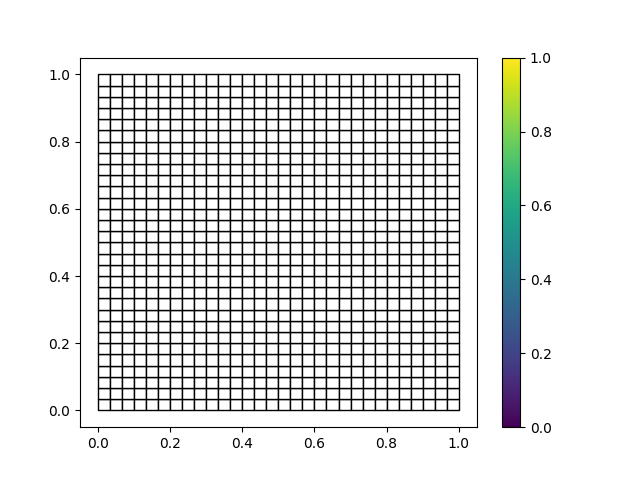

In [6]:
solver.show("U")